In [49]:
import imageio
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm
import random
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.utils import save_image
import torchvision
from torchvision.utils import make_grid
from torch.utils.data import DataLoader

from q_VAENN import VAE as Q_VAE
from c_VAENN import VAE as C_VAE
from c_NN import ClassifierNN
from FIDScore import compute_fid_score as FID

In [50]:
to_pil_image = transforms.ToPILImage() 
matplotlib.style.use('ggplot')
seed = 42
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

Hyperparameters

In [51]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
q_VAE = Q_VAE()
c_VAE = C_VAE()
Classifier = ClassifierNN()
Classifier.load_state_dict(torch.load("Models/Classifier_for_MNIST.pth"))

lr = 0.001
epochs = 200
batch_size = 400
q_optimizer = optim.Adam(q_VAE.parameters(), lr = lr)
c_optimizer = optim.Adam(c_VAE.parameters(), lr = lr)
criterion = nn.BCELoss(reduction = 'sum')
q_grid_images = []
c_grid_images = []

In [52]:
def image_to_vid(input_images, 
                 q_processing):
    images = [np.array(to_pil_image(image)) for image in input_images]
    if q_processing:
        imageio.mimsave('Outputs/Quantum-Generated-Images.gif', images)
    else:
        imageio.mimsave('Outputs/C-Generated-Images.gif', images)

In [53]:
def save_reconstructed_images(images, epoch, 
                              random_noise,
                              q_processing):
    if q_processing:
        if random_noise:
            save_image(images.cpu(), f"Outputs/Q-Images/Quantum cropped Images with Random Noise-{epoch}.jpg")
        else:
            save_image(images.cpu(), f"Outputs/Q-Images/Quantum cropped Epoch-{epoch}.jpg")
    
    else:
        if random_noise:
            save_image(images.cpu(), f"Outputs/C-Images/Quantum cropped Images with Random Noise-{epoch}.jpg")
        else:
            save_image(images.cpu(), f"Outputs/C-Images/Quantum cropped Epoch-{epoch}.jpg")

In [86]:
def save_loss_plot(c_train_loss, 
                   c_valid_loss,
                   q_train_loss,
                   q_valid_loss):
    plt.figure(figsize = (10, 7))
    plt.plot(q_train_loss, color = 'orange', label = 'Q-Train loss')
    plt.plot(q_valid_loss, color = 'yellow', label = 'Q-Validation loss')
    plt.plot(c_train_loss, color = 'red', label = 'C-Train loss')
    plt.plot(c_valid_loss, color = 'blue', label = 'C-Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('Outputs/Quantum Loss.jpg')
    plt.show()

In [87]:
def save_accuracy_plot(q_accuracy,
                       c_accuracy):
    plt.figure(figsize = (10, 7))
    plt.plot(q_accuracy, color = 'orange', label = 'Quantum-Accuracy')
    plt.plot(c_accuracy, color = 'red', label = 'Classical-Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig('Outputs/Quantum Accuracy.jpg')
    plt.show()

In [91]:
def save_fid_plot(c_fid_score_latent_space, 
                  c_fid_score_random_noise,
                  q_fid_score_latent_space, 
                  q_fid_score_random_noise):
    plt.figure(figsize = (10, 7))
    plt.plot(q_fid_score_latent_space, color = 'orange', label = 'Q-Image Reconstruction')
    plt.plot(q_fid_score_random_noise, color = 'yellow', label = 'Q-Image Generation from Random Noise')
    plt.plot(c_fid_score_latent_space, color = 'red', label = 'C-Image Reconstruction')
    plt.plot(c_fid_score_random_noise, color = 'blue', label = 'C-Image Generation from Random Noise')
    plt.xlabel('Epochs')
    plt.ylabel('FID Score')
    plt.legend()
    plt.savefig('Outputs/Quantum FID Score.jpg')
    plt.show()

In [57]:
def loss_function(criterion, reconstructed_images, real_images, mu, logvar):
    
    BCE = criterion(reconstructed_images, real_images) 
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [58]:
import torch
import torch.nn.functional as F

def compute_mse(reconstructed_images, real_images):
   # print(reconstructed_images.shape)
   # print("real image", real_images.shape)
    # Calculate Mean Squared Error
    return F.mse_loss(reconstructed_images, real_images)

In [59]:
def train(q_VAE,
          c_VAE, 
          dataloader, 
          device, 
          q_optimizer,
          c_optimizer, 
          criterion, 
          batch_size):
    q_VAE.train()
    c_VAE.train()
    q_running_loss = 0.0
    c_running_loss = 0.0
    q_running_mse = 0.0
    c_running_mse = 0.0

    for i, data in tqdm(enumerate(dataloader), total=len(dataloader)):
        q_images = data[0].to(device)
        real_images = data[1].to(device)
        
        q_optimizer.zero_grad()
        c_optimizer.zero_grad()
        
        q_reconstructed_images, q_mu, q_variance = q_VAE(q_images)
        q_loss = loss_function(criterion=criterion,
                               reconstructed_images=q_reconstructed_images,
                               real_images=real_images,
                               mu=q_mu,
                               logvar=q_variance)
        q_mse = compute_mse(q_reconstructed_images, real_images)  # Compute MSE
        q_loss.backward()
        q_running_loss += q_loss.item()
        q_running_mse += q_mse.item()  # Update running MSE
        q_optimizer.step()

        c_reconstructed_images, c_mu, c_variance = c_VAE(real_images)
        c_loss = loss_function(criterion=criterion,
                               reconstructed_images=c_reconstructed_images,
                               real_images=real_images,
                               mu=c_mu,
                               logvar=c_variance)
        c_mse = compute_mse(c_reconstructed_images, real_images)  # Compute MSE
        c_loss.backward()
        c_running_loss += c_loss.item()
        c_running_mse += c_mse.item()  # Update running MSE
        c_optimizer.step()

    q_train_loss = q_running_loss / (len(dataloader) * batch_size)
    q_train_mse = q_running_mse / (len(dataloader) * batch_size)  # Average MSE for Q-VAE
    c_train_loss = c_running_loss / (len(dataloader) * batch_size)
    c_train_mse = c_running_mse / (len(dataloader) * batch_size)  # Average MSE for C-VAE

    return q_train_loss, q_train_mse, c_train_loss, c_train_mse

In [60]:
import torch
import matplotlib.pyplot as plt

# Define a mapping from numeric labels to string labels
LABEL_MAPPING = {
    0: "0",
    1: "1",
    2: "2",
    3: "3",
    4: "4",
    5: "5",
    6: "6",
    7: "7",
    8: "8",
    9: "9"
}
def plot_images(images, predicted_labels, real_labels, title, num_images=20):
    # Ensure we're plotting at most num_images
    num_images = min(num_images, images.size(0))

    plt.figure(figsize=(15, 12))
    for idx in range(num_images):
        plt.subplot(4, 5, idx + 1)  # Adjust rows and columns for layout
        plt.imshow(images[idx].cpu().permute(1, 2, 0))  # Assuming images are in CHW format
        pred_label_str = LABEL_MAPPING[predicted_labels[idx].item()]
        real_label_str = LABEL_MAPPING[real_labels[idx].item()]
        plt.title(f'Pred: {pred_label_str}\nGroundTruth: {real_label_str}')  # Display predicted and real labels as the title
        plt.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

In [61]:
def validate(q_VAE, 
             c_VAE,
             dataloader, 
             device, 
             criterion, 
             batch_size, 
             Classifier):
    
    q_VAE.eval()
    c_VAE.eval()
    q_running_loss = 0.0
    c_running_loss = 0.0
    q_accuracy = 0.0
    c_accuracy = 0.0
    q_running_mse = 0.0  # Initialize MSE accumulator for Q-VAE
    c_running_mse = 0.0  # Initialize MSE accumulator for C-VAE
    
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=len(dataloader)):
            q_images = data[0]
            q_images = q_images.to(device)
            real_images = data[1]
            real_images = real_images.to(device)
            labels = data[2]

            q_reconstructed_images, q_mu, q_variance = q_VAE(q_images)
            q_probabilities = Classifier(q_reconstructed_images)
            q_predicted_labels = q_probabilities.argmax(dim = 1,
                                                        keepdim = True)
            q_accuracy += q_predicted_labels.eq(labels.view_as(q_predicted_labels)).sum().item()
            q_loss = loss_function(criterion = criterion,
                                   reconstructed_images = q_reconstructed_images,
                                   real_images = real_images,
                                   mu = q_mu,
                                   logvar = q_variance)
            q_mse = compute_mse(q_reconstructed_images, real_images)
            q_running_loss += q_loss.item()
            q_running_mse += q_mse.item()

            c_reconstructed_images, c_mu, c_variance = c_VAE(real_images)
            c_probabilities = Classifier(c_reconstructed_images)
            c_predicted_labels = c_probabilities.argmax(dim = 1,
                                                        keepdim = True)
            c_accuracy += c_predicted_labels.eq(labels.view_as(c_predicted_labels)).sum().item()
            c_loss = loss_function(criterion = criterion,
                                   reconstructed_images = c_reconstructed_images,
                                   real_images = real_images,
                                   mu = c_mu,
                                   logvar = c_variance)
            #print("recon", c_reconstructed_images.shape, "real", real_images.shape)
            c_mse = compute_mse(c_reconstructed_images, real_images)
            c_running_loss += c_loss.item()
            c_running_mse += c_mse.item()
    
    q_fid_latent_space = FID(real_images = real_images,
                             recontrusted_images = q_reconstructed_images,
                             batch_size = batch_size)
    c_fid_latent_space = FID(real_images = real_images,
                             recontrusted_images = c_reconstructed_images,
                             batch_size = batch_size)
    random_noise = torch.randn(batch_size, 16).to(device)
    with torch.no_grad():
        q_images_with_random_noise = q_VAE.Decoder(random_noise)
        c_images_with_random_noise = c_VAE.Decoder(random_noise)
    
    q_fid_radom_noise = FID(real_images = real_images,
                            recontrusted_images = q_images_with_random_noise,
                            batch_size = batch_size)
    c_fid_radom_noise = FID(real_images = real_images,
                            recontrusted_images = c_images_with_random_noise,
                            batch_size = batch_size)
    
    q_val_loss = q_running_loss / (len(dataloader) * batch_size)
    q_val_mse = q_running_mse / len(dataloader)
    q_accuracy = q_accuracy*100/len(dataloader.dataset)

    c_val_loss = c_running_loss / (len(dataloader) * batch_size)
    c_val_mse = c_running_mse / len(dataloader)
    c_accuracy = c_accuracy*100/len(dataloader.dataset)

    return (q_val_loss,
            q_val_mse,
            q_reconstructed_images,
            q_images_with_random_noise, 
            q_fid_latent_space.item(), 
            q_fid_radom_noise.item(),
            q_accuracy,
            c_val_loss,
            c_val_mse,
            c_reconstructed_images,
            c_images_with_random_noise, 
            c_fid_latent_space.item(), 
            c_fid_radom_noise.item(),
            c_accuracy,
            labels,
            c_predicted_labels,
            q_predicted_labels)

In [62]:
"""transform = transforms.Compose([
    transforms.Resize((16, 16)),       # First, resize to 16x16
    transforms.Resize((32, 32)),       # Then, resize to 32x32
    transforms.ToTensor()
])

# Load the original MNIST datasets
trainset = torchvision.datasets.MNIST(root='Input', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='Input', train=False, download=True, transform=transform)

# Limit the number of samples in the datasets
train_samples = 60000
test_samples = 10000

# Manually extract images and targets
q_train_images = np.load('DataSets/' + "q_train_images_16x16to32x32.npy")
train_images = []
train_targets = []
for i in range(train_samples):
    image, target = trainset[i]
    train_images.append(image)
    train_targets.append(target)

q_test_images = np.load('DataSets/' + "q_test_images_16x16to32x32.npy")
test_images = []
test_targets = []
for i in range(test_samples):
    image, target = testset[i]
    test_images.append(image)
    test_targets.append(target)

trainloader = DataLoader(list(zip(q_train_images, 
                                  train_images, 
                                  train_targets)), 
                         batch_size = batch_size, 
                         shuffle=True)
testloader = DataLoader(list(zip(q_test_images, 
                                 test_images, 
                                 test_targets)), 
                        batch_size = batch_size, 
                        shuffle=False)"""

'transform = transforms.Compose([\n    transforms.Resize((16, 16)),       # First, resize to 16x16\n    transforms.Resize((32, 32)),       # Then, resize to 32x32\n    transforms.ToTensor()\n])\n\n# Load the original MNIST datasets\ntrainset = torchvision.datasets.MNIST(root=\'Input\', train=True, download=True, transform=transform)\ntestset = torchvision.datasets.MNIST(root=\'Input\', train=False, download=True, transform=transform)\n\n# Limit the number of samples in the datasets\ntrain_samples = 60000\ntest_samples = 10000\n\n# Manually extract images and targets\nq_train_images = np.load(\'DataSets/\' + "q_train_images_16x16to32x32.npy")\ntrain_images = []\ntrain_targets = []\nfor i in range(train_samples):\n    image, target = trainset[i]\n    train_images.append(image)\n    train_targets.append(target)\n\nq_test_images = np.load(\'DataSets/\' + "q_test_images_16x16to32x32.npy")\ntest_images = []\ntest_targets = []\nfor i in range(test_samples):\n    image, target = testset[i]\n  

In [63]:
import numpy as np
from PIL import Image
from torchvision import transforms
from tqdm import tqdm

# Load the cropped MNIST images and targets
cropped_train_images = np.load('ccropped_train_images.npy',allow_pickle=True)  # Shape: (num_samples, 24, 24)
cropped_train_targets = np.load('ccropped_train_targets.npy')  # Shape: (num_samples,)
cropped_test_images = np.load('ccropped_test_images.npy',allow_pickle=True)  # Shape: (num_samples, 24, 24)
cropped_test_targets = np.load('ccropped_test_targets.npy')  # Shape: (num_samples,)

# Define the transformation to resize images to 16x16 and then to 32x32
transform = transforms.Compose([
    transforms.Resize((16, 16)),  # Resize to 16x16
    transforms.Resize((32, 32)),  # Resize to 32x32
    transforms.ToTensor()          # Convert to tensor
])

# Combine training images and targets into a structured dataset with transformations
trainset = []
for i in tqdm(range(len(cropped_train_images)), desc="Transforming training images"):
    # Create a PIL Image
    image = Image.fromarray((cropped_train_images[i] * 255).astype(np.uint8))  # Convert to PIL Image
    # Apply transformations
    image_tensor = transform(image)
    label = cropped_train_targets[i]
    trainset.append((image_tensor, label))

# Combine test images and targets into a structured dataset with transformations
testset = []
for i in tqdm(range(len(cropped_test_images)), desc="Transforming test images"):
    # Create a PIL Image
    image = Image.fromarray((cropped_test_images[i] * 255).astype(np.uint8))  # Convert to PIL Image
    # Apply transformations
    image_tensor = transform(image)
    label = cropped_test_targets[i]
    testset.append((image_tensor, label))

# Optionally, convert transformed trainset and testset to NumPy arrays for saving
train_images = np.array([img.numpy() for img, _ in trainset])  # Extracting images
train_targets = np.array([label for _, label in trainset])  # Extracting labels
test_images = np.array([img.numpy() for img, _ in testset])  # Extracting images
test_targets = np.array([label for _, label in testset])  # Extracting labels

# Save transformed datasets to .npy files
np.save('cctransformed_train_images.npy', train_images)
np.save('cctransformed_train_targets.npy', train_targets)
np.save('cctransformed_test_images.npy', test_images)
np.save('cctransformed_test_targets.npy', test_targets)

print("Transformed trainset and testset have been created and saved to .npy files.")

Transforming test images: 100%|██████████| 10000/10000 [00:03<00:00, 2649.01it/s]


Transformed trainset and testset have been created and saved to .npy files.


In [64]:
# Limit the number of samples in the datasets
train_samples = 60000
test_samples = 10000

# Manually extract images and targets
q_train_images = np.load('DataSets/' + "q_train_images_crop-SC16x16to32x32.npy")
train_images = []
train_targets = []
for i in range(train_samples):
    image, target = trainset[i]
    train_images.append(image)
    train_targets.append(target)

q_test_images = np.load('DataSets/' + "q_test_images_crop-SC16x16to32x32.npy")
test_images = []
test_targets = []
for i in range(test_samples):
    image, target = testset[i]
    test_images.append(image)
    test_targets.append(target)

trainloader = DataLoader(list(zip(q_train_images, 
                                  train_images, 
                                  train_targets)), 
                         batch_size = batch_size, 
                         shuffle=True)
testloader = DataLoader(list(zip(q_test_images, 
                                 test_images, 
                                 test_targets)), 
                        batch_size = batch_size, 
                        shuffle=False)

In [65]:
q_train_loss = []
q_valid_loss = []
q_accuracy = []
q_grid_images = []
q_fid_latent_space = []
q_fid_random_noise = []

c_train_loss = []
c_valid_loss = []
c_accuracy = []
c_grid_images = []
c_fid_latent_space = []
c_fid_random_noise = []

Epoch 1 of 200


100%|██████████| 25/25 [00:06<00:00,  3.81it/s]


Training Loss using Q VAE: 525.3318
Training Loss using C VAE: 555.8642
Validation Loss using Q VAE: 423.3918
Validation Loss using C VAE: 462.3170
Validation MSE using Q VAE: 0.0261
Validation MSE using C VAE: 0.0414
FID Score with Latent Space using Q VAE: 116.4923
FID Score with Latent Space using C VAE: 176.7882
FID Score with Random Noise using Q VAE: 185.8781
FID Score with Random Noise using C VAE: 288.6982
Classification Accuracy for Q VAE: 27.70%
Classification Accuracy for C VAE: 24.54%
Epoch 2 of 200


100%|██████████| 25/25 [00:05<00:00,  4.23it/s]


Training Loss using Q VAE: 407.7836
Training Loss using C VAE: 437.9007
Validation Loss using Q VAE: 398.8943
Validation Loss using C VAE: 420.3752
Validation MSE using Q VAE: 0.0166
Validation MSE using C VAE: 0.0257
FID Score with Latent Space using Q VAE: 82.6878
FID Score with Latent Space using C VAE: 106.7303
FID Score with Random Noise using Q VAE: 149.9561
FID Score with Random Noise using C VAE: 206.9614
Classification Accuracy for Q VAE: 28.19%
Classification Accuracy for C VAE: 27.99%
Epoch 3 of 200


100%|██████████| 25/25 [00:07<00:00,  3.30it/s]


Training Loss using Q VAE: 395.4712
Training Loss using C VAE: 412.4345
Validation Loss using Q VAE: 393.0009
Validation Loss using C VAE: 406.9293
Validation MSE using Q VAE: 0.0143
Validation MSE using C VAE: 0.0205
FID Score with Latent Space using Q VAE: 68.5813
FID Score with Latent Space using C VAE: 87.9928
FID Score with Random Noise using Q VAE: 137.3543
FID Score with Random Noise using C VAE: 178.1164
Classification Accuracy for Q VAE: 28.39%
Classification Accuracy for C VAE: 27.89%
Epoch 4 of 200


100%|██████████| 25/25 [00:09<00:00,  2.58it/s]


Training Loss using Q VAE: 391.1777
Training Loss using C VAE: 403.7331
Validation Loss using Q VAE: 390.1777
Validation Loss using C VAE: 400.8491
Validation MSE using Q VAE: 0.0134
Validation MSE using C VAE: 0.0186
FID Score with Latent Space using Q VAE: 65.2997
FID Score with Latent Space using C VAE: 79.1987
FID Score with Random Noise using Q VAE: 129.9197
FID Score with Random Noise using C VAE: 154.3326
Classification Accuracy for Q VAE: 28.46%
Classification Accuracy for C VAE: 27.57%
Epoch 5 of 200


100%|██████████| 25/25 [00:06<00:00,  3.57it/s]


Training Loss using Q VAE: 388.7627
Training Loss using C VAE: 398.3461
Validation Loss using Q VAE: 388.5411
Validation Loss using C VAE: 398.1854
Validation MSE using Q VAE: 0.0126
Validation MSE using C VAE: 0.0174
FID Score with Latent Space using Q VAE: 59.2613
FID Score with Latent Space using C VAE: 72.2920
FID Score with Random Noise using Q VAE: 121.2011
FID Score with Random Noise using C VAE: 142.2338
Classification Accuracy for Q VAE: 28.00%
Classification Accuracy for C VAE: 27.21%
Epoch 6 of 200


100%|██████████| 25/25 [00:06<00:00,  4.16it/s]


Training Loss using Q VAE: 387.2327
Training Loss using C VAE: 395.1277
Validation Loss using Q VAE: 386.9204
Validation Loss using C VAE: 394.3910
Validation MSE using Q VAE: 0.0122
Validation MSE using C VAE: 0.0164
FID Score with Latent Space using Q VAE: 57.7050
FID Score with Latent Space using C VAE: 71.1396
FID Score with Random Noise using Q VAE: 123.5143
FID Score with Random Noise using C VAE: 136.5215
Classification Accuracy for Q VAE: 28.45%
Classification Accuracy for C VAE: 26.80%
Epoch 7 of 200


100%|██████████| 25/25 [00:07<00:00,  3.23it/s]


Training Loss using Q VAE: 386.0018
Training Loss using C VAE: 393.0068
Validation Loss using Q VAE: 386.2397
Validation Loss using C VAE: 392.5174
Validation MSE using Q VAE: 0.0120
Validation MSE using C VAE: 0.0156
FID Score with Latent Space using Q VAE: 56.6095
FID Score with Latent Space using C VAE: 67.1322
FID Score with Random Noise using Q VAE: 118.0675
FID Score with Random Noise using C VAE: 132.2827
Classification Accuracy for Q VAE: 27.51%
Classification Accuracy for C VAE: 27.60%
Epoch 8 of 200


100%|██████████| 25/25 [00:04<00:00,  5.70it/s]


Training Loss using Q VAE: 385.0616
Training Loss using C VAE: 391.5567
Validation Loss using Q VAE: 385.6447
Validation Loss using C VAE: 391.7064
Validation MSE using Q VAE: 0.0119
Validation MSE using C VAE: 0.0152
FID Score with Latent Space using Q VAE: 52.8778
FID Score with Latent Space using C VAE: 66.8778
FID Score with Random Noise using Q VAE: 111.8831
FID Score with Random Noise using C VAE: 122.8867
Classification Accuracy for Q VAE: 28.30%
Classification Accuracy for C VAE: 27.54%
Epoch 9 of 200


100%|██████████| 25/25 [00:04<00:00,  5.04it/s]


Training Loss using Q VAE: 384.3739
Training Loss using C VAE: 390.4346
Validation Loss using Q VAE: 384.5884
Validation Loss using C VAE: 389.9767
Validation MSE using Q VAE: 0.0114
Validation MSE using C VAE: 0.0147
FID Score with Latent Space using Q VAE: 52.1642
FID Score with Latent Space using C VAE: 64.2910
FID Score with Random Noise using Q VAE: 106.7115
FID Score with Random Noise using C VAE: 124.0081
Classification Accuracy for Q VAE: 28.02%
Classification Accuracy for C VAE: 27.23%
Epoch 10 of 200


100%|██████████| 25/25 [00:04<00:00,  5.30it/s]


Training Loss using Q VAE: 383.7705
Training Loss using C VAE: 389.3110
Validation Loss using Q VAE: 384.1784
Validation Loss using C VAE: 389.5572
Validation MSE using Q VAE: 0.0113
Validation MSE using C VAE: 0.0145
FID Score with Latent Space using Q VAE: 51.9818
FID Score with Latent Space using C VAE: 62.9135
FID Score with Random Noise using Q VAE: 110.9364
FID Score with Random Noise using C VAE: 121.1932
Classification Accuracy for Q VAE: 27.62%
Classification Accuracy for C VAE: 27.65%
Epoch 11 of 200


100%|██████████| 25/25 [00:04<00:00,  5.09it/s]


Training Loss using Q VAE: 383.1987
Training Loss using C VAE: 388.5383
Validation Loss using Q VAE: 383.7462
Validation Loss using C VAE: 388.2444
Validation MSE using Q VAE: 0.0111
Validation MSE using C VAE: 0.0143
FID Score with Latent Space using Q VAE: 50.7576
FID Score with Latent Space using C VAE: 60.4275
FID Score with Random Noise using Q VAE: 111.4426
FID Score with Random Noise using C VAE: 114.6073
Classification Accuracy for Q VAE: 27.45%
Classification Accuracy for C VAE: 27.50%
Epoch 12 of 200


100%|██████████| 25/25 [00:03<00:00,  6.29it/s]


Training Loss using Q VAE: 382.7684
Training Loss using C VAE: 387.7751
Validation Loss using Q VAE: 383.2385
Validation Loss using C VAE: 388.3184
Validation MSE using Q VAE: 0.0111
Validation MSE using C VAE: 0.0141
FID Score with Latent Space using Q VAE: 51.3722
FID Score with Latent Space using C VAE: 60.0435
FID Score with Random Noise using Q VAE: 113.3078
FID Score with Random Noise using C VAE: 111.4977
Classification Accuracy for Q VAE: 27.86%
Classification Accuracy for C VAE: 28.11%
Epoch 13 of 200


100%|██████████| 25/25 [00:02<00:00,  8.60it/s]


Training Loss using Q VAE: 382.3155
Training Loss using C VAE: 387.0947
Validation Loss using Q VAE: 383.0949
Validation Loss using C VAE: 387.4127
Validation MSE using Q VAE: 0.0109
Validation MSE using C VAE: 0.0138
FID Score with Latent Space using Q VAE: 48.2104
FID Score with Latent Space using C VAE: 60.0804
FID Score with Random Noise using Q VAE: 111.4291
FID Score with Random Noise using C VAE: 114.9030
Classification Accuracy for Q VAE: 27.89%
Classification Accuracy for C VAE: 27.97%
Epoch 14 of 200


100%|██████████| 25/25 [00:04<00:00,  5.15it/s]


Training Loss using Q VAE: 381.9667
Training Loss using C VAE: 386.1215
Validation Loss using Q VAE: 382.4605
Validation Loss using C VAE: 386.0829
Validation MSE using Q VAE: 0.0108
Validation MSE using C VAE: 0.0132
FID Score with Latent Space using Q VAE: 48.5111
FID Score with Latent Space using C VAE: 57.4035
FID Score with Random Noise using Q VAE: 106.3569
FID Score with Random Noise using C VAE: 108.6719
Classification Accuracy for Q VAE: 27.13%
Classification Accuracy for C VAE: 27.92%
Epoch 15 of 200


100%|██████████| 25/25 [00:07<00:00,  3.44it/s]


Training Loss using Q VAE: 381.6175
Training Loss using C VAE: 385.5850
Validation Loss using Q VAE: 382.4505
Validation Loss using C VAE: 386.3076
Validation MSE using Q VAE: 0.0109
Validation MSE using C VAE: 0.0134
FID Score with Latent Space using Q VAE: 46.2557
FID Score with Latent Space using C VAE: 57.2833
FID Score with Random Noise using Q VAE: 100.6996
FID Score with Random Noise using C VAE: 113.8910
Classification Accuracy for Q VAE: 27.50%
Classification Accuracy for C VAE: 28.47%
Epoch 16 of 200


100%|██████████| 25/25 [00:04<00:00,  5.04it/s]


Training Loss using Q VAE: 381.2793
Training Loss using C VAE: 384.9641
Validation Loss using Q VAE: 382.1776
Validation Loss using C VAE: 385.4147
Validation MSE using Q VAE: 0.0108
Validation MSE using C VAE: 0.0131
FID Score with Latent Space using Q VAE: 47.8306
FID Score with Latent Space using C VAE: 56.0315
FID Score with Random Noise using Q VAE: 108.2586
FID Score with Random Noise using C VAE: 107.7353
Classification Accuracy for Q VAE: 28.19%
Classification Accuracy for C VAE: 27.18%
Epoch 17 of 200


100%|██████████| 25/25 [00:03<00:00,  6.53it/s]


Training Loss using Q VAE: 381.0909
Training Loss using C VAE: 384.7669
Validation Loss using Q VAE: 381.9828
Validation Loss using C VAE: 384.8440
Validation MSE using Q VAE: 0.0107
Validation MSE using C VAE: 0.0128
FID Score with Latent Space using Q VAE: 47.1031
FID Score with Latent Space using C VAE: 55.0239
FID Score with Random Noise using Q VAE: 105.5029
FID Score with Random Noise using C VAE: 103.5542
Classification Accuracy for Q VAE: 28.18%
Classification Accuracy for C VAE: 27.87%
Epoch 18 of 200


100%|██████████| 25/25 [00:04<00:00,  5.25it/s]


Training Loss using Q VAE: 380.7426
Training Loss using C VAE: 384.1840
Validation Loss using Q VAE: 381.5064
Validation Loss using C VAE: 384.8726
Validation MSE using Q VAE: 0.0105
Validation MSE using C VAE: 0.0128
FID Score with Latent Space using Q VAE: 44.8528
FID Score with Latent Space using C VAE: 54.2506
FID Score with Random Noise using Q VAE: 107.2380
FID Score with Random Noise using C VAE: 106.7361
Classification Accuracy for Q VAE: 28.05%
Classification Accuracy for C VAE: 27.78%
Epoch 19 of 200


100%|██████████| 25/25 [00:04<00:00,  5.87it/s]


Training Loss using Q VAE: 380.5075
Training Loss using C VAE: 383.8049
Validation Loss using Q VAE: 381.1811
Validation Loss using C VAE: 384.3342
Validation MSE using Q VAE: 0.0103
Validation MSE using C VAE: 0.0126
FID Score with Latent Space using Q VAE: 43.3879
FID Score with Latent Space using C VAE: 51.6542
FID Score with Random Noise using Q VAE: 97.9883
FID Score with Random Noise using C VAE: 101.3051
Classification Accuracy for Q VAE: 27.84%
Classification Accuracy for C VAE: 28.27%
Epoch 20 of 200


100%|██████████| 25/25 [00:05<00:00,  4.21it/s]


Training Loss using Q VAE: 380.2834
Training Loss using C VAE: 383.5518
Validation Loss using Q VAE: 380.8354
Validation Loss using C VAE: 384.0280
Validation MSE using Q VAE: 0.0104
Validation MSE using C VAE: 0.0124
FID Score with Latent Space using Q VAE: 44.8786
FID Score with Latent Space using C VAE: 50.9711
FID Score with Random Noise using Q VAE: 103.4574
FID Score with Random Noise using C VAE: 102.8810
Classification Accuracy for Q VAE: 27.98%
Classification Accuracy for C VAE: 27.77%
Epoch 21 of 200


100%|██████████| 25/25 [00:02<00:00, 11.24it/s]


Training Loss using Q VAE: 380.0227
Training Loss using C VAE: 383.2007
Validation Loss using Q VAE: 380.8482
Validation Loss using C VAE: 384.7808
Validation MSE using Q VAE: 0.0104
Validation MSE using C VAE: 0.0129
FID Score with Latent Space using Q VAE: 45.4760
FID Score with Latent Space using C VAE: 52.9841
FID Score with Random Noise using Q VAE: 98.0692
FID Score with Random Noise using C VAE: 102.7454
Classification Accuracy for Q VAE: 28.09%
Classification Accuracy for C VAE: 28.37%
Epoch 22 of 200


100%|██████████| 25/25 [00:03<00:00,  7.86it/s]


Training Loss using Q VAE: 379.8689
Training Loss using C VAE: 382.9270
Validation Loss using Q VAE: 380.6329
Validation Loss using C VAE: 383.6339
Validation MSE using Q VAE: 0.0103
Validation MSE using C VAE: 0.0124
FID Score with Latent Space using Q VAE: 44.1062
FID Score with Latent Space using C VAE: 51.5437
FID Score with Random Noise using Q VAE: 99.4336
FID Score with Random Noise using C VAE: 101.8908
Classification Accuracy for Q VAE: 27.60%
Classification Accuracy for C VAE: 27.46%
Epoch 23 of 200


100%|██████████| 25/25 [00:02<00:00,  8.38it/s]


Training Loss using Q VAE: 379.7489
Training Loss using C VAE: 382.5148
Validation Loss using Q VAE: 380.7109
Validation Loss using C VAE: 382.8327
Validation MSE using Q VAE: 0.0102
Validation MSE using C VAE: 0.0121
FID Score with Latent Space using Q VAE: 43.1532
FID Score with Latent Space using C VAE: 50.5243
FID Score with Random Noise using Q VAE: 102.7203
FID Score with Random Noise using C VAE: 99.1162
Classification Accuracy for Q VAE: 27.18%
Classification Accuracy for C VAE: 27.50%
Epoch 24 of 200


100%|██████████| 25/25 [00:02<00:00,  8.94it/s]


Training Loss using Q VAE: 379.5398
Training Loss using C VAE: 382.0812
Validation Loss using Q VAE: 380.3689
Validation Loss using C VAE: 382.6447
Validation MSE using Q VAE: 0.0102
Validation MSE using C VAE: 0.0118
FID Score with Latent Space using Q VAE: 44.9630
FID Score with Latent Space using C VAE: 50.9627
FID Score with Random Noise using Q VAE: 96.9426
FID Score with Random Noise using C VAE: 102.0720
Classification Accuracy for Q VAE: 27.93%
Classification Accuracy for C VAE: 27.84%
Epoch 25 of 200


100%|██████████| 25/25 [00:02<00:00, 12.40it/s]


Training Loss using Q VAE: 379.3936
Training Loss using C VAE: 381.8940
Validation Loss using Q VAE: 380.0490
Validation Loss using C VAE: 382.5678
Validation MSE using Q VAE: 0.0100
Validation MSE using C VAE: 0.0118
FID Score with Latent Space using Q VAE: 43.9886
FID Score with Latent Space using C VAE: 49.2657
FID Score with Random Noise using Q VAE: 101.2407
FID Score with Random Noise using C VAE: 98.9942
Classification Accuracy for Q VAE: 28.45%
Classification Accuracy for C VAE: 27.71%
Epoch 26 of 200


100%|██████████| 25/25 [00:03<00:00,  7.86it/s]


Training Loss using Q VAE: 379.2670
Training Loss using C VAE: 381.5949
Validation Loss using Q VAE: 380.0531
Validation Loss using C VAE: 382.5243
Validation MSE using Q VAE: 0.0101
Validation MSE using C VAE: 0.0117
FID Score with Latent Space using Q VAE: 43.1104
FID Score with Latent Space using C VAE: 48.9585
FID Score with Random Noise using Q VAE: 97.3949
FID Score with Random Noise using C VAE: 100.3618
Classification Accuracy for Q VAE: 27.44%
Classification Accuracy for C VAE: 28.04%
Epoch 27 of 200


100%|██████████| 25/25 [00:04<00:00,  5.79it/s]


Training Loss using Q VAE: 379.1066
Training Loss using C VAE: 381.3643
Validation Loss using Q VAE: 380.1912
Validation Loss using C VAE: 381.9352
Validation MSE using Q VAE: 0.0101
Validation MSE using C VAE: 0.0116
FID Score with Latent Space using Q VAE: 44.6809
FID Score with Latent Space using C VAE: 49.5072
FID Score with Random Noise using Q VAE: 96.9303
FID Score with Random Noise using C VAE: 101.1284
Classification Accuracy for Q VAE: 27.93%
Classification Accuracy for C VAE: 28.04%
Epoch 28 of 200


100%|██████████| 25/25 [00:02<00:00,  8.77it/s]


Training Loss using Q VAE: 379.0311
Training Loss using C VAE: 381.0728
Validation Loss using Q VAE: 379.7733
Validation Loss using C VAE: 381.8772
Validation MSE using Q VAE: 0.0101
Validation MSE using C VAE: 0.0116
FID Score with Latent Space using Q VAE: 42.9221
FID Score with Latent Space using C VAE: 49.8494
FID Score with Random Noise using Q VAE: 97.2360
FID Score with Random Noise using C VAE: 102.2113
Classification Accuracy for Q VAE: 27.53%
Classification Accuracy for C VAE: 28.09%
Epoch 29 of 200


100%|██████████| 25/25 [00:03<00:00,  8.20it/s]


Training Loss using Q VAE: 378.8802
Training Loss using C VAE: 380.9618
Validation Loss using Q VAE: 379.5201
Validation Loss using C VAE: 381.6316
Validation MSE using Q VAE: 0.0099
Validation MSE using C VAE: 0.0115
FID Score with Latent Space using Q VAE: 42.1777
FID Score with Latent Space using C VAE: 48.6645
FID Score with Random Noise using Q VAE: 96.9312
FID Score with Random Noise using C VAE: 100.6288
Classification Accuracy for Q VAE: 28.19%
Classification Accuracy for C VAE: 27.41%
Epoch 30 of 200


100%|██████████| 25/25 [00:02<00:00,  8.34it/s]


Training Loss using Q VAE: 378.7333
Training Loss using C VAE: 380.7776
Validation Loss using Q VAE: 379.7207
Validation Loss using C VAE: 381.4732
Validation MSE using Q VAE: 0.0100
Validation MSE using C VAE: 0.0114
FID Score with Latent Space using Q VAE: 43.1552
FID Score with Latent Space using C VAE: 48.9668
FID Score with Random Noise using Q VAE: 96.0888
FID Score with Random Noise using C VAE: 98.7604
Classification Accuracy for Q VAE: 28.10%
Classification Accuracy for C VAE: 27.88%
Epoch 31 of 200


100%|██████████| 25/25 [00:02<00:00,  9.62it/s]


Training Loss using Q VAE: 378.5970
Training Loss using C VAE: 380.6830
Validation Loss using Q VAE: 379.5232
Validation Loss using C VAE: 381.1589
Validation MSE using Q VAE: 0.0099
Validation MSE using C VAE: 0.0112
FID Score with Latent Space using Q VAE: 42.9836
FID Score with Latent Space using C VAE: 49.6117
FID Score with Random Noise using Q VAE: 94.0280
FID Score with Random Noise using C VAE: 92.0198
Classification Accuracy for Q VAE: 27.95%
Classification Accuracy for C VAE: 28.26%
Epoch 32 of 200


100%|██████████| 25/25 [00:02<00:00, 11.14it/s]


Training Loss using Q VAE: 378.5150
Training Loss using C VAE: 380.5613
Validation Loss using Q VAE: 379.2679
Validation Loss using C VAE: 381.3301
Validation MSE using Q VAE: 0.0099
Validation MSE using C VAE: 0.0113
FID Score with Latent Space using Q VAE: 41.2858
FID Score with Latent Space using C VAE: 47.8741
FID Score with Random Noise using Q VAE: 92.8103
FID Score with Random Noise using C VAE: 95.0944
Classification Accuracy for Q VAE: 27.84%
Classification Accuracy for C VAE: 28.06%
Epoch 33 of 200


100%|██████████| 25/25 [00:02<00:00, 10.98it/s]


Training Loss using Q VAE: 378.4481
Training Loss using C VAE: 380.3506
Validation Loss using Q VAE: 379.4742
Validation Loss using C VAE: 381.4736
Validation MSE using Q VAE: 0.0100
Validation MSE using C VAE: 0.0113
FID Score with Latent Space using Q VAE: 41.7609
FID Score with Latent Space using C VAE: 47.3447
FID Score with Random Noise using Q VAE: 96.1644
FID Score with Random Noise using C VAE: 96.8103
Classification Accuracy for Q VAE: 28.00%
Classification Accuracy for C VAE: 28.26%
Epoch 34 of 200


100%|██████████| 25/25 [00:02<00:00,  9.33it/s]


Training Loss using Q VAE: 378.3359
Training Loss using C VAE: 380.2777
Validation Loss using Q VAE: 379.2969
Validation Loss using C VAE: 381.1383
Validation MSE using Q VAE: 0.0098
Validation MSE using C VAE: 0.0113
FID Score with Latent Space using Q VAE: 42.4386
FID Score with Latent Space using C VAE: 47.2258
FID Score with Random Noise using Q VAE: 91.0698
FID Score with Random Noise using C VAE: 97.0092
Classification Accuracy for Q VAE: 28.32%
Classification Accuracy for C VAE: 28.13%
Epoch 35 of 200


100%|██████████| 25/25 [00:02<00:00,  9.06it/s]


Training Loss using Q VAE: 378.2163
Training Loss using C VAE: 380.2241
Validation Loss using Q VAE: 379.0830
Validation Loss using C VAE: 380.6730
Validation MSE using Q VAE: 0.0098
Validation MSE using C VAE: 0.0111
FID Score with Latent Space using Q VAE: 42.9322
FID Score with Latent Space using C VAE: 46.5706
FID Score with Random Noise using Q VAE: 92.2542
FID Score with Random Noise using C VAE: 95.3139
Classification Accuracy for Q VAE: 28.06%
Classification Accuracy for C VAE: 27.93%
Epoch 36 of 200


100%|██████████| 25/25 [00:02<00:00, 10.72it/s]


Training Loss using Q VAE: 378.1343
Training Loss using C VAE: 380.0378
Validation Loss using Q VAE: 378.9716
Validation Loss using C VAE: 380.7867
Validation MSE using Q VAE: 0.0098
Validation MSE using C VAE: 0.0111
FID Score with Latent Space using Q VAE: 42.6148
FID Score with Latent Space using C VAE: 47.5521
FID Score with Random Noise using Q VAE: 96.5753
FID Score with Random Noise using C VAE: 99.9025
Classification Accuracy for Q VAE: 28.36%
Classification Accuracy for C VAE: 27.91%
Epoch 37 of 200


100%|██████████| 25/25 [00:02<00:00, 10.80it/s]


Training Loss using Q VAE: 378.0111
Training Loss using C VAE: 379.8273
Validation Loss using Q VAE: 378.9908
Validation Loss using C VAE: 380.6017
Validation MSE using Q VAE: 0.0098
Validation MSE using C VAE: 0.0111
FID Score with Latent Space using Q VAE: 42.0880
FID Score with Latent Space using C VAE: 45.5540
FID Score with Random Noise using Q VAE: 89.4547
FID Score with Random Noise using C VAE: 99.0834
Classification Accuracy for Q VAE: 28.20%
Classification Accuracy for C VAE: 28.18%
Epoch 38 of 200


100%|██████████| 25/25 [00:02<00:00, 11.19it/s]


Training Loss using Q VAE: 377.9225
Training Loss using C VAE: 379.8653
Validation Loss using Q VAE: 378.7486
Validation Loss using C VAE: 380.8980
Validation MSE using Q VAE: 0.0098
Validation MSE using C VAE: 0.0111
FID Score with Latent Space using Q VAE: 42.6751
FID Score with Latent Space using C VAE: 47.0102
FID Score with Random Noise using Q VAE: 93.0457
FID Score with Random Noise using C VAE: 94.9264
Classification Accuracy for Q VAE: 27.82%
Classification Accuracy for C VAE: 27.48%
Epoch 39 of 200


100%|██████████| 25/25 [00:02<00:00,  9.36it/s]


Training Loss using Q VAE: 377.8475
Training Loss using C VAE: 379.6806
Validation Loss using Q VAE: 378.7717
Validation Loss using C VAE: 380.3668
Validation MSE using Q VAE: 0.0098
Validation MSE using C VAE: 0.0110
FID Score with Latent Space using Q VAE: 41.2204
FID Score with Latent Space using C VAE: 46.6935
FID Score with Random Noise using Q VAE: 93.2301
FID Score with Random Noise using C VAE: 98.8343
Classification Accuracy for Q VAE: 27.78%
Classification Accuracy for C VAE: 28.43%
Epoch 40 of 200


100%|██████████| 25/25 [00:03<00:00,  8.13it/s]


Training Loss using Q VAE: 377.8193
Training Loss using C VAE: 379.5416
Validation Loss using Q VAE: 378.8690
Validation Loss using C VAE: 380.3779
Validation MSE using Q VAE: 0.0097
Validation MSE using C VAE: 0.0109
FID Score with Latent Space using Q VAE: 42.4034
FID Score with Latent Space using C VAE: 47.2776
FID Score with Random Noise using Q VAE: 88.4407
FID Score with Random Noise using C VAE: 98.5650
Classification Accuracy for Q VAE: 27.34%
Classification Accuracy for C VAE: 27.83%
Epoch 41 of 200


100%|██████████| 25/25 [00:02<00:00, 10.46it/s]


Training Loss using Q VAE: 377.7562
Training Loss using C VAE: 379.4545
Validation Loss using Q VAE: 378.7956
Validation Loss using C VAE: 380.3216
Validation MSE using Q VAE: 0.0097
Validation MSE using C VAE: 0.0109
FID Score with Latent Space using Q VAE: 42.4900
FID Score with Latent Space using C VAE: 45.5931
FID Score with Random Noise using Q VAE: 95.7528
FID Score with Random Noise using C VAE: 94.6705
Classification Accuracy for Q VAE: 27.97%
Classification Accuracy for C VAE: 28.56%
Epoch 42 of 200


100%|██████████| 25/25 [00:02<00:00, 11.28it/s]


Training Loss using Q VAE: 377.6626
Training Loss using C VAE: 379.4202
Validation Loss using Q VAE: 378.6113
Validation Loss using C VAE: 380.7569
Validation MSE using Q VAE: 0.0096
Validation MSE using C VAE: 0.0112
FID Score with Latent Space using Q VAE: 42.9728
FID Score with Latent Space using C VAE: 46.9624
FID Score with Random Noise using Q VAE: 93.5229
FID Score with Random Noise using C VAE: 94.4925
Classification Accuracy for Q VAE: 28.08%
Classification Accuracy for C VAE: 28.50%
Epoch 43 of 200


100%|██████████| 25/25 [00:02<00:00, 11.49it/s]


Training Loss using Q VAE: 377.6513
Training Loss using C VAE: 379.3073
Validation Loss using Q VAE: 378.5367
Validation Loss using C VAE: 379.8821
Validation MSE using Q VAE: 0.0096
Validation MSE using C VAE: 0.0107
FID Score with Latent Space using Q VAE: 40.7644
FID Score with Latent Space using C VAE: 45.9246
FID Score with Random Noise using Q VAE: 89.6742
FID Score with Random Noise using C VAE: 95.7474
Classification Accuracy for Q VAE: 28.10%
Classification Accuracy for C VAE: 28.06%
Epoch 44 of 200


100%|██████████| 25/25 [00:02<00:00, 11.57it/s]


Training Loss using Q VAE: 377.4806
Training Loss using C VAE: 379.2824
Validation Loss using Q VAE: 378.5847
Validation Loss using C VAE: 380.5858
Validation MSE using Q VAE: 0.0096
Validation MSE using C VAE: 0.0111
FID Score with Latent Space using Q VAE: 40.6504
FID Score with Latent Space using C VAE: 44.8243
FID Score with Random Noise using Q VAE: 89.2825
FID Score with Random Noise using C VAE: 95.8331
Classification Accuracy for Q VAE: 27.66%
Classification Accuracy for C VAE: 28.69%
Epoch 45 of 200


100%|██████████| 25/25 [00:02<00:00,  8.88it/s]


Training Loss using Q VAE: 377.4599
Training Loss using C VAE: 379.2812
Validation Loss using Q VAE: 378.4152
Validation Loss using C VAE: 379.6949
Validation MSE using Q VAE: 0.0097
Validation MSE using C VAE: 0.0107
FID Score with Latent Space using Q VAE: 42.5037
FID Score with Latent Space using C VAE: 45.2219
FID Score with Random Noise using Q VAE: 91.9029
FID Score with Random Noise using C VAE: 96.5725
Classification Accuracy for Q VAE: 27.94%
Classification Accuracy for C VAE: 28.03%
Epoch 46 of 200


100%|██████████| 25/25 [00:04<00:00,  5.54it/s]


Training Loss using Q VAE: 377.4060
Training Loss using C VAE: 379.1210
Validation Loss using Q VAE: 378.3316
Validation Loss using C VAE: 380.2498
Validation MSE using Q VAE: 0.0096
Validation MSE using C VAE: 0.0108
FID Score with Latent Space using Q VAE: 40.6878
FID Score with Latent Space using C VAE: 45.0636
FID Score with Random Noise using Q VAE: 91.4121
FID Score with Random Noise using C VAE: 96.6124
Classification Accuracy for Q VAE: 27.95%
Classification Accuracy for C VAE: 27.88%
Epoch 47 of 200


100%|██████████| 25/25 [00:04<00:00,  5.78it/s]


Training Loss using Q VAE: 377.3709
Training Loss using C VAE: 378.9578
Validation Loss using Q VAE: 378.2693
Validation Loss using C VAE: 380.2170
Validation MSE using Q VAE: 0.0097
Validation MSE using C VAE: 0.0108
FID Score with Latent Space using Q VAE: 40.6142
FID Score with Latent Space using C VAE: 44.3933
FID Score with Random Noise using Q VAE: 88.6800
FID Score with Random Noise using C VAE: 97.9000
Classification Accuracy for Q VAE: 28.09%
Classification Accuracy for C VAE: 27.80%
Epoch 48 of 200


100%|██████████| 25/25 [00:03<00:00,  6.99it/s]


Training Loss using Q VAE: 377.3048
Training Loss using C VAE: 378.9617
Validation Loss using Q VAE: 378.2539
Validation Loss using C VAE: 379.8210
Validation MSE using Q VAE: 0.0097
Validation MSE using C VAE: 0.0108
FID Score with Latent Space using Q VAE: 41.0252
FID Score with Latent Space using C VAE: 44.6464
FID Score with Random Noise using Q VAE: 90.3736
FID Score with Random Noise using C VAE: 101.0223
Classification Accuracy for Q VAE: 27.95%
Classification Accuracy for C VAE: 28.70%
Epoch 49 of 200


100%|██████████| 25/25 [00:02<00:00,  8.95it/s]


Training Loss using Q VAE: 377.2191
Training Loss using C VAE: 378.9184
Validation Loss using Q VAE: 378.1727
Validation Loss using C VAE: 379.8015
Validation MSE using Q VAE: 0.0095
Validation MSE using C VAE: 0.0106
FID Score with Latent Space using Q VAE: 42.0164
FID Score with Latent Space using C VAE: 44.1288
FID Score with Random Noise using Q VAE: 86.9068
FID Score with Random Noise using C VAE: 93.4226
Classification Accuracy for Q VAE: 27.97%
Classification Accuracy for C VAE: 28.38%
Epoch 50 of 200


100%|██████████| 25/25 [00:02<00:00, 11.38it/s]


Training Loss using Q VAE: 377.1971
Training Loss using C VAE: 378.8814
Validation Loss using Q VAE: 378.1986
Validation Loss using C VAE: 379.7125
Validation MSE using Q VAE: 0.0096
Validation MSE using C VAE: 0.0107
FID Score with Latent Space using Q VAE: 40.6623
FID Score with Latent Space using C VAE: 45.1258
FID Score with Random Noise using Q VAE: 88.7190
FID Score with Random Noise using C VAE: 97.9859
Classification Accuracy for Q VAE: 28.14%
Classification Accuracy for C VAE: 28.56%
Epoch 51 of 200


100%|██████████| 25/25 [00:01<00:00, 12.90it/s]


Training Loss using Q VAE: 377.1039
Training Loss using C VAE: 378.6448
Validation Loss using Q VAE: 378.1689
Validation Loss using C VAE: 380.0729
Validation MSE using Q VAE: 0.0096
Validation MSE using C VAE: 0.0107
FID Score with Latent Space using Q VAE: 40.7108
FID Score with Latent Space using C VAE: 44.6723
FID Score with Random Noise using Q VAE: 87.3064
FID Score with Random Noise using C VAE: 88.8005
Classification Accuracy for Q VAE: 27.98%
Classification Accuracy for C VAE: 27.44%
Epoch 52 of 200


100%|██████████| 25/25 [00:03<00:00,  7.13it/s]


Training Loss using Q VAE: 377.0450
Training Loss using C VAE: 378.6481
Validation Loss using Q VAE: 378.0580
Validation Loss using C VAE: 380.0973
Validation MSE using Q VAE: 0.0094
Validation MSE using C VAE: 0.0107
FID Score with Latent Space using Q VAE: 40.5168
FID Score with Latent Space using C VAE: 44.6294
FID Score with Random Noise using Q VAE: 87.2239
FID Score with Random Noise using C VAE: 95.8293
Classification Accuracy for Q VAE: 27.65%
Classification Accuracy for C VAE: 27.71%
Epoch 53 of 200


100%|██████████| 25/25 [00:02<00:00, 11.13it/s]


Training Loss using Q VAE: 376.9661
Training Loss using C VAE: 378.5532
Validation Loss using Q VAE: 378.1060
Validation Loss using C VAE: 379.3305
Validation MSE using Q VAE: 0.0095
Validation MSE using C VAE: 0.0106
FID Score with Latent Space using Q VAE: 41.0833
FID Score with Latent Space using C VAE: 45.0351
FID Score with Random Noise using Q VAE: 90.1891
FID Score with Random Noise using C VAE: 96.1212
Classification Accuracy for Q VAE: 28.25%
Classification Accuracy for C VAE: 28.16%
Epoch 54 of 200


100%|██████████| 25/25 [00:02<00:00, 10.30it/s]


Training Loss using Q VAE: 376.9453
Training Loss using C VAE: 378.5025
Validation Loss using Q VAE: 377.9473
Validation Loss using C VAE: 378.8672
Validation MSE using Q VAE: 0.0094
Validation MSE using C VAE: 0.0104
FID Score with Latent Space using Q VAE: 42.3096
FID Score with Latent Space using C VAE: 43.9111
FID Score with Random Noise using Q VAE: 86.0226
FID Score with Random Noise using C VAE: 92.6534
Classification Accuracy for Q VAE: 27.68%
Classification Accuracy for C VAE: 28.36%
Epoch 55 of 200


100%|██████████| 25/25 [00:02<00:00, 10.87it/s]


Training Loss using Q VAE: 376.8734
Training Loss using C VAE: 378.3090
Validation Loss using Q VAE: 377.8818
Validation Loss using C VAE: 379.1523
Validation MSE using Q VAE: 0.0095
Validation MSE using C VAE: 0.0106
FID Score with Latent Space using Q VAE: 40.5673
FID Score with Latent Space using C VAE: 43.2883
FID Score with Random Noise using Q VAE: 85.9622
FID Score with Random Noise using C VAE: 99.2587
Classification Accuracy for Q VAE: 27.60%
Classification Accuracy for C VAE: 28.55%
Epoch 56 of 200


100%|██████████| 25/25 [00:02<00:00, 11.75it/s]


Training Loss using Q VAE: 376.8702
Training Loss using C VAE: 378.2668
Validation Loss using Q VAE: 377.8978
Validation Loss using C VAE: 379.1119
Validation MSE using Q VAE: 0.0095
Validation MSE using C VAE: 0.0104
FID Score with Latent Space using Q VAE: 40.8751
FID Score with Latent Space using C VAE: 42.8077
FID Score with Random Noise using Q VAE: 89.7146
FID Score with Random Noise using C VAE: 91.0802
Classification Accuracy for Q VAE: 27.68%
Classification Accuracy for C VAE: 28.25%
Epoch 57 of 200


100%|██████████| 25/25 [00:02<00:00, 11.02it/s]


Training Loss using Q VAE: 376.7483
Training Loss using C VAE: 378.1217
Validation Loss using Q VAE: 377.7205
Validation Loss using C VAE: 378.8636
Validation MSE using Q VAE: 0.0094
Validation MSE using C VAE: 0.0102
FID Score with Latent Space using Q VAE: 39.8877
FID Score with Latent Space using C VAE: 42.9119
FID Score with Random Noise using Q VAE: 89.5840
FID Score with Random Noise using C VAE: 96.2828
Classification Accuracy for Q VAE: 28.23%
Classification Accuracy for C VAE: 28.86%
Epoch 58 of 200


100%|██████████| 25/25 [00:02<00:00, 10.29it/s]


Training Loss using Q VAE: 376.6965
Training Loss using C VAE: 378.0209
Validation Loss using Q VAE: 377.7608
Validation Loss using C VAE: 378.9362
Validation MSE using Q VAE: 0.0094
Validation MSE using C VAE: 0.0103
FID Score with Latent Space using Q VAE: 39.5887
FID Score with Latent Space using C VAE: 43.7066
FID Score with Random Noise using Q VAE: 89.0624
FID Score with Random Noise using C VAE: 93.6127
Classification Accuracy for Q VAE: 28.06%
Classification Accuracy for C VAE: 27.64%
Epoch 59 of 200


100%|██████████| 25/25 [00:02<00:00,  9.70it/s]


Training Loss using Q VAE: 376.6855
Training Loss using C VAE: 377.9781
Validation Loss using Q VAE: 377.8398
Validation Loss using C VAE: 378.7168
Validation MSE using Q VAE: 0.0094
Validation MSE using C VAE: 0.0101
FID Score with Latent Space using Q VAE: 40.1811
FID Score with Latent Space using C VAE: 43.1240
FID Score with Random Noise using Q VAE: 88.5471
FID Score with Random Noise using C VAE: 93.4156
Classification Accuracy for Q VAE: 28.17%
Classification Accuracy for C VAE: 27.62%
Epoch 60 of 200


100%|██████████| 25/25 [00:02<00:00,  9.58it/s]


Training Loss using Q VAE: 376.6272
Training Loss using C VAE: 377.9095
Validation Loss using Q VAE: 377.6582
Validation Loss using C VAE: 378.6341
Validation MSE using Q VAE: 0.0095
Validation MSE using C VAE: 0.0102
FID Score with Latent Space using Q VAE: 39.0445
FID Score with Latent Space using C VAE: 43.4714
FID Score with Random Noise using Q VAE: 85.0279
FID Score with Random Noise using C VAE: 95.0608
Classification Accuracy for Q VAE: 27.41%
Classification Accuracy for C VAE: 27.75%
Epoch 61 of 200


100%|██████████| 25/25 [00:02<00:00, 11.38it/s]


Training Loss using Q VAE: 376.5787
Training Loss using C VAE: 377.7537
Validation Loss using Q VAE: 377.8093
Validation Loss using C VAE: 378.5794
Validation MSE using Q VAE: 0.0095
Validation MSE using C VAE: 0.0100
FID Score with Latent Space using Q VAE: 40.0197
FID Score with Latent Space using C VAE: 42.7796
FID Score with Random Noise using Q VAE: 89.2531
FID Score with Random Noise using C VAE: 92.4713
Classification Accuracy for Q VAE: 27.57%
Classification Accuracy for C VAE: 28.74%
Epoch 62 of 200


100%|██████████| 25/25 [00:02<00:00, 10.88it/s]


Training Loss using Q VAE: 376.5411
Training Loss using C VAE: 377.7153
Validation Loss using Q VAE: 377.5726
Validation Loss using C VAE: 379.1026
Validation MSE using Q VAE: 0.0094
Validation MSE using C VAE: 0.0101
FID Score with Latent Space using Q VAE: 41.2648
FID Score with Latent Space using C VAE: 42.3656
FID Score with Random Noise using Q VAE: 88.0783
FID Score with Random Noise using C VAE: 93.2858
Classification Accuracy for Q VAE: 28.06%
Classification Accuracy for C VAE: 28.08%
Epoch 63 of 200


100%|██████████| 25/25 [00:02<00:00, 12.43it/s]


Training Loss using Q VAE: 376.5522
Training Loss using C VAE: 377.5558
Validation Loss using Q VAE: 377.7130
Validation Loss using C VAE: 378.3370
Validation MSE using Q VAE: 0.0094
Validation MSE using C VAE: 0.0100
FID Score with Latent Space using Q VAE: 40.0335
FID Score with Latent Space using C VAE: 42.8333
FID Score with Random Noise using Q VAE: 87.2119
FID Score with Random Noise using C VAE: 96.0933
Classification Accuracy for Q VAE: 27.37%
Classification Accuracy for C VAE: 27.66%
Epoch 64 of 200


100%|██████████| 25/25 [00:02<00:00, 11.74it/s]


Training Loss using Q VAE: 376.4625
Training Loss using C VAE: 377.6308
Validation Loss using Q VAE: 377.3994
Validation Loss using C VAE: 378.5195
Validation MSE using Q VAE: 0.0094
Validation MSE using C VAE: 0.0102
FID Score with Latent Space using Q VAE: 39.9674
FID Score with Latent Space using C VAE: 43.0582
FID Score with Random Noise using Q VAE: 90.2066
FID Score with Random Noise using C VAE: 92.9765
Classification Accuracy for Q VAE: 27.79%
Classification Accuracy for C VAE: 27.56%
Epoch 65 of 200


100%|██████████| 25/25 [00:02<00:00, 10.41it/s]


Training Loss using Q VAE: 376.4249
Training Loss using C VAE: 377.4988
Validation Loss using Q VAE: 377.3870
Validation Loss using C VAE: 378.4431
Validation MSE using Q VAE: 0.0094
Validation MSE using C VAE: 0.0101
FID Score with Latent Space using Q VAE: 41.6697
FID Score with Latent Space using C VAE: 42.1562
FID Score with Random Noise using Q VAE: 85.8001
FID Score with Random Noise using C VAE: 90.2563
Classification Accuracy for Q VAE: 28.10%
Classification Accuracy for C VAE: 27.85%
Epoch 66 of 200


100%|██████████| 25/25 [00:02<00:00, 10.76it/s]


Training Loss using Q VAE: 376.3860
Training Loss using C VAE: 377.4763
Validation Loss using Q VAE: 377.5244
Validation Loss using C VAE: 378.6280
Validation MSE using Q VAE: 0.0094
Validation MSE using C VAE: 0.0101
FID Score with Latent Space using Q VAE: 40.9545
FID Score with Latent Space using C VAE: 42.7062
FID Score with Random Noise using Q VAE: 91.4218
FID Score with Random Noise using C VAE: 92.1429
Classification Accuracy for Q VAE: 28.12%
Classification Accuracy for C VAE: 27.99%
Epoch 67 of 200


100%|██████████| 25/25 [00:01<00:00, 15.29it/s]


Training Loss using Q VAE: 376.3449
Training Loss using C VAE: 377.4266
Validation Loss using Q VAE: 377.6868
Validation Loss using C VAE: 378.2357
Validation MSE using Q VAE: 0.0094
Validation MSE using C VAE: 0.0101
FID Score with Latent Space using Q VAE: 40.3639
FID Score with Latent Space using C VAE: 42.9900
FID Score with Random Noise using Q VAE: 91.6214
FID Score with Random Noise using C VAE: 86.8129
Classification Accuracy for Q VAE: 28.23%
Classification Accuracy for C VAE: 28.51%
Epoch 68 of 200


100%|██████████| 25/25 [00:01<00:00, 12.63it/s]


Training Loss using Q VAE: 376.3177
Training Loss using C VAE: 377.3276
Validation Loss using Q VAE: 377.4467
Validation Loss using C VAE: 378.2918
Validation MSE using Q VAE: 0.0094
Validation MSE using C VAE: 0.0103
FID Score with Latent Space using Q VAE: 41.7136
FID Score with Latent Space using C VAE: 42.6814
FID Score with Random Noise using Q VAE: 93.3667
FID Score with Random Noise using C VAE: 92.4870
Classification Accuracy for Q VAE: 27.72%
Classification Accuracy for C VAE: 28.91%
Epoch 69 of 200


100%|██████████| 25/25 [00:01<00:00, 13.32it/s]


Training Loss using Q VAE: 376.3221
Training Loss using C VAE: 377.2264
Validation Loss using Q VAE: 377.2443
Validation Loss using C VAE: 378.2646
Validation MSE using Q VAE: 0.0094
Validation MSE using C VAE: 0.0101
FID Score with Latent Space using Q VAE: 41.2399
FID Score with Latent Space using C VAE: 43.4300
FID Score with Random Noise using Q VAE: 88.6146
FID Score with Random Noise using C VAE: 89.3309
Classification Accuracy for Q VAE: 28.08%
Classification Accuracy for C VAE: 28.00%
Epoch 70 of 200


100%|██████████| 25/25 [00:01<00:00, 15.27it/s]


Training Loss using Q VAE: 376.2547
Training Loss using C VAE: 377.2386
Validation Loss using Q VAE: 377.2048
Validation Loss using C VAE: 377.9500
Validation MSE using Q VAE: 0.0093
Validation MSE using C VAE: 0.0099
FID Score with Latent Space using Q VAE: 41.3221
FID Score with Latent Space using C VAE: 41.8946
FID Score with Random Noise using Q VAE: 89.4253
FID Score with Random Noise using C VAE: 89.3910
Classification Accuracy for Q VAE: 28.33%
Classification Accuracy for C VAE: 28.85%
Epoch 71 of 200


100%|██████████| 25/25 [00:01<00:00, 12.88it/s]


Training Loss using Q VAE: 376.0806
Training Loss using C VAE: 377.1112
Validation Loss using Q VAE: 377.2086
Validation Loss using C VAE: 378.0603
Validation MSE using Q VAE: 0.0094
Validation MSE using C VAE: 0.0100
FID Score with Latent Space using Q VAE: 40.5655
FID Score with Latent Space using C VAE: 42.5320
FID Score with Random Noise using Q VAE: 87.6874
FID Score with Random Noise using C VAE: 95.0324
Classification Accuracy for Q VAE: 28.41%
Classification Accuracy for C VAE: 28.10%
Epoch 72 of 200


100%|██████████| 25/25 [00:02<00:00, 12.22it/s]


Training Loss using Q VAE: 376.1399
Training Loss using C VAE: 377.2405
Validation Loss using Q VAE: 377.2282
Validation Loss using C VAE: 378.0810
Validation MSE using Q VAE: 0.0093
Validation MSE using C VAE: 0.0099
FID Score with Latent Space using Q VAE: 39.9270
FID Score with Latent Space using C VAE: 43.7247
FID Score with Random Noise using Q VAE: 88.2418
FID Score with Random Noise using C VAE: 96.6306
Classification Accuracy for Q VAE: 28.19%
Classification Accuracy for C VAE: 28.63%
Epoch 73 of 200


100%|██████████| 25/25 [00:01<00:00, 14.46it/s]


Training Loss using Q VAE: 376.1238
Training Loss using C VAE: 377.1242
Validation Loss using Q VAE: 377.1002
Validation Loss using C VAE: 378.0938
Validation MSE using Q VAE: 0.0093
Validation MSE using C VAE: 0.0099
FID Score with Latent Space using Q VAE: 40.0370
FID Score with Latent Space using C VAE: 42.0004
FID Score with Random Noise using Q VAE: 90.3978
FID Score with Random Noise using C VAE: 93.8358
Classification Accuracy for Q VAE: 27.87%
Classification Accuracy for C VAE: 28.09%
Epoch 74 of 200


100%|██████████| 25/25 [00:01<00:00, 13.60it/s]


Training Loss using Q VAE: 376.0800
Training Loss using C VAE: 377.1436
Validation Loss using Q VAE: 377.3408
Validation Loss using C VAE: 378.0596
Validation MSE using Q VAE: 0.0094
Validation MSE using C VAE: 0.0100
FID Score with Latent Space using Q VAE: 41.9709
FID Score with Latent Space using C VAE: 43.3039
FID Score with Random Noise using Q VAE: 88.2221
FID Score with Random Noise using C VAE: 93.1777
Classification Accuracy for Q VAE: 27.48%
Classification Accuracy for C VAE: 27.80%
Epoch 75 of 200


100%|██████████| 25/25 [00:01<00:00, 13.47it/s]


Training Loss using Q VAE: 376.0512
Training Loss using C VAE: 376.9832
Validation Loss using Q VAE: 377.1209
Validation Loss using C VAE: 377.9382
Validation MSE using Q VAE: 0.0092
Validation MSE using C VAE: 0.0101
FID Score with Latent Space using Q VAE: 40.2253
FID Score with Latent Space using C VAE: 43.9435
FID Score with Random Noise using Q VAE: 88.1385
FID Score with Random Noise using C VAE: 98.8366
Classification Accuracy for Q VAE: 27.99%
Classification Accuracy for C VAE: 28.17%
Epoch 76 of 200


100%|██████████| 25/25 [00:02<00:00, 12.49it/s]


Training Loss using Q VAE: 375.9957
Training Loss using C VAE: 376.8722
Validation Loss using Q VAE: 377.2333
Validation Loss using C VAE: 377.7927
Validation MSE using Q VAE: 0.0093
Validation MSE using C VAE: 0.0098
FID Score with Latent Space using Q VAE: 39.9565
FID Score with Latent Space using C VAE: 41.4039
FID Score with Random Noise using Q VAE: 86.6611
FID Score with Random Noise using C VAE: 90.2407
Classification Accuracy for Q VAE: 27.94%
Classification Accuracy for C VAE: 28.44%
Epoch 77 of 200


100%|██████████| 25/25 [00:01<00:00, 14.49it/s]


Training Loss using Q VAE: 375.9229
Training Loss using C VAE: 376.8694
Validation Loss using Q VAE: 377.0998
Validation Loss using C VAE: 377.8792
Validation MSE using Q VAE: 0.0092
Validation MSE using C VAE: 0.0101
FID Score with Latent Space using Q VAE: 40.6629
FID Score with Latent Space using C VAE: 42.4797
FID Score with Random Noise using Q VAE: 88.4088
FID Score with Random Noise using C VAE: 93.1873
Classification Accuracy for Q VAE: 28.28%
Classification Accuracy for C VAE: 28.69%
Epoch 78 of 200


100%|██████████| 25/25 [00:01<00:00, 12.63it/s]


Training Loss using Q VAE: 375.9421
Training Loss using C VAE: 376.8436
Validation Loss using Q VAE: 376.9806
Validation Loss using C VAE: 377.5076
Validation MSE using Q VAE: 0.0092
Validation MSE using C VAE: 0.0099
FID Score with Latent Space using Q VAE: 41.0758
FID Score with Latent Space using C VAE: 42.4783
FID Score with Random Noise using Q VAE: 92.4617
FID Score with Random Noise using C VAE: 89.2950
Classification Accuracy for Q VAE: 28.26%
Classification Accuracy for C VAE: 28.41%
Epoch 79 of 200


100%|██████████| 25/25 [00:01<00:00, 13.32it/s]


Training Loss using Q VAE: 375.8711
Training Loss using C VAE: 376.8989
Validation Loss using Q VAE: 377.1764
Validation Loss using C VAE: 377.7433
Validation MSE using Q VAE: 0.0094
Validation MSE using C VAE: 0.0098
FID Score with Latent Space using Q VAE: 39.9639
FID Score with Latent Space using C VAE: 42.0229
FID Score with Random Noise using Q VAE: 85.8876
FID Score with Random Noise using C VAE: 91.2843
Classification Accuracy for Q VAE: 28.53%
Classification Accuracy for C VAE: 28.66%
Epoch 80 of 200


100%|██████████| 25/25 [00:01<00:00, 12.94it/s]


Training Loss using Q VAE: 375.8954
Training Loss using C VAE: 376.7323
Validation Loss using Q VAE: 376.9076
Validation Loss using C VAE: 377.5754
Validation MSE using Q VAE: 0.0093
Validation MSE using C VAE: 0.0099
FID Score with Latent Space using Q VAE: 39.3501
FID Score with Latent Space using C VAE: 42.0444
FID Score with Random Noise using Q VAE: 87.9934
FID Score with Random Noise using C VAE: 95.3840
Classification Accuracy for Q VAE: 28.02%
Classification Accuracy for C VAE: 27.79%
Epoch 81 of 200


100%|██████████| 25/25 [00:01<00:00, 14.14it/s]


Training Loss using Q VAE: 375.8513
Training Loss using C VAE: 376.7038
Validation Loss using Q VAE: 376.9689
Validation Loss using C VAE: 377.8709
Validation MSE using Q VAE: 0.0093
Validation MSE using C VAE: 0.0100
FID Score with Latent Space using Q VAE: 40.7145
FID Score with Latent Space using C VAE: 42.6303
FID Score with Random Noise using Q VAE: 88.3555
FID Score with Random Noise using C VAE: 98.1026
Classification Accuracy for Q VAE: 27.75%
Classification Accuracy for C VAE: 28.32%
Epoch 82 of 200


100%|██████████| 25/25 [00:01<00:00, 14.48it/s]


Training Loss using Q VAE: 375.7847
Training Loss using C VAE: 376.6730
Validation Loss using Q VAE: 377.0195
Validation Loss using C VAE: 377.7431
Validation MSE using Q VAE: 0.0092
Validation MSE using C VAE: 0.0101
FID Score with Latent Space using Q VAE: 39.6891
FID Score with Latent Space using C VAE: 42.9492
FID Score with Random Noise using Q VAE: 86.3473
FID Score with Random Noise using C VAE: 91.2447
Classification Accuracy for Q VAE: 27.90%
Classification Accuracy for C VAE: 28.35%
Epoch 83 of 200


100%|██████████| 25/25 [00:01<00:00, 14.50it/s]


Training Loss using Q VAE: 375.7957
Training Loss using C VAE: 376.7584
Validation Loss using Q VAE: 376.8479
Validation Loss using C VAE: 377.8426
Validation MSE using Q VAE: 0.0092
Validation MSE using C VAE: 0.0099
FID Score with Latent Space using Q VAE: 39.3811
FID Score with Latent Space using C VAE: 43.0508
FID Score with Random Noise using Q VAE: 86.1916
FID Score with Random Noise using C VAE: 91.3126
Classification Accuracy for Q VAE: 28.23%
Classification Accuracy for C VAE: 28.54%
Epoch 84 of 200


100%|██████████| 25/25 [00:01<00:00, 13.83it/s]


Training Loss using Q VAE: 375.7602
Training Loss using C VAE: 376.6064
Validation Loss using Q VAE: 376.9362
Validation Loss using C VAE: 378.1293
Validation MSE using Q VAE: 0.0093
Validation MSE using C VAE: 0.0099
FID Score with Latent Space using Q VAE: 39.9976
FID Score with Latent Space using C VAE: 41.7492
FID Score with Random Noise using Q VAE: 85.0064
FID Score with Random Noise using C VAE: 92.9049
Classification Accuracy for Q VAE: 28.44%
Classification Accuracy for C VAE: 29.17%
Epoch 85 of 200


100%|██████████| 25/25 [00:02<00:00, 11.73it/s]


Training Loss using Q VAE: 375.6837
Training Loss using C VAE: 376.5638
Validation Loss using Q VAE: 376.8935
Validation Loss using C VAE: 378.3586
Validation MSE using Q VAE: 0.0093
Validation MSE using C VAE: 0.0102
FID Score with Latent Space using Q VAE: 39.5636
FID Score with Latent Space using C VAE: 43.6055
FID Score with Random Noise using Q VAE: 92.8033
FID Score with Random Noise using C VAE: 97.9822
Classification Accuracy for Q VAE: 28.17%
Classification Accuracy for C VAE: 27.82%
Epoch 86 of 200


100%|██████████| 25/25 [00:02<00:00, 12.32it/s]


Training Loss using Q VAE: 375.6460
Training Loss using C VAE: 376.6097
Validation Loss using Q VAE: 376.8523
Validation Loss using C VAE: 377.5946
Validation MSE using Q VAE: 0.0092
Validation MSE using C VAE: 0.0098
FID Score with Latent Space using Q VAE: 39.4002
FID Score with Latent Space using C VAE: 41.6436
FID Score with Random Noise using Q VAE: 85.0638
FID Score with Random Noise using C VAE: 95.1786
Classification Accuracy for Q VAE: 27.68%
Classification Accuracy for C VAE: 28.07%
Epoch 87 of 200


100%|██████████| 25/25 [00:02<00:00, 12.11it/s]


Training Loss using Q VAE: 375.6736
Training Loss using C VAE: 376.5625
Validation Loss using Q VAE: 376.7532
Validation Loss using C VAE: 377.5308
Validation MSE using Q VAE: 0.0092
Validation MSE using C VAE: 0.0100
FID Score with Latent Space using Q VAE: 39.8349
FID Score with Latent Space using C VAE: 41.1514
FID Score with Random Noise using Q VAE: 84.6096
FID Score with Random Noise using C VAE: 91.9934
Classification Accuracy for Q VAE: 28.10%
Classification Accuracy for C VAE: 27.84%
Epoch 88 of 200


100%|██████████| 25/25 [00:02<00:00, 11.78it/s]


Training Loss using Q VAE: 375.6064
Training Loss using C VAE: 376.5171
Validation Loss using Q VAE: 376.6582
Validation Loss using C VAE: 377.7407
Validation MSE using Q VAE: 0.0092
Validation MSE using C VAE: 0.0099
FID Score with Latent Space using Q VAE: 40.4553
FID Score with Latent Space using C VAE: 41.6110
FID Score with Random Noise using Q VAE: 88.8959
FID Score with Random Noise using C VAE: 94.4145
Classification Accuracy for Q VAE: 27.56%
Classification Accuracy for C VAE: 27.96%
Epoch 89 of 200


100%|██████████| 25/25 [00:02<00:00,  9.65it/s]


Training Loss using Q VAE: 375.6089
Training Loss using C VAE: 376.4133
Validation Loss using Q VAE: 376.7416
Validation Loss using C VAE: 377.3900
Validation MSE using Q VAE: 0.0091
Validation MSE using C VAE: 0.0098
FID Score with Latent Space using Q VAE: 39.6003
FID Score with Latent Space using C VAE: 41.3806
FID Score with Random Noise using Q VAE: 86.6064
FID Score with Random Noise using C VAE: 91.5721
Classification Accuracy for Q VAE: 28.42%
Classification Accuracy for C VAE: 28.23%
Epoch 90 of 200


100%|██████████| 25/25 [00:02<00:00, 11.06it/s]


Training Loss using Q VAE: 375.5528
Training Loss using C VAE: 376.5061
Validation Loss using Q VAE: 376.7225
Validation Loss using C VAE: 377.6899
Validation MSE using Q VAE: 0.0092
Validation MSE using C VAE: 0.0099
FID Score with Latent Space using Q VAE: 40.5815
FID Score with Latent Space using C VAE: 42.0625
FID Score with Random Noise using Q VAE: 87.4078
FID Score with Random Noise using C VAE: 91.4171
Classification Accuracy for Q VAE: 27.82%
Classification Accuracy for C VAE: 28.45%
Epoch 91 of 200


100%|██████████| 25/25 [00:02<00:00, 11.26it/s]


Training Loss using Q VAE: 375.5116
Training Loss using C VAE: 376.4110
Validation Loss using Q VAE: 376.9786
Validation Loss using C VAE: 377.8452
Validation MSE using Q VAE: 0.0093
Validation MSE using C VAE: 0.0099
FID Score with Latent Space using Q VAE: 40.7509
FID Score with Latent Space using C VAE: 42.5613
FID Score with Random Noise using Q VAE: 84.8974
FID Score with Random Noise using C VAE: 91.7777
Classification Accuracy for Q VAE: 27.96%
Classification Accuracy for C VAE: 28.09%
Epoch 92 of 200


100%|██████████| 25/25 [00:02<00:00, 11.56it/s]


Training Loss using Q VAE: 375.5451
Training Loss using C VAE: 376.4074
Validation Loss using Q VAE: 376.7740
Validation Loss using C VAE: 377.3440
Validation MSE using Q VAE: 0.0092
Validation MSE using C VAE: 0.0099
FID Score with Latent Space using Q VAE: 39.8421
FID Score with Latent Space using C VAE: 42.6409
FID Score with Random Noise using Q VAE: 87.8990
FID Score with Random Noise using C VAE: 92.5951
Classification Accuracy for Q VAE: 27.75%
Classification Accuracy for C VAE: 28.61%
Epoch 93 of 200


100%|██████████| 25/25 [00:02<00:00, 11.55it/s]


Training Loss using Q VAE: 375.5148
Training Loss using C VAE: 376.3860
Validation Loss using Q VAE: 376.5671
Validation Loss using C VAE: 377.3098
Validation MSE using Q VAE: 0.0092
Validation MSE using C VAE: 0.0096
FID Score with Latent Space using Q VAE: 39.4599
FID Score with Latent Space using C VAE: 42.1038
FID Score with Random Noise using Q VAE: 88.3536
FID Score with Random Noise using C VAE: 93.4073
Classification Accuracy for Q VAE: 28.00%
Classification Accuracy for C VAE: 28.65%
Epoch 94 of 200


100%|██████████| 25/25 [00:01<00:00, 13.20it/s]


Training Loss using Q VAE: 375.3971
Training Loss using C VAE: 376.2382
Validation Loss using Q VAE: 376.8714
Validation Loss using C VAE: 377.0318
Validation MSE using Q VAE: 0.0092
Validation MSE using C VAE: 0.0097
FID Score with Latent Space using Q VAE: 39.6745
FID Score with Latent Space using C VAE: 42.9473
FID Score with Random Noise using Q VAE: 84.6148
FID Score with Random Noise using C VAE: 99.2204
Classification Accuracy for Q VAE: 27.87%
Classification Accuracy for C VAE: 28.48%
Epoch 95 of 200


100%|██████████| 25/25 [00:01<00:00, 14.53it/s]


Training Loss using Q VAE: 375.4273
Training Loss using C VAE: 376.1671
Validation Loss using Q VAE: 376.5740
Validation Loss using C VAE: 377.1600
Validation MSE using Q VAE: 0.0091
Validation MSE using C VAE: 0.0096
FID Score with Latent Space using Q VAE: 39.3825
FID Score with Latent Space using C VAE: 41.0913
FID Score with Random Noise using Q VAE: 87.7084
FID Score with Random Noise using C VAE: 88.1750
Classification Accuracy for Q VAE: 27.66%
Classification Accuracy for C VAE: 28.60%
Epoch 96 of 200


100%|██████████| 25/25 [00:01<00:00, 13.80it/s]


Training Loss using Q VAE: 375.4382
Training Loss using C VAE: 376.2767
Validation Loss using Q VAE: 376.5153
Validation Loss using C VAE: 377.2924
Validation MSE using Q VAE: 0.0092
Validation MSE using C VAE: 0.0096
FID Score with Latent Space using Q VAE: 39.4817
FID Score with Latent Space using C VAE: 40.0261
FID Score with Random Noise using Q VAE: 82.8360
FID Score with Random Noise using C VAE: 90.8704
Classification Accuracy for Q VAE: 28.85%
Classification Accuracy for C VAE: 27.99%
Epoch 97 of 200


100%|██████████| 25/25 [00:01<00:00, 13.31it/s]


Training Loss using Q VAE: 375.3995
Training Loss using C VAE: 376.3478
Validation Loss using Q VAE: 376.4893
Validation Loss using C VAE: 377.7372
Validation MSE using Q VAE: 0.0091
Validation MSE using C VAE: 0.0100
FID Score with Latent Space using Q VAE: 39.8440
FID Score with Latent Space using C VAE: 43.2219
FID Score with Random Noise using Q VAE: 83.8418
FID Score with Random Noise using C VAE: 93.8264
Classification Accuracy for Q VAE: 28.87%
Classification Accuracy for C VAE: 29.30%
Epoch 98 of 200


100%|██████████| 25/25 [00:01<00:00, 14.39it/s]


Training Loss using Q VAE: 375.4056
Training Loss using C VAE: 376.2223
Validation Loss using Q VAE: 376.6834
Validation Loss using C VAE: 377.0518
Validation MSE using Q VAE: 0.0092
Validation MSE using C VAE: 0.0097
FID Score with Latent Space using Q VAE: 40.7663
FID Score with Latent Space using C VAE: 41.6795
FID Score with Random Noise using Q VAE: 87.9346
FID Score with Random Noise using C VAE: 90.7308
Classification Accuracy for Q VAE: 28.70%
Classification Accuracy for C VAE: 28.13%
Epoch 99 of 200


100%|██████████| 25/25 [00:01<00:00, 15.69it/s]


Training Loss using Q VAE: 375.3237
Training Loss using C VAE: 376.1299
Validation Loss using Q VAE: 376.6872
Validation Loss using C VAE: 377.7009
Validation MSE using Q VAE: 0.0092
Validation MSE using C VAE: 0.0101
FID Score with Latent Space using Q VAE: 39.7350
FID Score with Latent Space using C VAE: 42.3157
FID Score with Random Noise using Q VAE: 82.4857
FID Score with Random Noise using C VAE: 90.8045
Classification Accuracy for Q VAE: 28.30%
Classification Accuracy for C VAE: 27.63%
Epoch 100 of 200


100%|██████████| 25/25 [00:01<00:00, 14.65it/s]


Training Loss using Q VAE: 375.3350
Training Loss using C VAE: 376.1782
Validation Loss using Q VAE: 376.4780
Validation Loss using C VAE: 377.6966
Validation MSE using Q VAE: 0.0091
Validation MSE using C VAE: 0.0101
FID Score with Latent Space using Q VAE: 40.9941
FID Score with Latent Space using C VAE: 42.2510
FID Score with Random Noise using Q VAE: 91.3457
FID Score with Random Noise using C VAE: 92.8151
Classification Accuracy for Q VAE: 28.02%
Classification Accuracy for C VAE: 28.65%
Epoch 101 of 200


100%|██████████| 25/25 [00:01<00:00, 14.72it/s]


Training Loss using Q VAE: 375.3563
Training Loss using C VAE: 376.1725
Validation Loss using Q VAE: 376.5260
Validation Loss using C VAE: 377.1842
Validation MSE using Q VAE: 0.0092
Validation MSE using C VAE: 0.0097
FID Score with Latent Space using Q VAE: 39.0481
FID Score with Latent Space using C VAE: 42.2228
FID Score with Random Noise using Q VAE: 88.4318
FID Score with Random Noise using C VAE: 90.7848
Classification Accuracy for Q VAE: 28.42%
Classification Accuracy for C VAE: 28.72%
Epoch 102 of 200


100%|██████████| 25/25 [00:02<00:00, 11.37it/s]


Training Loss using Q VAE: 375.2667
Training Loss using C VAE: 376.0971
Validation Loss using Q VAE: 376.4946
Validation Loss using C VAE: 377.0395
Validation MSE using Q VAE: 0.0091
Validation MSE using C VAE: 0.0096
FID Score with Latent Space using Q VAE: 40.2314
FID Score with Latent Space using C VAE: 41.0262
FID Score with Random Noise using Q VAE: 90.0633
FID Score with Random Noise using C VAE: 88.6488
Classification Accuracy for Q VAE: 27.88%
Classification Accuracy for C VAE: 28.30%
Epoch 103 of 200


100%|██████████| 25/25 [00:01<00:00, 13.83it/s]


Training Loss using Q VAE: 375.2623
Training Loss using C VAE: 376.0198
Validation Loss using Q VAE: 376.4820
Validation Loss using C VAE: 377.1749
Validation MSE using Q VAE: 0.0092
Validation MSE using C VAE: 0.0099
FID Score with Latent Space using Q VAE: 39.8108
FID Score with Latent Space using C VAE: 41.5676
FID Score with Random Noise using Q VAE: 83.6658
FID Score with Random Noise using C VAE: 87.9745
Classification Accuracy for Q VAE: 27.47%
Classification Accuracy for C VAE: 28.50%
Epoch 104 of 200


100%|██████████| 25/25 [00:01<00:00, 15.50it/s]


Training Loss using Q VAE: 375.2158
Training Loss using C VAE: 376.0331
Validation Loss using Q VAE: 376.4904
Validation Loss using C VAE: 377.3205
Validation MSE using Q VAE: 0.0092
Validation MSE using C VAE: 0.0097
FID Score with Latent Space using Q VAE: 39.3359
FID Score with Latent Space using C VAE: 42.7721
FID Score with Random Noise using Q VAE: 84.2884
FID Score with Random Noise using C VAE: 91.8981
Classification Accuracy for Q VAE: 28.75%
Classification Accuracy for C VAE: 28.37%
Epoch 105 of 200


100%|██████████| 25/25 [00:01<00:00, 13.22it/s]


Training Loss using Q VAE: 375.2439
Training Loss using C VAE: 376.0879
Validation Loss using Q VAE: 376.5846
Validation Loss using C VAE: 377.1650
Validation MSE using Q VAE: 0.0091
Validation MSE using C VAE: 0.0098
FID Score with Latent Space using Q VAE: 38.9815
FID Score with Latent Space using C VAE: 41.4984
FID Score with Random Noise using Q VAE: 89.7487
FID Score with Random Noise using C VAE: 91.0258
Classification Accuracy for Q VAE: 27.98%
Classification Accuracy for C VAE: 28.22%
Epoch 106 of 200


100%|██████████| 25/25 [00:01<00:00, 15.71it/s]


Training Loss using Q VAE: 375.2710
Training Loss using C VAE: 376.0017
Validation Loss using Q VAE: 376.2967
Validation Loss using C VAE: 377.0880
Validation MSE using Q VAE: 0.0091
Validation MSE using C VAE: 0.0097
FID Score with Latent Space using Q VAE: 39.4602
FID Score with Latent Space using C VAE: 41.8751
FID Score with Random Noise using Q VAE: 87.6497
FID Score with Random Noise using C VAE: 89.5450
Classification Accuracy for Q VAE: 27.89%
Classification Accuracy for C VAE: 28.46%
Epoch 107 of 200


100%|██████████| 25/25 [00:01<00:00, 14.44it/s]


Training Loss using Q VAE: 375.1367
Training Loss using C VAE: 375.9734
Validation Loss using Q VAE: 376.3830
Validation Loss using C VAE: 377.1534
Validation MSE using Q VAE: 0.0091
Validation MSE using C VAE: 0.0097
FID Score with Latent Space using Q VAE: 39.5868
FID Score with Latent Space using C VAE: 40.9646
FID Score with Random Noise using Q VAE: 85.8605
FID Score with Random Noise using C VAE: 89.9887
Classification Accuracy for Q VAE: 28.58%
Classification Accuracy for C VAE: 28.15%
Epoch 108 of 200


100%|██████████| 25/25 [00:01<00:00, 14.23it/s]


Training Loss using Q VAE: 375.1240
Training Loss using C VAE: 375.9956
Validation Loss using Q VAE: 376.2655
Validation Loss using C VAE: 377.7096
Validation MSE using Q VAE: 0.0090
Validation MSE using C VAE: 0.0098
FID Score with Latent Space using Q VAE: 40.7471
FID Score with Latent Space using C VAE: 40.1609
FID Score with Random Noise using Q VAE: 87.1888
FID Score with Random Noise using C VAE: 89.0053
Classification Accuracy for Q VAE: 28.62%
Classification Accuracy for C VAE: 28.33%
Epoch 109 of 200


100%|██████████| 25/25 [00:01<00:00, 13.62it/s]


Training Loss using Q VAE: 375.1885
Training Loss using C VAE: 375.9246
Validation Loss using Q VAE: 376.3278
Validation Loss using C VAE: 376.8735
Validation MSE using Q VAE: 0.0090
Validation MSE using C VAE: 0.0095
FID Score with Latent Space using Q VAE: 39.2389
FID Score with Latent Space using C VAE: 40.1239
FID Score with Random Noise using Q VAE: 87.2586
FID Score with Random Noise using C VAE: 92.2225
Classification Accuracy for Q VAE: 28.19%
Classification Accuracy for C VAE: 28.72%
Epoch 110 of 200


100%|██████████| 25/25 [00:01<00:00, 14.42it/s]


Training Loss using Q VAE: 375.1211
Training Loss using C VAE: 375.9634
Validation Loss using Q VAE: 376.5914
Validation Loss using C VAE: 377.0038
Validation MSE using Q VAE: 0.0091
Validation MSE using C VAE: 0.0096
FID Score with Latent Space using Q VAE: 39.4909
FID Score with Latent Space using C VAE: 41.2354
FID Score with Random Noise using Q VAE: 83.8183
FID Score with Random Noise using C VAE: 90.2738
Classification Accuracy for Q VAE: 28.40%
Classification Accuracy for C VAE: 27.64%
Epoch 111 of 200


100%|██████████| 25/25 [00:01<00:00, 14.15it/s]


Training Loss using Q VAE: 375.1273
Training Loss using C VAE: 375.8239
Validation Loss using Q VAE: 376.3248
Validation Loss using C VAE: 376.9619
Validation MSE using Q VAE: 0.0092
Validation MSE using C VAE: 0.0096
FID Score with Latent Space using Q VAE: 40.9359
FID Score with Latent Space using C VAE: 42.3716
FID Score with Random Noise using Q VAE: 83.8923
FID Score with Random Noise using C VAE: 88.5816
Classification Accuracy for Q VAE: 27.48%
Classification Accuracy for C VAE: 28.58%
Epoch 112 of 200


100%|██████████| 25/25 [00:01<00:00, 14.58it/s]


Training Loss using Q VAE: 375.0757
Training Loss using C VAE: 375.8202
Validation Loss using Q VAE: 376.3125
Validation Loss using C VAE: 377.3367
Validation MSE using Q VAE: 0.0091
Validation MSE using C VAE: 0.0096
FID Score with Latent Space using Q VAE: 38.7707
FID Score with Latent Space using C VAE: 40.6315
FID Score with Random Noise using Q VAE: 82.0437
FID Score with Random Noise using C VAE: 90.3772
Classification Accuracy for Q VAE: 28.62%
Classification Accuracy for C VAE: 27.30%
Epoch 113 of 200


100%|██████████| 25/25 [00:01<00:00, 15.07it/s]


Training Loss using Q VAE: 375.0317
Training Loss using C VAE: 375.8752
Validation Loss using Q VAE: 376.3173
Validation Loss using C VAE: 377.1221
Validation MSE using Q VAE: 0.0092
Validation MSE using C VAE: 0.0095
FID Score with Latent Space using Q VAE: 39.6584
FID Score with Latent Space using C VAE: 40.5569
FID Score with Random Noise using Q VAE: 89.5884
FID Score with Random Noise using C VAE: 91.8249
Classification Accuracy for Q VAE: 27.97%
Classification Accuracy for C VAE: 29.25%
Epoch 114 of 200


100%|██████████| 25/25 [00:01<00:00, 15.31it/s]


Training Loss using Q VAE: 374.9812
Training Loss using C VAE: 375.8334
Validation Loss using Q VAE: 376.3946
Validation Loss using C VAE: 376.7557
Validation MSE using Q VAE: 0.0091
Validation MSE using C VAE: 0.0097
FID Score with Latent Space using Q VAE: 40.7321
FID Score with Latent Space using C VAE: 40.0831
FID Score with Random Noise using Q VAE: 91.1695
FID Score with Random Noise using C VAE: 88.1779
Classification Accuracy for Q VAE: 28.40%
Classification Accuracy for C VAE: 27.95%
Epoch 115 of 200


100%|██████████| 25/25 [00:01<00:00, 14.28it/s]


Training Loss using Q VAE: 375.0113
Training Loss using C VAE: 375.7908
Validation Loss using Q VAE: 376.2064
Validation Loss using C VAE: 376.8453
Validation MSE using Q VAE: 0.0092
Validation MSE using C VAE: 0.0098
FID Score with Latent Space using Q VAE: 38.7478
FID Score with Latent Space using C VAE: 41.0890
FID Score with Random Noise using Q VAE: 82.4522
FID Score with Random Noise using C VAE: 93.0140
Classification Accuracy for Q VAE: 27.62%
Classification Accuracy for C VAE: 29.40%
Epoch 116 of 200


100%|██████████| 25/25 [00:02<00:00, 11.84it/s]


Training Loss using Q VAE: 375.0050
Training Loss using C VAE: 375.8386
Validation Loss using Q VAE: 376.1938
Validation Loss using C VAE: 376.7267
Validation MSE using Q VAE: 0.0090
Validation MSE using C VAE: 0.0095
FID Score with Latent Space using Q VAE: 40.0308
FID Score with Latent Space using C VAE: 40.5391
FID Score with Random Noise using Q VAE: 83.9625
FID Score with Random Noise using C VAE: 86.0806
Classification Accuracy for Q VAE: 28.11%
Classification Accuracy for C VAE: 29.04%
Epoch 117 of 200


100%|██████████| 25/25 [00:01<00:00, 14.17it/s]


Training Loss using Q VAE: 374.9774
Training Loss using C VAE: 375.7383
Validation Loss using Q VAE: 376.1458
Validation Loss using C VAE: 377.2108
Validation MSE using Q VAE: 0.0090
Validation MSE using C VAE: 0.0100
FID Score with Latent Space using Q VAE: 39.6652
FID Score with Latent Space using C VAE: 43.5428
FID Score with Random Noise using Q VAE: 86.6649
FID Score with Random Noise using C VAE: 87.7207
Classification Accuracy for Q VAE: 28.33%
Classification Accuracy for C VAE: 28.54%
Epoch 118 of 200


100%|██████████| 25/25 [00:01<00:00, 14.64it/s]


Training Loss using Q VAE: 374.8857
Training Loss using C VAE: 375.7388
Validation Loss using Q VAE: 376.1926
Validation Loss using C VAE: 376.7365
Validation MSE using Q VAE: 0.0091
Validation MSE using C VAE: 0.0096
FID Score with Latent Space using Q VAE: 39.2612
FID Score with Latent Space using C VAE: 41.4288
FID Score with Random Noise using Q VAE: 85.1719
FID Score with Random Noise using C VAE: 89.5214
Classification Accuracy for Q VAE: 27.97%
Classification Accuracy for C VAE: 29.05%
Epoch 119 of 200


100%|██████████| 25/25 [00:01<00:00, 13.62it/s]


Training Loss using Q VAE: 374.9570
Training Loss using C VAE: 375.6962
Validation Loss using Q VAE: 376.1089
Validation Loss using C VAE: 377.1853
Validation MSE using Q VAE: 0.0090
Validation MSE using C VAE: 0.0097
FID Score with Latent Space using Q VAE: 38.6159
FID Score with Latent Space using C VAE: 39.9961
FID Score with Random Noise using Q VAE: 85.2070
FID Score with Random Noise using C VAE: 90.8745
Classification Accuracy for Q VAE: 28.09%
Classification Accuracy for C VAE: 27.93%
Epoch 120 of 200


100%|██████████| 25/25 [00:01<00:00, 13.78it/s]


Training Loss using Q VAE: 374.9161
Training Loss using C VAE: 375.6781
Validation Loss using Q VAE: 376.3809
Validation Loss using C VAE: 377.0466
Validation MSE using Q VAE: 0.0091
Validation MSE using C VAE: 0.0096
FID Score with Latent Space using Q VAE: 39.5150
FID Score with Latent Space using C VAE: 40.2596
FID Score with Random Noise using Q VAE: 82.2419
FID Score with Random Noise using C VAE: 91.4616
Classification Accuracy for Q VAE: 27.68%
Classification Accuracy for C VAE: 28.44%
Epoch 121 of 200


100%|██████████| 25/25 [00:02<00:00, 10.40it/s]


Training Loss using Q VAE: 374.9339
Training Loss using C VAE: 375.7308
Validation Loss using Q VAE: 376.2092
Validation Loss using C VAE: 376.9937
Validation MSE using Q VAE: 0.0091
Validation MSE using C VAE: 0.0096
FID Score with Latent Space using Q VAE: 38.8723
FID Score with Latent Space using C VAE: 41.3874
FID Score with Random Noise using Q VAE: 83.8893
FID Score with Random Noise using C VAE: 86.8099
Classification Accuracy for Q VAE: 28.31%
Classification Accuracy for C VAE: 28.18%
Epoch 122 of 200


100%|██████████| 25/25 [00:02<00:00, 11.78it/s]


Training Loss using Q VAE: 374.8452
Training Loss using C VAE: 375.6802
Validation Loss using Q VAE: 376.3283
Validation Loss using C VAE: 376.6468
Validation MSE using Q VAE: 0.0092
Validation MSE using C VAE: 0.0094
FID Score with Latent Space using Q VAE: 39.4524
FID Score with Latent Space using C VAE: 40.4524
FID Score with Random Noise using Q VAE: 83.0611
FID Score with Random Noise using C VAE: 88.7325
Classification Accuracy for Q VAE: 27.96%
Classification Accuracy for C VAE: 28.74%
Epoch 123 of 200


100%|██████████| 25/25 [00:02<00:00, 11.74it/s]


Training Loss using Q VAE: 374.8096
Training Loss using C VAE: 375.6300
Validation Loss using Q VAE: 376.1277
Validation Loss using C VAE: 376.8954
Validation MSE using Q VAE: 0.0090
Validation MSE using C VAE: 0.0096
FID Score with Latent Space using Q VAE: 39.5612
FID Score with Latent Space using C VAE: 42.1378
FID Score with Random Noise using Q VAE: 90.9926
FID Score with Random Noise using C VAE: 88.8006
Classification Accuracy for Q VAE: 28.38%
Classification Accuracy for C VAE: 28.24%
Epoch 124 of 200


100%|██████████| 25/25 [00:01<00:00, 14.58it/s]


Training Loss using Q VAE: 374.7979
Training Loss using C VAE: 375.6408
Validation Loss using Q VAE: 376.1769
Validation Loss using C VAE: 376.5259
Validation MSE using Q VAE: 0.0091
Validation MSE using C VAE: 0.0094
FID Score with Latent Space using Q VAE: 38.8115
FID Score with Latent Space using C VAE: 41.4785
FID Score with Random Noise using Q VAE: 82.9848
FID Score with Random Noise using C VAE: 92.5710
Classification Accuracy for Q VAE: 27.57%
Classification Accuracy for C VAE: 28.20%
Epoch 125 of 200


100%|██████████| 25/25 [00:01<00:00, 15.96it/s]


Training Loss using Q VAE: 374.8090
Training Loss using C VAE: 375.5176
Validation Loss using Q VAE: 376.0832
Validation Loss using C VAE: 376.8030
Validation MSE using Q VAE: 0.0090
Validation MSE using C VAE: 0.0096
FID Score with Latent Space using Q VAE: 38.6010
FID Score with Latent Space using C VAE: 40.1172
FID Score with Random Noise using Q VAE: 84.3680
FID Score with Random Noise using C VAE: 88.7663
Classification Accuracy for Q VAE: 28.24%
Classification Accuracy for C VAE: 28.68%
Epoch 126 of 200


100%|██████████| 25/25 [00:01<00:00, 14.06it/s]


Training Loss using Q VAE: 374.8367
Training Loss using C VAE: 375.5597
Validation Loss using Q VAE: 376.1552
Validation Loss using C VAE: 376.6504
Validation MSE using Q VAE: 0.0090
Validation MSE using C VAE: 0.0095
FID Score with Latent Space using Q VAE: 39.3189
FID Score with Latent Space using C VAE: 40.3389
FID Score with Random Noise using Q VAE: 82.6680
FID Score with Random Noise using C VAE: 90.1758
Classification Accuracy for Q VAE: 28.69%
Classification Accuracy for C VAE: 28.34%
Epoch 127 of 200


100%|██████████| 25/25 [00:01<00:00, 12.89it/s]


Training Loss using Q VAE: 374.8135
Training Loss using C VAE: 375.6432
Validation Loss using Q VAE: 376.3034
Validation Loss using C VAE: 376.4622
Validation MSE using Q VAE: 0.0091
Validation MSE using C VAE: 0.0095
FID Score with Latent Space using Q VAE: 40.3807
FID Score with Latent Space using C VAE: 40.4382
FID Score with Random Noise using Q VAE: 86.7219
FID Score with Random Noise using C VAE: 85.5081
Classification Accuracy for Q VAE: 27.87%
Classification Accuracy for C VAE: 28.40%
Epoch 128 of 200


100%|██████████| 25/25 [00:01<00:00, 13.42it/s]


Training Loss using Q VAE: 374.7666
Training Loss using C VAE: 375.5577
Validation Loss using Q VAE: 376.2490
Validation Loss using C VAE: 376.4362
Validation MSE using Q VAE: 0.0092
Validation MSE using C VAE: 0.0095
FID Score with Latent Space using Q VAE: 39.1093
FID Score with Latent Space using C VAE: 40.2352
FID Score with Random Noise using Q VAE: 84.8386
FID Score with Random Noise using C VAE: 87.8995
Classification Accuracy for Q VAE: 28.59%
Classification Accuracy for C VAE: 28.60%
Epoch 129 of 200


100%|██████████| 25/25 [00:01<00:00, 14.19it/s]


Training Loss using Q VAE: 374.7759
Training Loss using C VAE: 375.5873
Validation Loss using Q VAE: 375.9245
Validation Loss using C VAE: 376.8138
Validation MSE using Q VAE: 0.0090
Validation MSE using C VAE: 0.0096
FID Score with Latent Space using Q VAE: 39.6680
FID Score with Latent Space using C VAE: 41.9652
FID Score with Random Noise using Q VAE: 83.8764
FID Score with Random Noise using C VAE: 85.5942
Classification Accuracy for Q VAE: 28.63%
Classification Accuracy for C VAE: 27.66%
Epoch 130 of 200


100%|██████████| 25/25 [00:01<00:00, 15.26it/s]


Training Loss using Q VAE: 374.6855
Training Loss using C VAE: 375.4888
Validation Loss using Q VAE: 376.3000
Validation Loss using C VAE: 376.4853
Validation MSE using Q VAE: 0.0091
Validation MSE using C VAE: 0.0095
FID Score with Latent Space using Q VAE: 39.2178
FID Score with Latent Space using C VAE: 40.7057
FID Score with Random Noise using Q VAE: 85.9455
FID Score with Random Noise using C VAE: 91.2101
Classification Accuracy for Q VAE: 28.00%
Classification Accuracy for C VAE: 28.36%
Epoch 131 of 200


100%|██████████| 25/25 [00:01<00:00, 13.53it/s]


Training Loss using Q VAE: 374.6979
Training Loss using C VAE: 375.4918
Validation Loss using Q VAE: 376.1689
Validation Loss using C VAE: 376.5533
Validation MSE using Q VAE: 0.0091
Validation MSE using C VAE: 0.0095
FID Score with Latent Space using Q VAE: 38.6102
FID Score with Latent Space using C VAE: 41.3597
FID Score with Random Noise using Q VAE: 85.4164
FID Score with Random Noise using C VAE: 86.8907
Classification Accuracy for Q VAE: 28.82%
Classification Accuracy for C VAE: 28.96%
Epoch 132 of 200


100%|██████████| 25/25 [00:01<00:00, 15.38it/s]


Training Loss using Q VAE: 374.7324
Training Loss using C VAE: 375.4339
Validation Loss using Q VAE: 376.1778
Validation Loss using C VAE: 376.8507
Validation MSE using Q VAE: 0.0091
Validation MSE using C VAE: 0.0097
FID Score with Latent Space using Q VAE: 39.9496
FID Score with Latent Space using C VAE: 40.0942
FID Score with Random Noise using Q VAE: 89.8395
FID Score with Random Noise using C VAE: 90.8803
Classification Accuracy for Q VAE: 28.38%
Classification Accuracy for C VAE: 28.10%
Epoch 133 of 200


100%|██████████| 25/25 [00:01<00:00, 16.49it/s]


Training Loss using Q VAE: 374.6768
Training Loss using C VAE: 375.4966
Validation Loss using Q VAE: 375.9346
Validation Loss using C VAE: 376.7720
Validation MSE using Q VAE: 0.0089
Validation MSE using C VAE: 0.0096
FID Score with Latent Space using Q VAE: 39.5260
FID Score with Latent Space using C VAE: 42.0227
FID Score with Random Noise using Q VAE: 82.3533
FID Score with Random Noise using C VAE: 93.3049
Classification Accuracy for Q VAE: 28.15%
Classification Accuracy for C VAE: 29.21%
Epoch 134 of 200


100%|██████████| 25/25 [00:01<00:00, 13.96it/s]


Training Loss using Q VAE: 374.7211
Training Loss using C VAE: 375.4569
Validation Loss using Q VAE: 376.2900
Validation Loss using C VAE: 376.4655
Validation MSE using Q VAE: 0.0091
Validation MSE using C VAE: 0.0096
FID Score with Latent Space using Q VAE: 40.2469
FID Score with Latent Space using C VAE: 40.7766
FID Score with Random Noise using Q VAE: 88.4073
FID Score with Random Noise using C VAE: 87.6022
Classification Accuracy for Q VAE: 28.38%
Classification Accuracy for C VAE: 28.43%
Epoch 135 of 200


100%|██████████| 25/25 [00:01<00:00, 14.69it/s]


Training Loss using Q VAE: 374.6770
Training Loss using C VAE: 375.5088
Validation Loss using Q VAE: 375.8656
Validation Loss using C VAE: 377.2946
Validation MSE using Q VAE: 0.0089
Validation MSE using C VAE: 0.0099
FID Score with Latent Space using Q VAE: 38.2997
FID Score with Latent Space using C VAE: 42.5305
FID Score with Random Noise using Q VAE: 82.6745
FID Score with Random Noise using C VAE: 95.2963
Classification Accuracy for Q VAE: 28.55%
Classification Accuracy for C VAE: 29.20%
Epoch 136 of 200


100%|██████████| 25/25 [00:01<00:00, 14.44it/s]


Training Loss using Q VAE: 374.6129
Training Loss using C VAE: 375.5182
Validation Loss using Q VAE: 375.7864
Validation Loss using C VAE: 376.6946
Validation MSE using Q VAE: 0.0089
Validation MSE using C VAE: 0.0097
FID Score with Latent Space using Q VAE: 38.5987
FID Score with Latent Space using C VAE: 42.0608
FID Score with Random Noise using Q VAE: 81.9306
FID Score with Random Noise using C VAE: 91.1171
Classification Accuracy for Q VAE: 28.26%
Classification Accuracy for C VAE: 27.98%
Epoch 137 of 200


100%|██████████| 25/25 [00:01<00:00, 13.26it/s]


Training Loss using Q VAE: 374.6646
Training Loss using C VAE: 375.4128
Validation Loss using Q VAE: 376.4718
Validation Loss using C VAE: 376.4535
Validation MSE using Q VAE: 0.0092
Validation MSE using C VAE: 0.0095
FID Score with Latent Space using Q VAE: 38.7436
FID Score with Latent Space using C VAE: 41.4030
FID Score with Random Noise using Q VAE: 80.6783
FID Score with Random Noise using C VAE: 88.6693
Classification Accuracy for Q VAE: 28.41%
Classification Accuracy for C VAE: 27.64%
Epoch 138 of 200


100%|██████████| 25/25 [00:01<00:00, 16.00it/s]


Training Loss using Q VAE: 374.5837
Training Loss using C VAE: 375.3141
Validation Loss using Q VAE: 375.9244
Validation Loss using C VAE: 376.3249
Validation MSE using Q VAE: 0.0090
Validation MSE using C VAE: 0.0095
FID Score with Latent Space using Q VAE: 37.9217
FID Score with Latent Space using C VAE: 39.4138
FID Score with Random Noise using Q VAE: 84.0465
FID Score with Random Noise using C VAE: 88.8843
Classification Accuracy for Q VAE: 28.37%
Classification Accuracy for C VAE: 27.93%
Epoch 139 of 200


100%|██████████| 25/25 [00:01<00:00, 15.84it/s]


Training Loss using Q VAE: 374.5595
Training Loss using C VAE: 375.2998
Validation Loss using Q VAE: 376.0176
Validation Loss using C VAE: 376.7433
Validation MSE using Q VAE: 0.0090
Validation MSE using C VAE: 0.0096
FID Score with Latent Space using Q VAE: 38.7075
FID Score with Latent Space using C VAE: 39.2352
FID Score with Random Noise using Q VAE: 83.8558
FID Score with Random Noise using C VAE: 92.6181
Classification Accuracy for Q VAE: 28.68%
Classification Accuracy for C VAE: 28.53%
Epoch 140 of 200


100%|██████████| 25/25 [00:01<00:00, 13.01it/s]


Training Loss using Q VAE: 374.6251
Training Loss using C VAE: 375.2688
Validation Loss using Q VAE: 375.7718
Validation Loss using C VAE: 376.6472
Validation MSE using Q VAE: 0.0089
Validation MSE using C VAE: 0.0096
FID Score with Latent Space using Q VAE: 38.6040
FID Score with Latent Space using C VAE: 39.0954
FID Score with Random Noise using Q VAE: 82.8666
FID Score with Random Noise using C VAE: 89.6754
Classification Accuracy for Q VAE: 28.26%
Classification Accuracy for C VAE: 28.16%
Epoch 141 of 200


100%|██████████| 25/25 [00:01<00:00, 14.95it/s]


Training Loss using Q VAE: 374.5911
Training Loss using C VAE: 375.3294
Validation Loss using Q VAE: 375.9732
Validation Loss using C VAE: 376.8844
Validation MSE using Q VAE: 0.0090
Validation MSE using C VAE: 0.0097
FID Score with Latent Space using Q VAE: 39.2852
FID Score with Latent Space using C VAE: 41.5969
FID Score with Random Noise using Q VAE: 79.6071
FID Score with Random Noise using C VAE: 89.7045
Classification Accuracy for Q VAE: 28.06%
Classification Accuracy for C VAE: 28.65%
Epoch 142 of 200


100%|██████████| 25/25 [00:01<00:00, 14.19it/s]


Training Loss using Q VAE: 374.5658
Training Loss using C VAE: 375.3638
Validation Loss using Q VAE: 375.9238
Validation Loss using C VAE: 376.6650
Validation MSE using Q VAE: 0.0090
Validation MSE using C VAE: 0.0096
FID Score with Latent Space using Q VAE: 38.5922
FID Score with Latent Space using C VAE: 40.8770
FID Score with Random Noise using Q VAE: 82.4373
FID Score with Random Noise using C VAE: 94.9984
Classification Accuracy for Q VAE: 28.19%
Classification Accuracy for C VAE: 28.26%
Epoch 143 of 200


100%|██████████| 25/25 [00:01<00:00, 14.66it/s]


Training Loss using Q VAE: 374.5340
Training Loss using C VAE: 375.3622
Validation Loss using Q VAE: 375.9363
Validation Loss using C VAE: 376.2078
Validation MSE using Q VAE: 0.0090
Validation MSE using C VAE: 0.0094
FID Score with Latent Space using Q VAE: 40.5687
FID Score with Latent Space using C VAE: 40.7096
FID Score with Random Noise using Q VAE: 87.9264
FID Score with Random Noise using C VAE: 86.9028
Classification Accuracy for Q VAE: 28.69%
Classification Accuracy for C VAE: 29.10%
Epoch 144 of 200


100%|██████████| 25/25 [00:01<00:00, 15.23it/s]


Training Loss using Q VAE: 374.5531
Training Loss using C VAE: 375.3177
Validation Loss using Q VAE: 375.8308
Validation Loss using C VAE: 376.2089
Validation MSE using Q VAE: 0.0090
Validation MSE using C VAE: 0.0095
FID Score with Latent Space using Q VAE: 39.1285
FID Score with Latent Space using C VAE: 40.1729
FID Score with Random Noise using Q VAE: 86.1260
FID Score with Random Noise using C VAE: 87.9558
Classification Accuracy for Q VAE: 28.34%
Classification Accuracy for C VAE: 27.76%
Epoch 145 of 200


100%|██████████| 25/25 [00:01<00:00, 15.60it/s]


Training Loss using Q VAE: 374.4834
Training Loss using C VAE: 375.2974
Validation Loss using Q VAE: 375.7971
Validation Loss using C VAE: 376.1414
Validation MSE using Q VAE: 0.0091
Validation MSE using C VAE: 0.0094
FID Score with Latent Space using Q VAE: 38.2360
FID Score with Latent Space using C VAE: 39.0418
FID Score with Random Noise using Q VAE: 83.7799
FID Score with Random Noise using C VAE: 83.8670
Classification Accuracy for Q VAE: 28.44%
Classification Accuracy for C VAE: 27.59%
Epoch 146 of 200


100%|██████████| 25/25 [00:01<00:00, 15.26it/s]


Training Loss using Q VAE: 374.4205
Training Loss using C VAE: 375.2402
Validation Loss using Q VAE: 375.7356
Validation Loss using C VAE: 376.1357
Validation MSE using Q VAE: 0.0090
Validation MSE using C VAE: 0.0094
FID Score with Latent Space using Q VAE: 39.2116
FID Score with Latent Space using C VAE: 39.5157
FID Score with Random Noise using Q VAE: 87.9069
FID Score with Random Noise using C VAE: 87.5420
Classification Accuracy for Q VAE: 27.95%
Classification Accuracy for C VAE: 28.15%
Epoch 147 of 200


100%|██████████| 25/25 [00:01<00:00, 13.93it/s]


Training Loss using Q VAE: 374.4863
Training Loss using C VAE: 375.2527
Validation Loss using Q VAE: 375.7048
Validation Loss using C VAE: 376.2383
Validation MSE using Q VAE: 0.0089
Validation MSE using C VAE: 0.0094
FID Score with Latent Space using Q VAE: 39.5081
FID Score with Latent Space using C VAE: 40.0878
FID Score with Random Noise using Q VAE: 81.4030
FID Score with Random Noise using C VAE: 87.4139
Classification Accuracy for Q VAE: 28.07%
Classification Accuracy for C VAE: 28.75%
Epoch 148 of 200


100%|██████████| 25/25 [00:01<00:00, 14.01it/s]


Training Loss using Q VAE: 374.4571
Training Loss using C VAE: 375.2420
Validation Loss using Q VAE: 375.6784
Validation Loss using C VAE: 376.5955
Validation MSE using Q VAE: 0.0089
Validation MSE using C VAE: 0.0094
FID Score with Latent Space using Q VAE: 38.9009
FID Score with Latent Space using C VAE: 40.9742
FID Score with Random Noise using Q VAE: 83.5892
FID Score with Random Noise using C VAE: 84.1733
Classification Accuracy for Q VAE: 28.40%
Classification Accuracy for C VAE: 28.67%
Epoch 149 of 200


100%|██████████| 25/25 [00:01<00:00, 15.52it/s]


Training Loss using Q VAE: 374.4869
Training Loss using C VAE: 375.2096
Validation Loss using Q VAE: 375.9153
Validation Loss using C VAE: 376.6186
Validation MSE using Q VAE: 0.0091
Validation MSE using C VAE: 0.0094
FID Score with Latent Space using Q VAE: 38.3992
FID Score with Latent Space using C VAE: 39.0704
FID Score with Random Noise using Q VAE: 79.9665
FID Score with Random Noise using C VAE: 87.9086
Classification Accuracy for Q VAE: 28.04%
Classification Accuracy for C VAE: 28.72%
Epoch 150 of 200


100%|██████████| 25/25 [00:01<00:00, 15.08it/s]


Training Loss using Q VAE: 374.4234
Training Loss using C VAE: 375.2226
Validation Loss using Q VAE: 375.7219
Validation Loss using C VAE: 377.3727
Validation MSE using Q VAE: 0.0089
Validation MSE using C VAE: 0.0096
FID Score with Latent Space using Q VAE: 39.3198
FID Score with Latent Space using C VAE: 39.3271
FID Score with Random Noise using Q VAE: 83.9361
FID Score with Random Noise using C VAE: 88.6740
Classification Accuracy for Q VAE: 28.47%
Classification Accuracy for C VAE: 28.08%
Epoch 151 of 200


100%|██████████| 25/25 [00:01<00:00, 15.99it/s]


Training Loss using Q VAE: 374.3991
Training Loss using C VAE: 375.1365
Validation Loss using Q VAE: 375.9669
Validation Loss using C VAE: 376.7051
Validation MSE using Q VAE: 0.0090
Validation MSE using C VAE: 0.0097
FID Score with Latent Space using Q VAE: 38.2365
FID Score with Latent Space using C VAE: 41.0402
FID Score with Random Noise using Q VAE: 84.3366
FID Score with Random Noise using C VAE: 86.4908
Classification Accuracy for Q VAE: 28.07%
Classification Accuracy for C VAE: 28.69%
Epoch 152 of 200


100%|██████████| 25/25 [00:01<00:00, 14.17it/s]


Training Loss using Q VAE: 374.4771
Training Loss using C VAE: 375.1663
Validation Loss using Q VAE: 375.7081
Validation Loss using C VAE: 376.4431
Validation MSE using Q VAE: 0.0089
Validation MSE using C VAE: 0.0096
FID Score with Latent Space using Q VAE: 37.7111
FID Score with Latent Space using C VAE: 39.5692
FID Score with Random Noise using Q VAE: 92.6328
FID Score with Random Noise using C VAE: 87.0493
Classification Accuracy for Q VAE: 28.48%
Classification Accuracy for C VAE: 28.65%
Epoch 153 of 200


100%|██████████| 25/25 [00:01<00:00, 13.25it/s]


Training Loss using Q VAE: 374.3658
Training Loss using C VAE: 375.1596
Validation Loss using Q VAE: 375.8081
Validation Loss using C VAE: 376.4971
Validation MSE using Q VAE: 0.0090
Validation MSE using C VAE: 0.0095
FID Score with Latent Space using Q VAE: 39.5370
FID Score with Latent Space using C VAE: 41.0631
FID Score with Random Noise using Q VAE: 89.3641
FID Score with Random Noise using C VAE: 90.4487
Classification Accuracy for Q VAE: 28.22%
Classification Accuracy for C VAE: 27.99%
Epoch 154 of 200


100%|██████████| 25/25 [00:01<00:00, 15.32it/s]


Training Loss using Q VAE: 374.3685
Training Loss using C VAE: 375.1044
Validation Loss using Q VAE: 375.8608
Validation Loss using C VAE: 376.6567
Validation MSE using Q VAE: 0.0089
Validation MSE using C VAE: 0.0096
FID Score with Latent Space using Q VAE: 37.8595
FID Score with Latent Space using C VAE: 41.4472
FID Score with Random Noise using Q VAE: 81.8168
FID Score with Random Noise using C VAE: 87.0607
Classification Accuracy for Q VAE: 28.19%
Classification Accuracy for C VAE: 28.22%
Epoch 155 of 200


100%|██████████| 25/25 [00:01<00:00, 14.93it/s]


Training Loss using Q VAE: 374.3430
Training Loss using C VAE: 375.1253
Validation Loss using Q VAE: 375.8843
Validation Loss using C VAE: 376.2451
Validation MSE using Q VAE: 0.0090
Validation MSE using C VAE: 0.0094
FID Score with Latent Space using Q VAE: 38.2003
FID Score with Latent Space using C VAE: 41.9347
FID Score with Random Noise using Q VAE: 83.4233
FID Score with Random Noise using C VAE: 92.9110
Classification Accuracy for Q VAE: 28.73%
Classification Accuracy for C VAE: 28.66%
Epoch 156 of 200


100%|██████████| 25/25 [00:01<00:00, 15.74it/s]


Training Loss using Q VAE: 374.3993
Training Loss using C VAE: 375.1483
Validation Loss using Q VAE: 375.7370
Validation Loss using C VAE: 376.4477
Validation MSE using Q VAE: 0.0090
Validation MSE using C VAE: 0.0095
FID Score with Latent Space using Q VAE: 37.9319
FID Score with Latent Space using C VAE: 39.9938
FID Score with Random Noise using Q VAE: 84.0908
FID Score with Random Noise using C VAE: 87.3326
Classification Accuracy for Q VAE: 28.66%
Classification Accuracy for C VAE: 28.43%
Epoch 157 of 200


100%|██████████| 25/25 [00:01<00:00, 14.97it/s]


Training Loss using Q VAE: 374.3840
Training Loss using C VAE: 375.1105
Validation Loss using Q VAE: 375.6378
Validation Loss using C VAE: 376.1170
Validation MSE using Q VAE: 0.0089
Validation MSE using C VAE: 0.0093
FID Score with Latent Space using Q VAE: 38.8981
FID Score with Latent Space using C VAE: 39.4627
FID Score with Random Noise using Q VAE: 84.2323
FID Score with Random Noise using C VAE: 88.1993
Classification Accuracy for Q VAE: 28.24%
Classification Accuracy for C VAE: 29.20%
Epoch 158 of 200


100%|██████████| 25/25 [00:01<00:00, 15.33it/s]


Training Loss using Q VAE: 374.3007
Training Loss using C VAE: 375.1492
Validation Loss using Q VAE: 375.6816
Validation Loss using C VAE: 376.3031
Validation MSE using Q VAE: 0.0088
Validation MSE using C VAE: 0.0093
FID Score with Latent Space using Q VAE: 39.4366
FID Score with Latent Space using C VAE: 39.0622
FID Score with Random Noise using Q VAE: 81.3943
FID Score with Random Noise using C VAE: 93.9383
Classification Accuracy for Q VAE: 28.08%
Classification Accuracy for C VAE: 28.34%
Epoch 159 of 200


100%|██████████| 25/25 [00:01<00:00, 14.42it/s]


Training Loss using Q VAE: 374.3537
Training Loss using C VAE: 375.1010
Validation Loss using Q VAE: 375.8503
Validation Loss using C VAE: 376.1081
Validation MSE using Q VAE: 0.0089
Validation MSE using C VAE: 0.0093
FID Score with Latent Space using Q VAE: 39.0207
FID Score with Latent Space using C VAE: 39.7689
FID Score with Random Noise using Q VAE: 84.9753
FID Score with Random Noise using C VAE: 88.4264
Classification Accuracy for Q VAE: 28.83%
Classification Accuracy for C VAE: 28.41%
Epoch 160 of 200


100%|██████████| 25/25 [00:01<00:00, 14.25it/s]


Training Loss using Q VAE: 374.3428
Training Loss using C VAE: 375.0571
Validation Loss using Q VAE: 375.6411
Validation Loss using C VAE: 376.3686
Validation MSE using Q VAE: 0.0090
Validation MSE using C VAE: 0.0094
FID Score with Latent Space using Q VAE: 39.1120
FID Score with Latent Space using C VAE: 40.3281
FID Score with Random Noise using Q VAE: 83.0925
FID Score with Random Noise using C VAE: 91.9351
Classification Accuracy for Q VAE: 28.54%
Classification Accuracy for C VAE: 27.51%
Epoch 161 of 200


100%|██████████| 25/25 [00:01<00:00, 15.42it/s]


Training Loss using Q VAE: 374.3489
Training Loss using C VAE: 375.1048
Validation Loss using Q VAE: 375.7843
Validation Loss using C VAE: 376.3126
Validation MSE using Q VAE: 0.0089
Validation MSE using C VAE: 0.0095
FID Score with Latent Space using Q VAE: 37.9841
FID Score with Latent Space using C VAE: 40.2166
FID Score with Random Noise using Q VAE: 84.6775
FID Score with Random Noise using C VAE: 89.9134
Classification Accuracy for Q VAE: 28.70%
Classification Accuracy for C VAE: 28.26%
Epoch 162 of 200


100%|██████████| 25/25 [00:01<00:00, 15.90it/s]


Training Loss using Q VAE: 374.2548
Training Loss using C VAE: 375.0449
Validation Loss using Q VAE: 375.6379
Validation Loss using C VAE: 375.9991
Validation MSE using Q VAE: 0.0089
Validation MSE using C VAE: 0.0093
FID Score with Latent Space using Q VAE: 38.6364
FID Score with Latent Space using C VAE: 39.5968
FID Score with Random Noise using Q VAE: 84.4319
FID Score with Random Noise using C VAE: 89.0777
Classification Accuracy for Q VAE: 28.65%
Classification Accuracy for C VAE: 28.86%
Epoch 163 of 200


100%|██████████| 25/25 [00:01<00:00, 15.66it/s]


Training Loss using Q VAE: 374.3092
Training Loss using C VAE: 375.0609
Validation Loss using Q VAE: 375.7457
Validation Loss using C VAE: 376.6585
Validation MSE using Q VAE: 0.0090
Validation MSE using C VAE: 0.0097
FID Score with Latent Space using Q VAE: 38.7740
FID Score with Latent Space using C VAE: 40.6412
FID Score with Random Noise using Q VAE: 83.6789
FID Score with Random Noise using C VAE: 88.6018
Classification Accuracy for Q VAE: 28.37%
Classification Accuracy for C VAE: 27.17%
Epoch 164 of 200


100%|██████████| 25/25 [00:01<00:00, 15.64it/s]


Training Loss using Q VAE: 374.2758
Training Loss using C VAE: 374.9595
Validation Loss using Q VAE: 375.4973
Validation Loss using C VAE: 376.1047
Validation MSE using Q VAE: 0.0089
Validation MSE using C VAE: 0.0094
FID Score with Latent Space using Q VAE: 39.4253
FID Score with Latent Space using C VAE: 40.1562
FID Score with Random Noise using Q VAE: 81.4484
FID Score with Random Noise using C VAE: 88.6804
Classification Accuracy for Q VAE: 28.40%
Classification Accuracy for C VAE: 27.97%
Epoch 165 of 200


100%|██████████| 25/25 [00:01<00:00, 13.20it/s]


Training Loss using Q VAE: 374.2750
Training Loss using C VAE: 375.0821
Validation Loss using Q VAE: 375.6694
Validation Loss using C VAE: 376.0987
Validation MSE using Q VAE: 0.0089
Validation MSE using C VAE: 0.0094
FID Score with Latent Space using Q VAE: 37.8565
FID Score with Latent Space using C VAE: 39.3673
FID Score with Random Noise using Q VAE: 82.4415
FID Score with Random Noise using C VAE: 89.7733
Classification Accuracy for Q VAE: 28.54%
Classification Accuracy for C VAE: 28.19%
Epoch 166 of 200


100%|██████████| 25/25 [00:01<00:00, 15.54it/s]


Training Loss using Q VAE: 374.2783
Training Loss using C VAE: 374.9975
Validation Loss using Q VAE: 375.6005
Validation Loss using C VAE: 375.9570
Validation MSE using Q VAE: 0.0089
Validation MSE using C VAE: 0.0092
FID Score with Latent Space using Q VAE: 38.5534
FID Score with Latent Space using C VAE: 40.0188
FID Score with Random Noise using Q VAE: 88.4636
FID Score with Random Noise using C VAE: 88.2705
Classification Accuracy for Q VAE: 28.46%
Classification Accuracy for C VAE: 28.08%
Epoch 167 of 200


100%|██████████| 25/25 [00:02<00:00, 12.28it/s]


Training Loss using Q VAE: 374.2240
Training Loss using C VAE: 375.0137
Validation Loss using Q VAE: 375.5386
Validation Loss using C VAE: 376.3454
Validation MSE using Q VAE: 0.0090
Validation MSE using C VAE: 0.0096
FID Score with Latent Space using Q VAE: 39.3361
FID Score with Latent Space using C VAE: 40.0526
FID Score with Random Noise using Q VAE: 86.8671
FID Score with Random Noise using C VAE: 88.6344
Classification Accuracy for Q VAE: 27.73%
Classification Accuracy for C VAE: 28.08%
Epoch 168 of 200


100%|██████████| 25/25 [00:01<00:00, 15.43it/s]


Training Loss using Q VAE: 374.2312
Training Loss using C VAE: 374.9993
Validation Loss using Q VAE: 375.7932
Validation Loss using C VAE: 376.0497
Validation MSE using Q VAE: 0.0089
Validation MSE using C VAE: 0.0093
FID Score with Latent Space using Q VAE: 37.6428
FID Score with Latent Space using C VAE: 38.9760
FID Score with Random Noise using Q VAE: 85.6013
FID Score with Random Noise using C VAE: 89.4118
Classification Accuracy for Q VAE: 28.09%
Classification Accuracy for C VAE: 28.08%
Epoch 169 of 200


100%|██████████| 25/25 [00:01<00:00, 15.33it/s]


Training Loss using Q VAE: 374.2566
Training Loss using C VAE: 374.9467
Validation Loss using Q VAE: 375.8284
Validation Loss using C VAE: 376.3171
Validation MSE using Q VAE: 0.0091
Validation MSE using C VAE: 0.0094
FID Score with Latent Space using Q VAE: 38.1792
FID Score with Latent Space using C VAE: 40.4574
FID Score with Random Noise using Q VAE: 84.7018
FID Score with Random Noise using C VAE: 87.6028
Classification Accuracy for Q VAE: 28.27%
Classification Accuracy for C VAE: 28.28%
Epoch 170 of 200


100%|██████████| 25/25 [00:01<00:00, 14.99it/s]


Training Loss using Q VAE: 374.1730
Training Loss using C VAE: 374.9889
Validation Loss using Q VAE: 375.4020
Validation Loss using C VAE: 376.5000
Validation MSE using Q VAE: 0.0089
Validation MSE using C VAE: 0.0096
FID Score with Latent Space using Q VAE: 39.0957
FID Score with Latent Space using C VAE: 40.1268
FID Score with Random Noise using Q VAE: 80.8701
FID Score with Random Noise using C VAE: 89.0739
Classification Accuracy for Q VAE: 28.01%
Classification Accuracy for C VAE: 28.33%
Epoch 171 of 200


100%|██████████| 25/25 [00:01<00:00, 14.56it/s]


Training Loss using Q VAE: 374.1734
Training Loss using C VAE: 375.0289
Validation Loss using Q VAE: 375.5447
Validation Loss using C VAE: 376.4364
Validation MSE using Q VAE: 0.0089
Validation MSE using C VAE: 0.0095
FID Score with Latent Space using Q VAE: 37.8629
FID Score with Latent Space using C VAE: 40.2664
FID Score with Random Noise using Q VAE: 85.7945
FID Score with Random Noise using C VAE: 91.1030
Classification Accuracy for Q VAE: 28.31%
Classification Accuracy for C VAE: 28.78%
Epoch 172 of 200


100%|██████████| 25/25 [00:01<00:00, 15.04it/s]


Training Loss using Q VAE: 374.1930
Training Loss using C VAE: 374.9953
Validation Loss using Q VAE: 375.6530
Validation Loss using C VAE: 376.1682
Validation MSE using Q VAE: 0.0089
Validation MSE using C VAE: 0.0094
FID Score with Latent Space using Q VAE: 38.1943
FID Score with Latent Space using C VAE: 39.8840
FID Score with Random Noise using Q VAE: 86.0897
FID Score with Random Noise using C VAE: 88.8571
Classification Accuracy for Q VAE: 28.69%
Classification Accuracy for C VAE: 28.91%
Epoch 173 of 200


100%|██████████| 25/25 [00:01<00:00, 14.75it/s]


Training Loss using Q VAE: 374.1447
Training Loss using C VAE: 374.8779
Validation Loss using Q VAE: 375.4273
Validation Loss using C VAE: 375.8908
Validation MSE using Q VAE: 0.0088
Validation MSE using C VAE: 0.0093
FID Score with Latent Space using Q VAE: 38.2695
FID Score with Latent Space using C VAE: 40.0703
FID Score with Random Noise using Q VAE: 83.8020
FID Score with Random Noise using C VAE: 88.1026
Classification Accuracy for Q VAE: 28.11%
Classification Accuracy for C VAE: 28.14%
Epoch 174 of 200


100%|██████████| 25/25 [00:01<00:00, 15.98it/s]


Training Loss using Q VAE: 374.1465
Training Loss using C VAE: 374.9571
Validation Loss using Q VAE: 375.4551
Validation Loss using C VAE: 376.0637
Validation MSE using Q VAE: 0.0088
Validation MSE using C VAE: 0.0094
FID Score with Latent Space using Q VAE: 38.6730
FID Score with Latent Space using C VAE: 40.6000
FID Score with Random Noise using Q VAE: 88.1316
FID Score with Random Noise using C VAE: 88.9626
Classification Accuracy for Q VAE: 28.11%
Classification Accuracy for C VAE: 28.28%
Epoch 175 of 200


100%|██████████| 25/25 [00:01<00:00, 14.40it/s]


Training Loss using Q VAE: 374.1456
Training Loss using C VAE: 374.8630
Validation Loss using Q VAE: 375.6740
Validation Loss using C VAE: 376.0589
Validation MSE using Q VAE: 0.0090
Validation MSE using C VAE: 0.0095
FID Score with Latent Space using Q VAE: 37.5637
FID Score with Latent Space using C VAE: 39.9528
FID Score with Random Noise using Q VAE: 82.4192
FID Score with Random Noise using C VAE: 94.5854
Classification Accuracy for Q VAE: 27.85%
Classification Accuracy for C VAE: 28.48%
Epoch 176 of 200


100%|██████████| 25/25 [00:01<00:00, 15.89it/s]


Training Loss using Q VAE: 374.1337
Training Loss using C VAE: 374.8453
Validation Loss using Q VAE: 375.3456
Validation Loss using C VAE: 376.2586
Validation MSE using Q VAE: 0.0089
Validation MSE using C VAE: 0.0095
FID Score with Latent Space using Q VAE: 38.2610
FID Score with Latent Space using C VAE: 39.7656
FID Score with Random Noise using Q VAE: 81.9056
FID Score with Random Noise using C VAE: 88.1111
Classification Accuracy for Q VAE: 28.41%
Classification Accuracy for C VAE: 27.91%
Epoch 177 of 200


100%|██████████| 25/25 [00:01<00:00, 15.52it/s]


Training Loss using Q VAE: 374.0997
Training Loss using C VAE: 374.9089
Validation Loss using Q VAE: 375.5872
Validation Loss using C VAE: 375.9900
Validation MSE using Q VAE: 0.0088
Validation MSE using C VAE: 0.0092
FID Score with Latent Space using Q VAE: 37.5177
FID Score with Latent Space using C VAE: 40.1868
FID Score with Random Noise using Q VAE: 82.0066
FID Score with Random Noise using C VAE: 84.1505
Classification Accuracy for Q VAE: 28.96%
Classification Accuracy for C VAE: 29.16%
Epoch 178 of 200


100%|██████████| 25/25 [00:01<00:00, 15.04it/s]


Training Loss using Q VAE: 374.1063
Training Loss using C VAE: 374.8158
Validation Loss using Q VAE: 375.5525
Validation Loss using C VAE: 376.2688
Validation MSE using Q VAE: 0.0089
Validation MSE using C VAE: 0.0095
FID Score with Latent Space using Q VAE: 37.4895
FID Score with Latent Space using C VAE: 41.5806
FID Score with Random Noise using Q VAE: 81.3898
FID Score with Random Noise using C VAE: 89.4205
Classification Accuracy for Q VAE: 28.17%
Classification Accuracy for C VAE: 28.23%
Epoch 179 of 200


100%|██████████| 25/25 [00:01<00:00, 15.68it/s]


Training Loss using Q VAE: 374.1918
Training Loss using C VAE: 374.8500
Validation Loss using Q VAE: 375.5591
Validation Loss using C VAE: 375.9432
Validation MSE using Q VAE: 0.0088
Validation MSE using C VAE: 0.0091
FID Score with Latent Space using Q VAE: 38.3128
FID Score with Latent Space using C VAE: 39.4575
FID Score with Random Noise using Q VAE: 82.3373
FID Score with Random Noise using C VAE: 86.8007
Classification Accuracy for Q VAE: 27.95%
Classification Accuracy for C VAE: 28.81%
Epoch 180 of 200


100%|██████████| 25/25 [00:01<00:00, 15.59it/s]


Training Loss using Q VAE: 374.0977
Training Loss using C VAE: 374.7911
Validation Loss using Q VAE: 375.3529
Validation Loss using C VAE: 375.9939
Validation MSE using Q VAE: 0.0088
Validation MSE using C VAE: 0.0094
FID Score with Latent Space using Q VAE: 37.7132
FID Score with Latent Space using C VAE: 39.0032
FID Score with Random Noise using Q VAE: 86.3801
FID Score with Random Noise using C VAE: 83.9363
Classification Accuracy for Q VAE: 28.29%
Classification Accuracy for C VAE: 28.24%
Epoch 181 of 200


100%|██████████| 25/25 [00:01<00:00, 14.62it/s]


Training Loss using Q VAE: 374.0200
Training Loss using C VAE: 374.8347
Validation Loss using Q VAE: 375.5748
Validation Loss using C VAE: 376.2896
Validation MSE using Q VAE: 0.0088
Validation MSE using C VAE: 0.0094
FID Score with Latent Space using Q VAE: 38.3548
FID Score with Latent Space using C VAE: 40.9132
FID Score with Random Noise using Q VAE: 80.5596
FID Score with Random Noise using C VAE: 86.0866
Classification Accuracy for Q VAE: 28.23%
Classification Accuracy for C VAE: 28.26%
Epoch 182 of 200


100%|██████████| 25/25 [00:01<00:00, 14.66it/s]


Training Loss using Q VAE: 374.1309
Training Loss using C VAE: 374.8171
Validation Loss using Q VAE: 375.6679
Validation Loss using C VAE: 375.9166
Validation MSE using Q VAE: 0.0089
Validation MSE using C VAE: 0.0094
FID Score with Latent Space using Q VAE: 38.3736
FID Score with Latent Space using C VAE: 40.5709
FID Score with Random Noise using Q VAE: 84.2899
FID Score with Random Noise using C VAE: 88.6700
Classification Accuracy for Q VAE: 28.79%
Classification Accuracy for C VAE: 28.47%
Epoch 183 of 200


100%|██████████| 25/25 [00:01<00:00, 15.66it/s]


Training Loss using Q VAE: 374.0033
Training Loss using C VAE: 374.7791
Validation Loss using Q VAE: 375.3222
Validation Loss using C VAE: 375.9901
Validation MSE using Q VAE: 0.0090
Validation MSE using C VAE: 0.0093
FID Score with Latent Space using Q VAE: 38.2458
FID Score with Latent Space using C VAE: 39.2976
FID Score with Random Noise using Q VAE: 83.6548
FID Score with Random Noise using C VAE: 88.7367
Classification Accuracy for Q VAE: 28.86%
Classification Accuracy for C VAE: 28.30%
Epoch 184 of 200


100%|██████████| 25/25 [00:01<00:00, 14.63it/s]


Training Loss using Q VAE: 374.0253
Training Loss using C VAE: 374.7888
Validation Loss using Q VAE: 375.5665
Validation Loss using C VAE: 376.0913
Validation MSE using Q VAE: 0.0089
Validation MSE using C VAE: 0.0093
FID Score with Latent Space using Q VAE: 38.1470
FID Score with Latent Space using C VAE: 40.2411
FID Score with Random Noise using Q VAE: 86.0030
FID Score with Random Noise using C VAE: 89.4710
Classification Accuracy for Q VAE: 28.79%
Classification Accuracy for C VAE: 27.82%
Epoch 185 of 200


100%|██████████| 25/25 [00:01<00:00, 14.71it/s]


Training Loss using Q VAE: 374.0399
Training Loss using C VAE: 374.8594
Validation Loss using Q VAE: 375.3885
Validation Loss using C VAE: 376.2396
Validation MSE using Q VAE: 0.0089
Validation MSE using C VAE: 0.0095
FID Score with Latent Space using Q VAE: 38.4740
FID Score with Latent Space using C VAE: 38.9590
FID Score with Random Noise using Q VAE: 80.0055
FID Score with Random Noise using C VAE: 85.3456
Classification Accuracy for Q VAE: 28.47%
Classification Accuracy for C VAE: 28.20%
Epoch 186 of 200


100%|██████████| 25/25 [00:01<00:00, 15.72it/s]


Training Loss using Q VAE: 374.0302
Training Loss using C VAE: 374.8103
Validation Loss using Q VAE: 375.7768
Validation Loss using C VAE: 376.0948
Validation MSE using Q VAE: 0.0090
Validation MSE using C VAE: 0.0094
FID Score with Latent Space using Q VAE: 38.1021
FID Score with Latent Space using C VAE: 41.2825
FID Score with Random Noise using Q VAE: 79.5098
FID Score with Random Noise using C VAE: 93.0961
Classification Accuracy for Q VAE: 28.02%
Classification Accuracy for C VAE: 28.49%
Epoch 187 of 200


100%|██████████| 25/25 [00:01<00:00, 17.93it/s]


Training Loss using Q VAE: 374.0699
Training Loss using C VAE: 374.8090
Validation Loss using Q VAE: 375.3609
Validation Loss using C VAE: 375.9487
Validation MSE using Q VAE: 0.0088
Validation MSE using C VAE: 0.0094
FID Score with Latent Space using Q VAE: 38.1786
FID Score with Latent Space using C VAE: 39.3927
FID Score with Random Noise using Q VAE: 76.1073
FID Score with Random Noise using C VAE: 90.1533
Classification Accuracy for Q VAE: 28.10%
Classification Accuracy for C VAE: 27.65%
Epoch 188 of 200


100%|██████████| 25/25 [00:01<00:00, 16.11it/s]


Training Loss using Q VAE: 374.0266
Training Loss using C VAE: 374.8262
Validation Loss using Q VAE: 375.5501
Validation Loss using C VAE: 376.0192
Validation MSE using Q VAE: 0.0088
Validation MSE using C VAE: 0.0095
FID Score with Latent Space using Q VAE: 37.6026
FID Score with Latent Space using C VAE: 38.8824
FID Score with Random Noise using Q VAE: 81.1014
FID Score with Random Noise using C VAE: 92.4350
Classification Accuracy for Q VAE: 27.99%
Classification Accuracy for C VAE: 28.78%
Epoch 189 of 200


100%|██████████| 25/25 [00:01<00:00, 15.56it/s]


Training Loss using Q VAE: 373.9998
Training Loss using C VAE: 374.7147
Validation Loss using Q VAE: 375.6184
Validation Loss using C VAE: 375.7310
Validation MSE using Q VAE: 0.0089
Validation MSE using C VAE: 0.0092
FID Score with Latent Space using Q VAE: 37.6227
FID Score with Latent Space using C VAE: 39.6940
FID Score with Random Noise using Q VAE: 84.8157
FID Score with Random Noise using C VAE: 87.4272
Classification Accuracy for Q VAE: 28.58%
Classification Accuracy for C VAE: 28.45%
Epoch 190 of 200


100%|██████████| 25/25 [00:01<00:00, 13.39it/s]


Training Loss using Q VAE: 373.9208
Training Loss using C VAE: 374.9002
Validation Loss using Q VAE: 375.3051
Validation Loss using C VAE: 376.1467
Validation MSE using Q VAE: 0.0089
Validation MSE using C VAE: 0.0094
FID Score with Latent Space using Q VAE: 38.9388
FID Score with Latent Space using C VAE: 39.7916
FID Score with Random Noise using Q VAE: 84.8982
FID Score with Random Noise using C VAE: 88.7771
Classification Accuracy for Q VAE: 28.40%
Classification Accuracy for C VAE: 28.62%
Epoch 191 of 200


100%|██████████| 25/25 [00:01<00:00, 16.72it/s]


Training Loss using Q VAE: 373.9980
Training Loss using C VAE: 374.7103
Validation Loss using Q VAE: 375.6276
Validation Loss using C VAE: 375.7927
Validation MSE using Q VAE: 0.0090
Validation MSE using C VAE: 0.0092
FID Score with Latent Space using Q VAE: 37.2331
FID Score with Latent Space using C VAE: 40.3750
FID Score with Random Noise using Q VAE: 82.3647
FID Score with Random Noise using C VAE: 90.3134
Classification Accuracy for Q VAE: 28.35%
Classification Accuracy for C VAE: 28.27%
Epoch 192 of 200


100%|██████████| 25/25 [00:01<00:00, 12.97it/s]


Training Loss using Q VAE: 373.9135
Training Loss using C VAE: 374.7485
Validation Loss using Q VAE: 375.3768
Validation Loss using C VAE: 375.7679
Validation MSE using Q VAE: 0.0088
Validation MSE using C VAE: 0.0093
FID Score with Latent Space using Q VAE: 37.6945
FID Score with Latent Space using C VAE: 39.8315
FID Score with Random Noise using Q VAE: 83.3208
FID Score with Random Noise using C VAE: 90.7546
Classification Accuracy for Q VAE: 28.82%
Classification Accuracy for C VAE: 28.21%
Epoch 193 of 200


100%|██████████| 25/25 [00:01<00:00, 15.37it/s]


Training Loss using Q VAE: 373.9715
Training Loss using C VAE: 374.7230
Validation Loss using Q VAE: 375.2869
Validation Loss using C VAE: 375.9394
Validation MSE using Q VAE: 0.0088
Validation MSE using C VAE: 0.0091
FID Score with Latent Space using Q VAE: 37.2334
FID Score with Latent Space using C VAE: 39.2795
FID Score with Random Noise using Q VAE: 78.3595
FID Score with Random Noise using C VAE: 89.5514
Classification Accuracy for Q VAE: 28.15%
Classification Accuracy for C VAE: 28.13%
Epoch 194 of 200


100%|██████████| 25/25 [00:02<00:00,  9.97it/s]


Training Loss using Q VAE: 373.9301
Training Loss using C VAE: 374.7842
Validation Loss using Q VAE: 375.2048
Validation Loss using C VAE: 376.7770
Validation MSE using Q VAE: 0.0088
Validation MSE using C VAE: 0.0098
FID Score with Latent Space using Q VAE: 36.9344
FID Score with Latent Space using C VAE: 42.0866
FID Score with Random Noise using Q VAE: 78.3354
FID Score with Random Noise using C VAE: 89.5751
Classification Accuracy for Q VAE: 28.60%
Classification Accuracy for C VAE: 28.92%
Epoch 195 of 200


100%|██████████| 25/25 [00:04<00:00,  5.48it/s]


Training Loss using Q VAE: 373.9354
Training Loss using C VAE: 374.7071
Validation Loss using Q VAE: 375.3862
Validation Loss using C VAE: 376.0462
Validation MSE using Q VAE: 0.0088
Validation MSE using C VAE: 0.0092
FID Score with Latent Space using Q VAE: 37.6426
FID Score with Latent Space using C VAE: 39.2694
FID Score with Random Noise using Q VAE: 79.8310
FID Score with Random Noise using C VAE: 90.4156
Classification Accuracy for Q VAE: 28.33%
Classification Accuracy for C VAE: 29.11%
Epoch 196 of 200


100%|██████████| 25/25 [00:02<00:00,  8.70it/s]


Training Loss using Q VAE: 373.9162
Training Loss using C VAE: 374.6851
Validation Loss using Q VAE: 375.4634
Validation Loss using C VAE: 376.0766
Validation MSE using Q VAE: 0.0089
Validation MSE using C VAE: 0.0096
FID Score with Latent Space using Q VAE: 37.6868
FID Score with Latent Space using C VAE: 40.6994
FID Score with Random Noise using Q VAE: 80.8380
FID Score with Random Noise using C VAE: 94.3689
Classification Accuracy for Q VAE: 28.40%
Classification Accuracy for C VAE: 28.13%
Epoch 197 of 200


100%|██████████| 25/25 [00:03<00:00,  6.43it/s]


Training Loss using Q VAE: 374.0109
Training Loss using C VAE: 374.5904
Validation Loss using Q VAE: 375.3680
Validation Loss using C VAE: 375.8533
Validation MSE using Q VAE: 0.0088
Validation MSE using C VAE: 0.0094
FID Score with Latent Space using Q VAE: 38.5795
FID Score with Latent Space using C VAE: 39.2811
FID Score with Random Noise using Q VAE: 88.6745
FID Score with Random Noise using C VAE: 83.4573
Classification Accuracy for Q VAE: 28.70%
Classification Accuracy for C VAE: 28.53%
Epoch 198 of 200


100%|██████████| 25/25 [00:04<00:00,  6.19it/s]


Training Loss using Q VAE: 373.8761
Training Loss using C VAE: 374.8056
Validation Loss using Q VAE: 375.4596
Validation Loss using C VAE: 375.8068
Validation MSE using Q VAE: 0.0089
Validation MSE using C VAE: 0.0094
FID Score with Latent Space using Q VAE: 38.4518
FID Score with Latent Space using C VAE: 39.8732
FID Score with Random Noise using Q VAE: 85.3950
FID Score with Random Noise using C VAE: 86.1875
Classification Accuracy for Q VAE: 27.98%
Classification Accuracy for C VAE: 28.19%
Epoch 199 of 200


100%|██████████| 25/25 [00:03<00:00,  6.85it/s]


Training Loss using Q VAE: 373.8899
Training Loss using C VAE: 374.7653
Validation Loss using Q VAE: 375.4241
Validation Loss using C VAE: 376.2825
Validation MSE using Q VAE: 0.0088
Validation MSE using C VAE: 0.0094
FID Score with Latent Space using Q VAE: 37.2912
FID Score with Latent Space using C VAE: 40.6640
FID Score with Random Noise using Q VAE: 81.4316
FID Score with Random Noise using C VAE: 89.4884
Classification Accuracy for Q VAE: 28.63%
Classification Accuracy for C VAE: 28.30%
Epoch 200 of 200


100%|██████████| 25/25 [00:02<00:00, 11.56it/s]


Training Loss using Q VAE: 373.9484
Training Loss using C VAE: 374.6013
Validation Loss using Q VAE: 375.5244
Validation Loss using C VAE: 375.9091
Validation MSE using Q VAE: 0.0088
Validation MSE using C VAE: 0.0093
FID Score with Latent Space using Q VAE: 37.3382
FID Score with Latent Space using C VAE: 40.7106
FID Score with Random Noise using Q VAE: 78.7506
FID Score with Random Noise using C VAE: 94.4583
Classification Accuracy for Q VAE: 28.09%
Classification Accuracy for C VAE: 28.15%


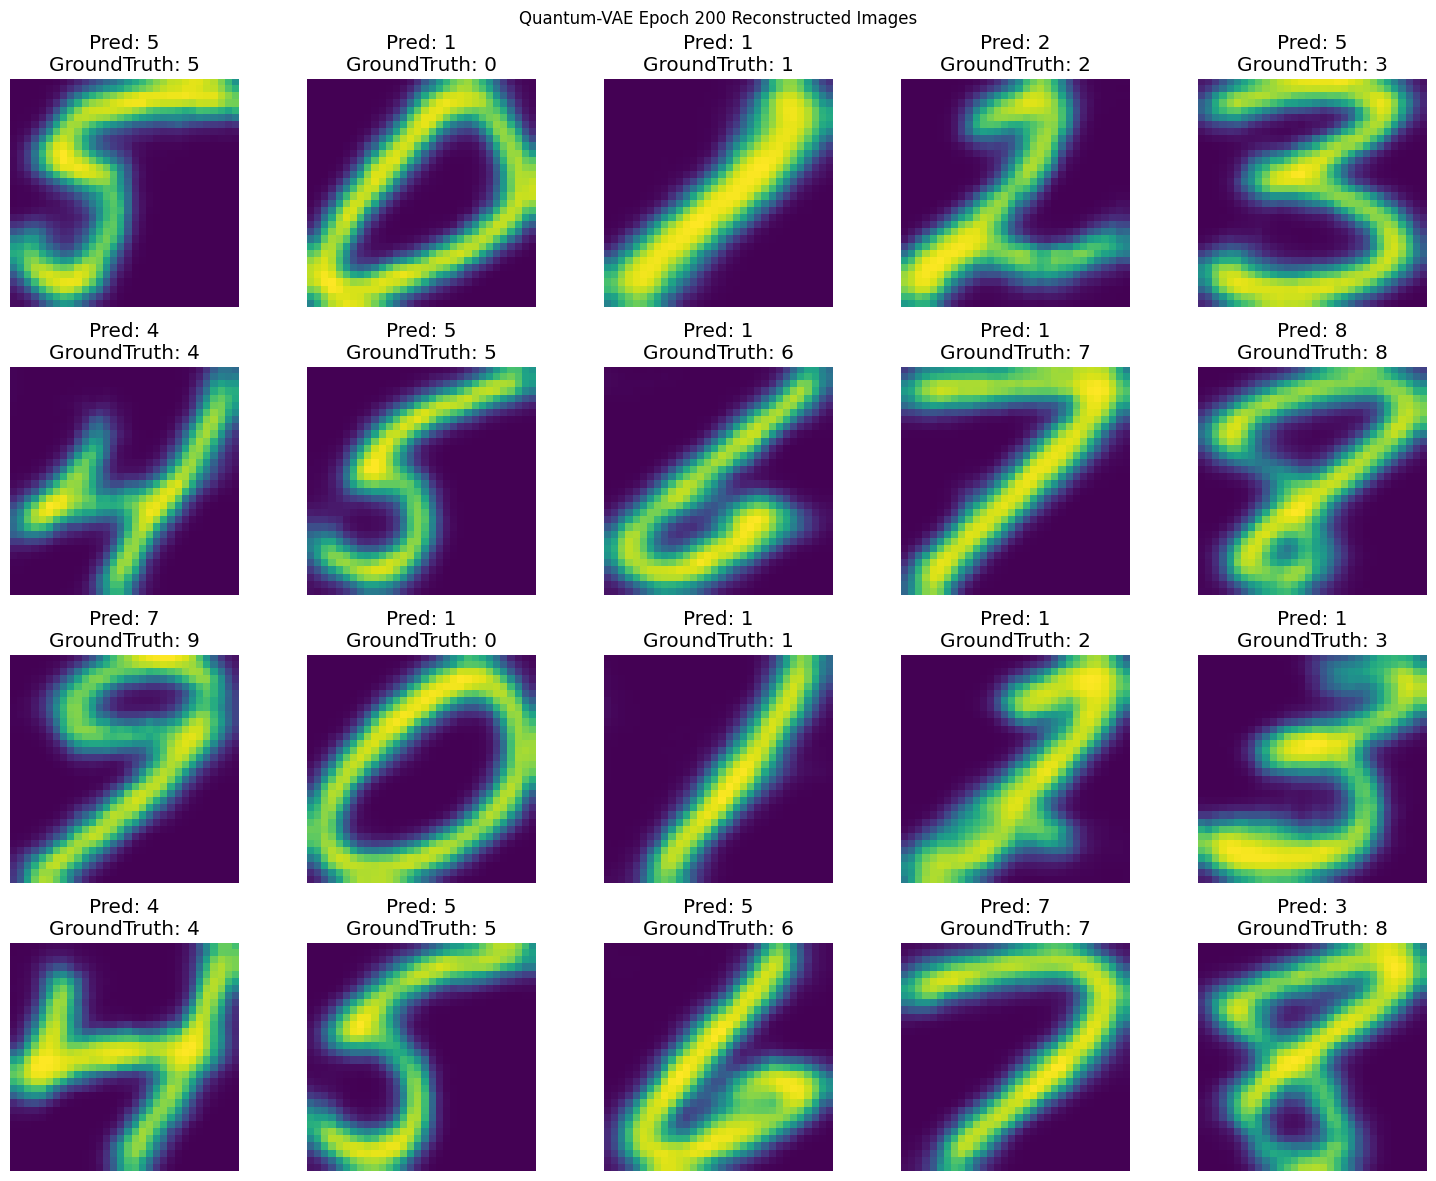

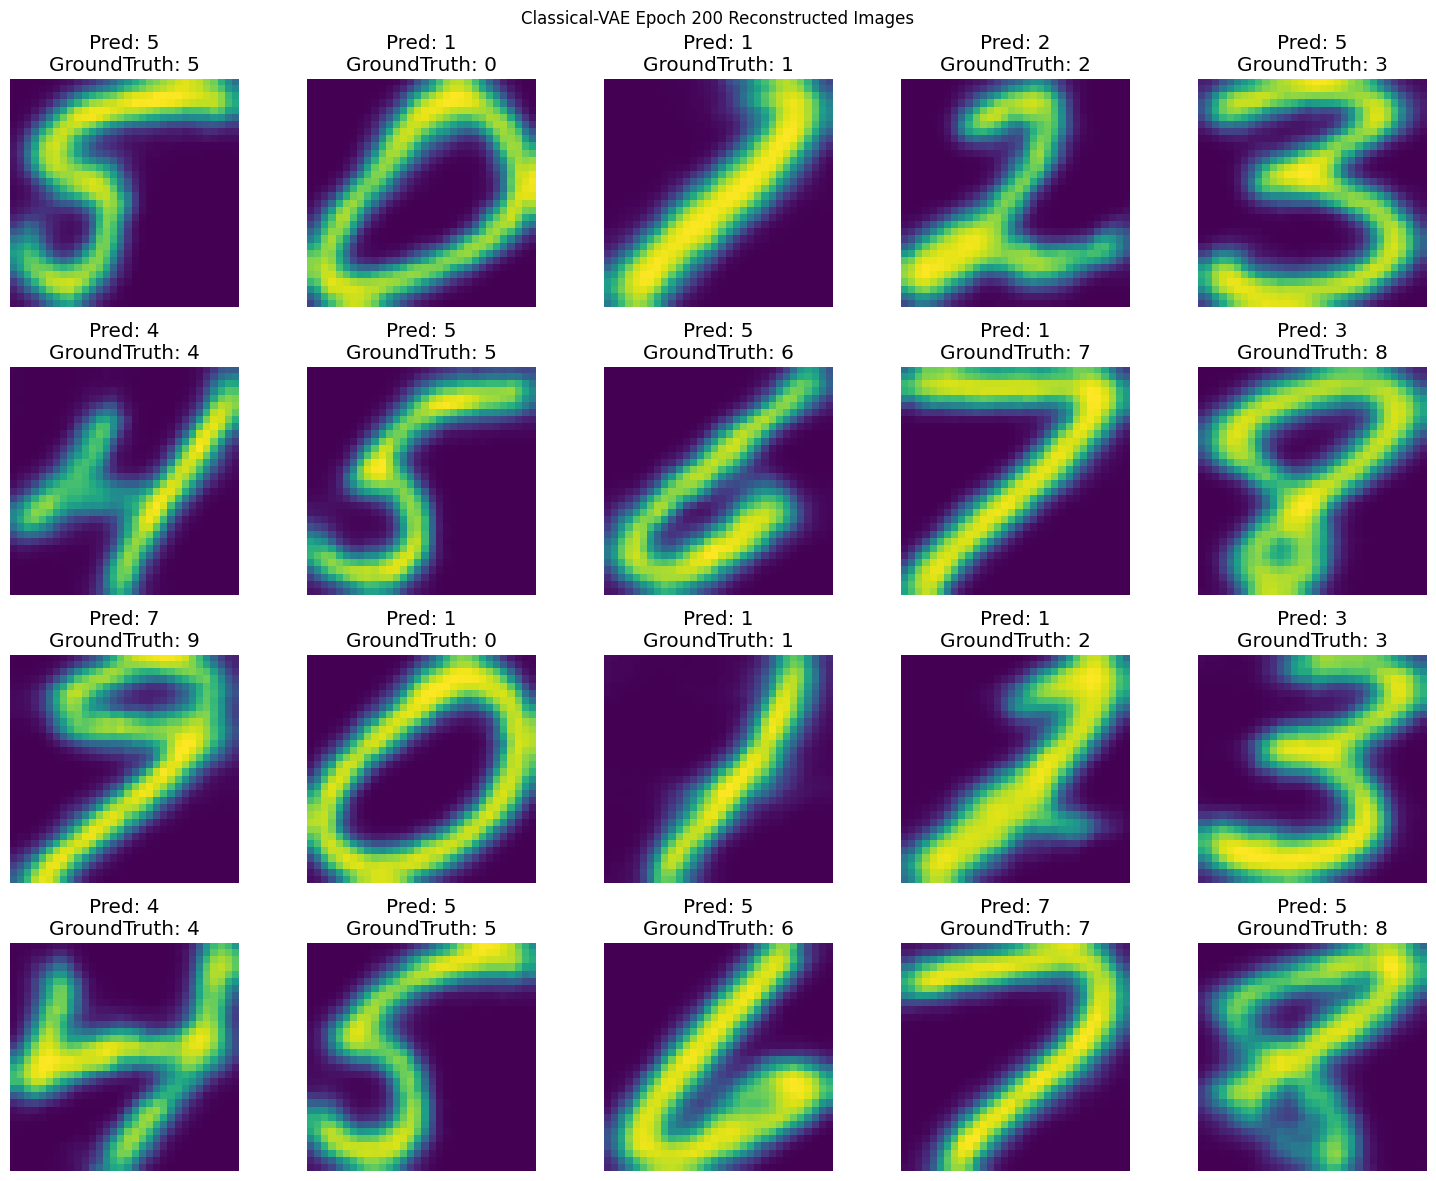

Training Complete


In [66]:
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")

    # Training step
    (q_train_loss_epoch, q_train_mse_epoch,c_train_loss_epoch,c_train_mse_epoch) = train(
        q_VAE=q_VAE,
        c_VAE=c_VAE,
        dataloader=trainloader,
        device=device,
        q_optimizer=q_optimizer,
        c_optimizer=c_optimizer,
        criterion=criterion,
        batch_size=batch_size
    )
    
    # Validation step
    (q_valid_loss_epoch,
     q_val_mse_epoch,  # MSE for Q-VAE
     q_reconstructed_images,
     q_images_with_random_noise,
     q_fid_latent_space_epoch,
     q_fid_random_noise_epoch,
     q_accuracy_epoch,
     c_valid_loss_epoch,
     c_val_mse_epoch,  # MSE for C-VAE
     c_reconstructed_images,
     c_images_with_random_noise,
     c_fid_latent_space_epoch,
     c_fid_random_noise_epoch,
     c_accuracy_epoch,
     labels,
     c_predicted_labels,
     q_predicted_labels) = validate(
        q_VAE=q_VAE,
        c_VAE=c_VAE,
        dataloader=testloader,
        device=device,
        criterion=criterion,
        batch_size=batch_size,
        Classifier=Classifier
    )
    
    # Store metrics
    q_train_loss.append(q_train_loss_epoch)
    c_train_loss.append(c_train_loss_epoch)
    q_valid_loss.append(q_valid_loss_epoch)
    c_valid_loss.append(c_valid_loss_epoch)
    q_fid_latent_space.append(q_fid_latent_space_epoch)
    c_fid_latent_space.append(c_fid_latent_space_epoch)
    q_fid_random_noise.append(q_fid_random_noise_epoch)
    c_fid_random_noise.append(c_fid_random_noise_epoch)
    q_accuracy.append(q_accuracy_epoch)
    c_accuracy.append(c_accuracy_epoch)
    
    # Save images
    save_reconstructed_images(images=q_reconstructed_images, 
                              epoch=epoch+1, 
                              random_noise=False,
                              q_processing=True)
    save_reconstructed_images(images=q_images_with_random_noise, 
                              epoch=epoch+1, 
                              random_noise=True,
                              q_processing=True)
    save_reconstructed_images(images=c_reconstructed_images, 
                              epoch=epoch+1, 
                              random_noise=False,
                              q_processing=False)
    save_reconstructed_images(images=c_images_with_random_noise, 
                              epoch=epoch+1, 
                              random_noise=True,
                              q_processing=False)
    
    # Create and store image grids
    q_image_grid = make_grid(q_reconstructed_images.detach().cpu())
    q_grid_images.append(q_image_grid)
    
    c_image_grid = make_grid(c_reconstructed_images.detach().cpu())
    c_grid_images.append(c_image_grid)
    
    # Print metrics
    print(f"Training Loss using Q VAE: {q_train_loss_epoch:.4f}")
    print(f"Training Loss using C VAE: {c_train_loss_epoch:.4f}")
    print(f"Validation Loss using Q VAE: {q_valid_loss_epoch:.4f}")
    print(f"Validation Loss using C VAE: {c_valid_loss_epoch:.4f}")
    print(f"Validation MSE using Q VAE: {q_val_mse_epoch:.4f}")
    print(f"Validation MSE using C VAE: {c_val_mse_epoch:.4f}")
    print(f"FID Score with Latent Space using Q VAE: {q_fid_latent_space_epoch:.4f}")
    print(f"FID Score with Latent Space using C VAE: {c_fid_latent_space_epoch:.4f}")  
    print(f"FID Score with Random Noise using Q VAE: {q_fid_random_noise_epoch:.4f}")
    print(f"FID Score with Random Noise using C VAE: {c_fid_random_noise_epoch:.4f}")  
    print(f"Classification Accuracy for Q VAE: {q_accuracy_epoch:.2f}%")
    print(f"Classification Accuracy for C VAE: {c_accuracy_epoch:.2f}%")

# Optional: Plot images after training is complete
plot_images(q_reconstructed_images, q_predicted_labels, labels, f'Quantum-VAE Epoch {epoch+1} Reconstructed Images')
plot_images(c_reconstructed_images, c_predicted_labels, labels, f'Classical-VAE Epoch {epoch+1} Reconstructed Images')

print("Training Complete")

In [84]:
def save_mse_plot(q_train_mse, q_valid_mse, c_train_mse, c_valid_mse):
    plt.figure(figsize = (10, 7))
    plt.plot(q_train_mse,color = 'orange', label='Q-VAE Training MSE')
    plt.plot(q_valid_mse,color = 'yellow', label='Q-VAE Validation MSE')
    plt.plot(c_train_mse,color = 'red', label='C-VAE Training MSE')
    plt.plot(c_valid_mse,color = 'blue', label='C-VAE Validation MSE')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend()
    plt.title('Training and Validation MSE')
    plt.savefig('mse_plot.png')
    plt.close()

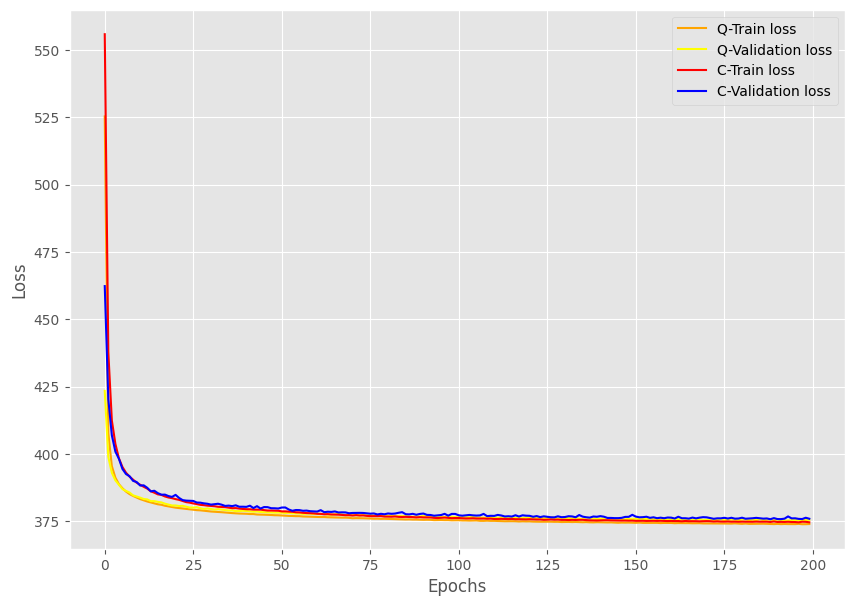

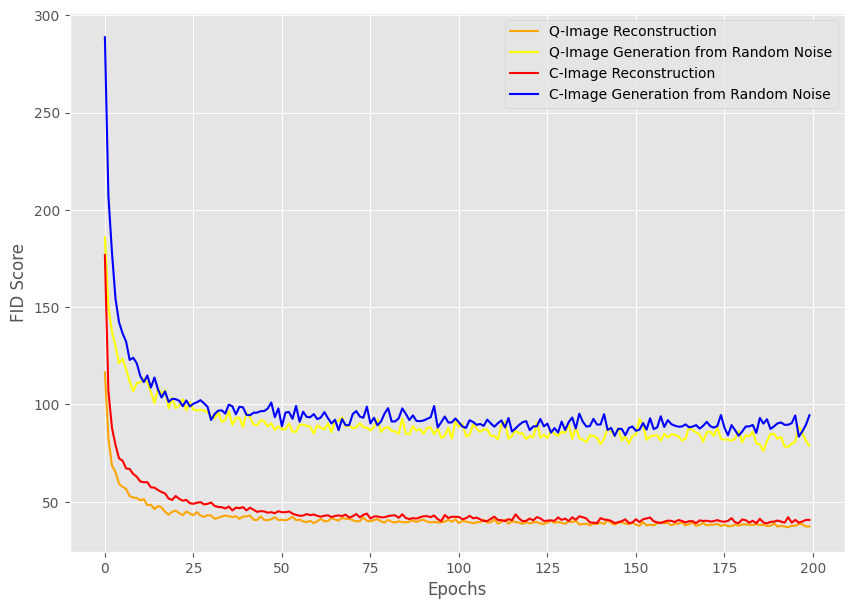

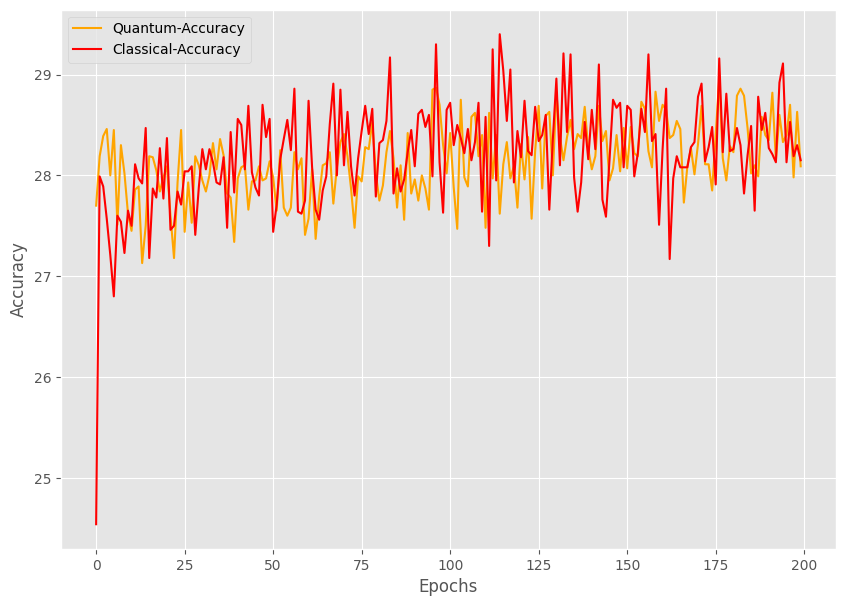

In [92]:
image_to_vid(q_grid_images, q_processing=True)
image_to_vid(c_grid_images, q_processing=False)
save_loss_plot(q_train_loss = q_train_loss,
               q_valid_loss = q_valid_loss,
               c_train_loss = c_train_loss,
               c_valid_loss = c_valid_loss)
save_fid_plot(q_fid_score_latent_space = q_fid_latent_space,
              q_fid_score_random_noise = q_fid_random_noise,
              c_fid_score_latent_space = c_fid_latent_space,
              c_fid_score_random_noise = c_fid_random_noise)
save_accuracy_plot(q_accuracy = q_accuracy,
                   c_accuracy = c_accuracy)
save_mse_plot(q_train_mse=q_train_mse_epoch,
              q_valid_mse=q_val_mse_epoch,
              c_train_mse=c_train_mse_epoch,
              c_valid_mse=c_val_mse_epoch)

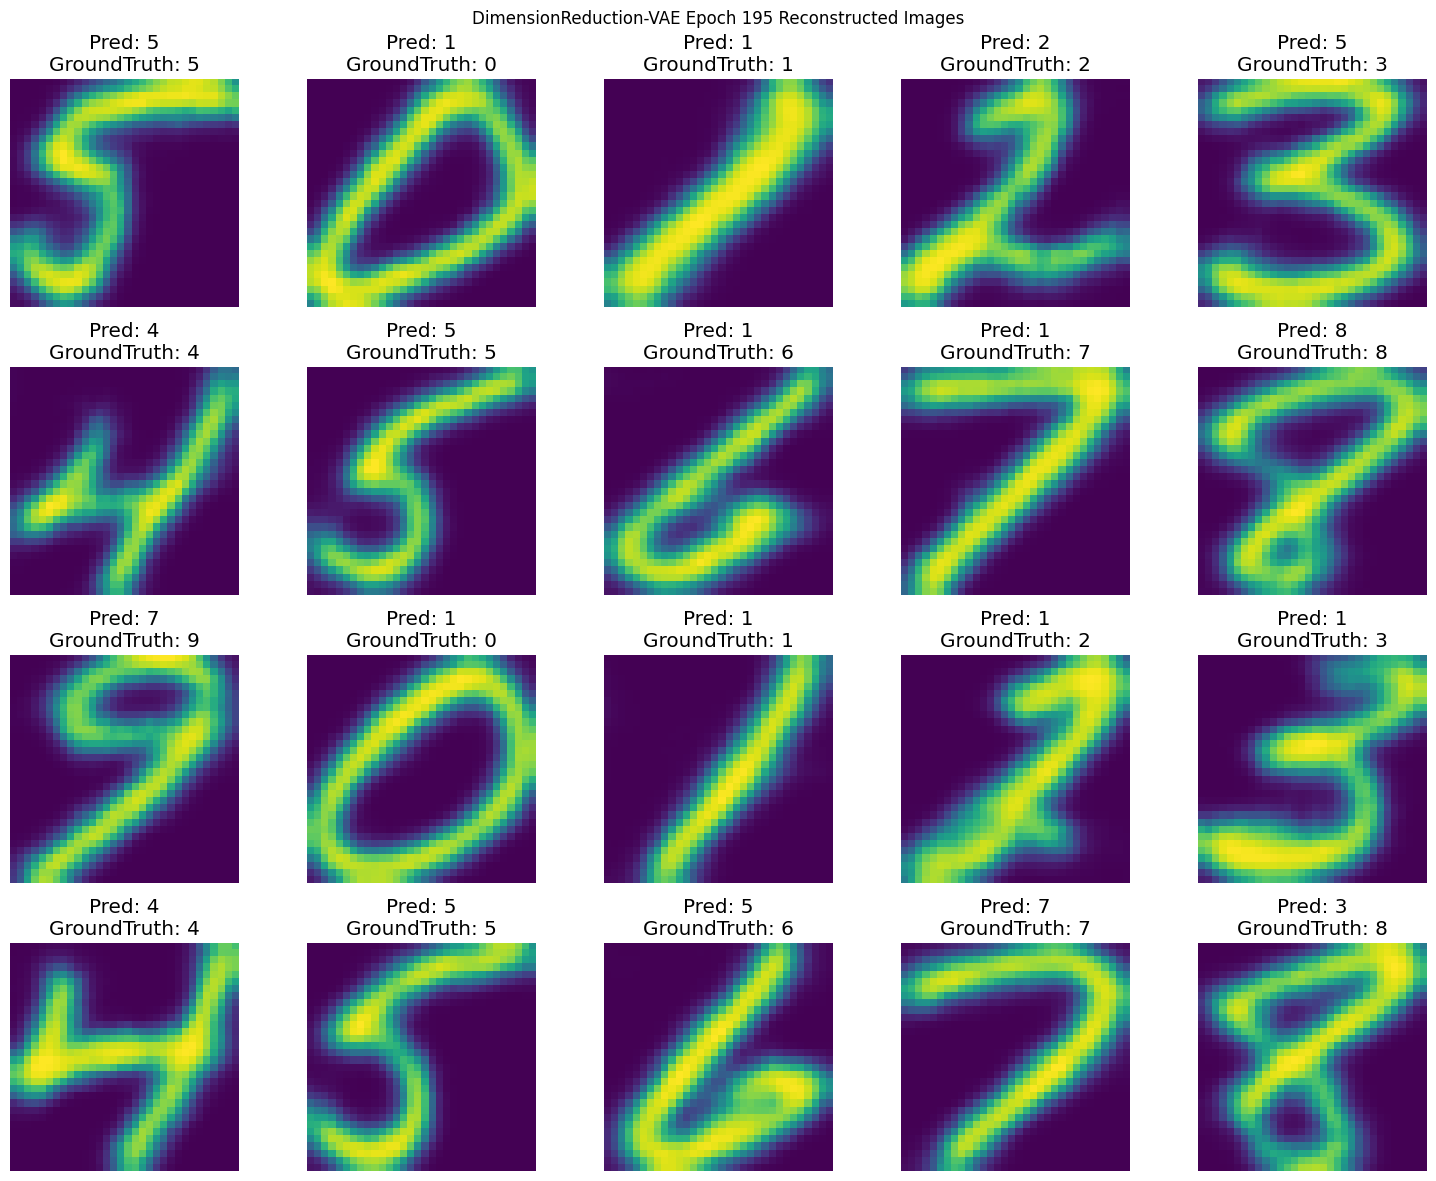

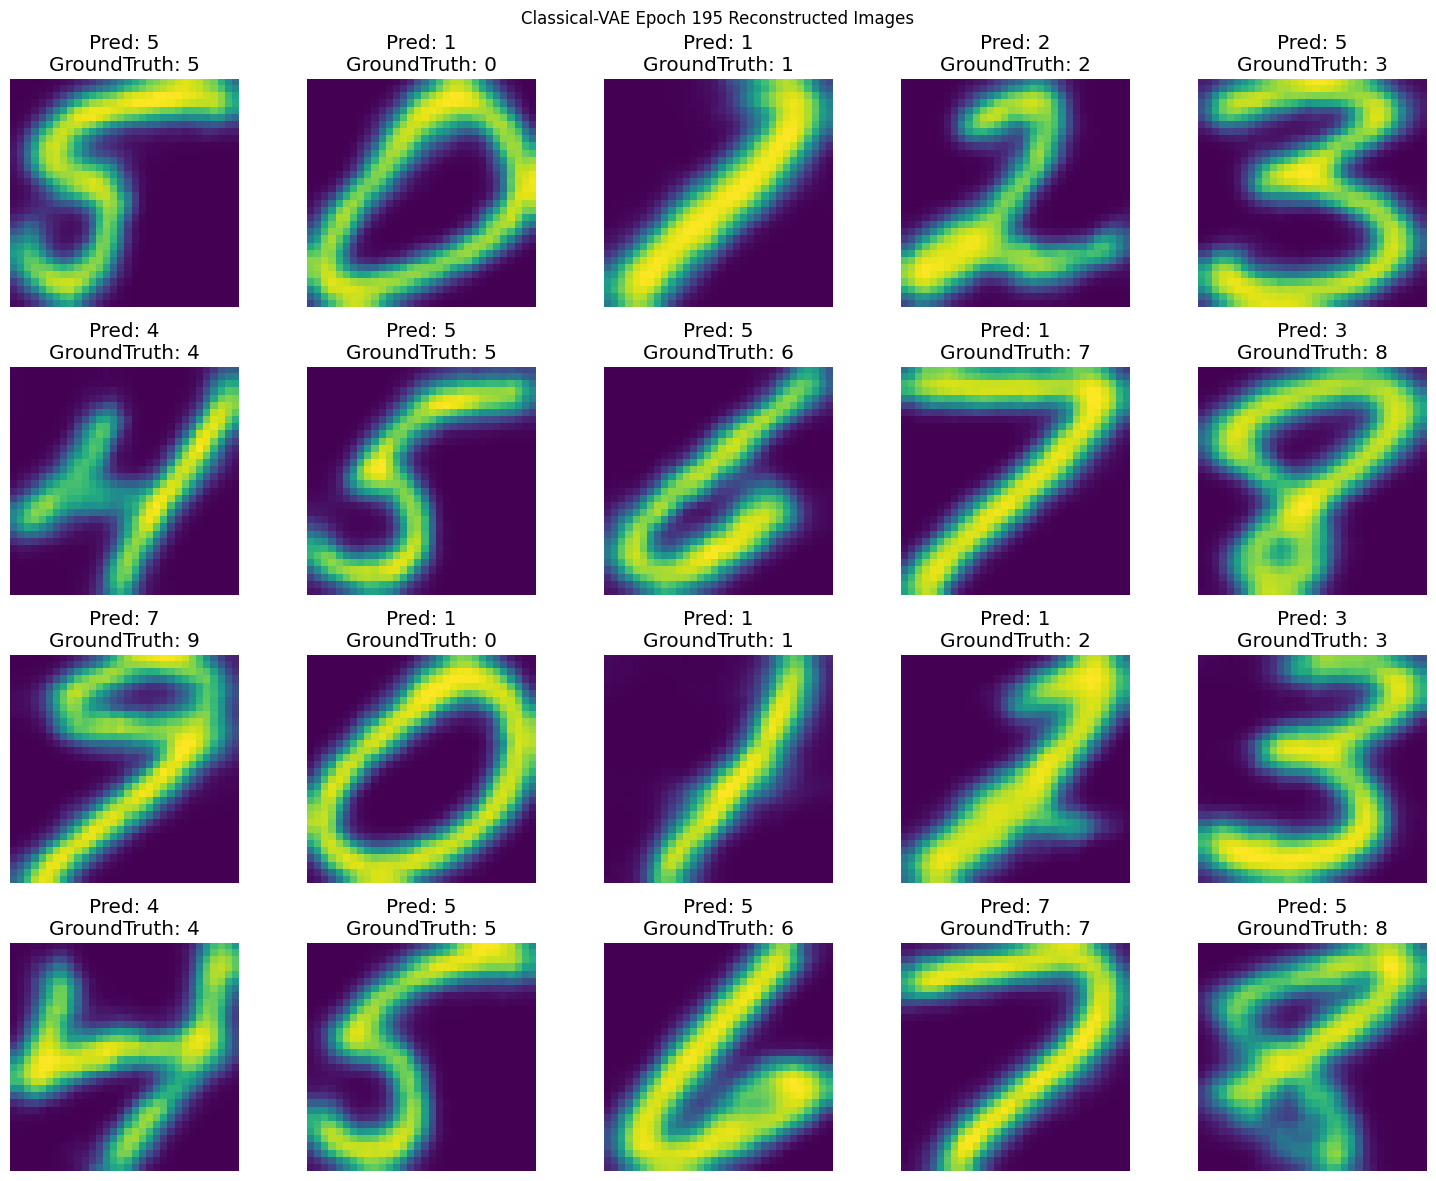

In [69]:
plot_images(q_reconstructed_images, q_predicted_labels, labels, f'DimensionReduction-VAE Epoch {epoch-4} Reconstructed Images')
plot_images(c_reconstructed_images,c_predicted_labels, labels, f'Classical-VAE Epoch {epoch-4} Reconstructed Images')

In [70]:
import torch
import matplotlib.pyplot as plt

# Define a mapping from numeric labels to string labels for CIFAR-10
LABEL_MAPPING = {
    0: "0",
    1: "1",
    2: "2",
    3: "3",
    4: "4",
    5: "5",
    6: "6",
    7: "7",
    8: "8",
    9: "9"
}


def plot_images(images, predicted_labels, real_labels, title, num_images=20):
    # Ensure we're plotting at most num_images
    num_images = min(num_images, images.size(0))

    plt.figure(figsize=(15, 12))
    for idx in range(num_images):
        plt.subplot(4, 5, idx + 1)  # Adjust rows and columns for layout
        
        # Convert image to grayscale
        if images[idx].shape[0] == 3:  # Check if image is in RGB format
            grayscale_image = torch.mean(images[idx], dim=0, keepdim=True)
        else:  # Image is already in grayscale format
            grayscale_image = images[idx]
        
        plt.imshow(grayscale_image.cpu().squeeze().numpy(), cmap='gray')  # Display grayscale image
        
        pred_label_str = LABEL_MAPPING[predicted_labels[idx].item()]
        real_label_str = LABEL_MAPPING[real_labels[idx].item()]
    
        plt.title(f'Pred: {pred_label_str}\nGroundTruth:{real_label_str}')  # Display predicted and real labels as the title
        plt.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

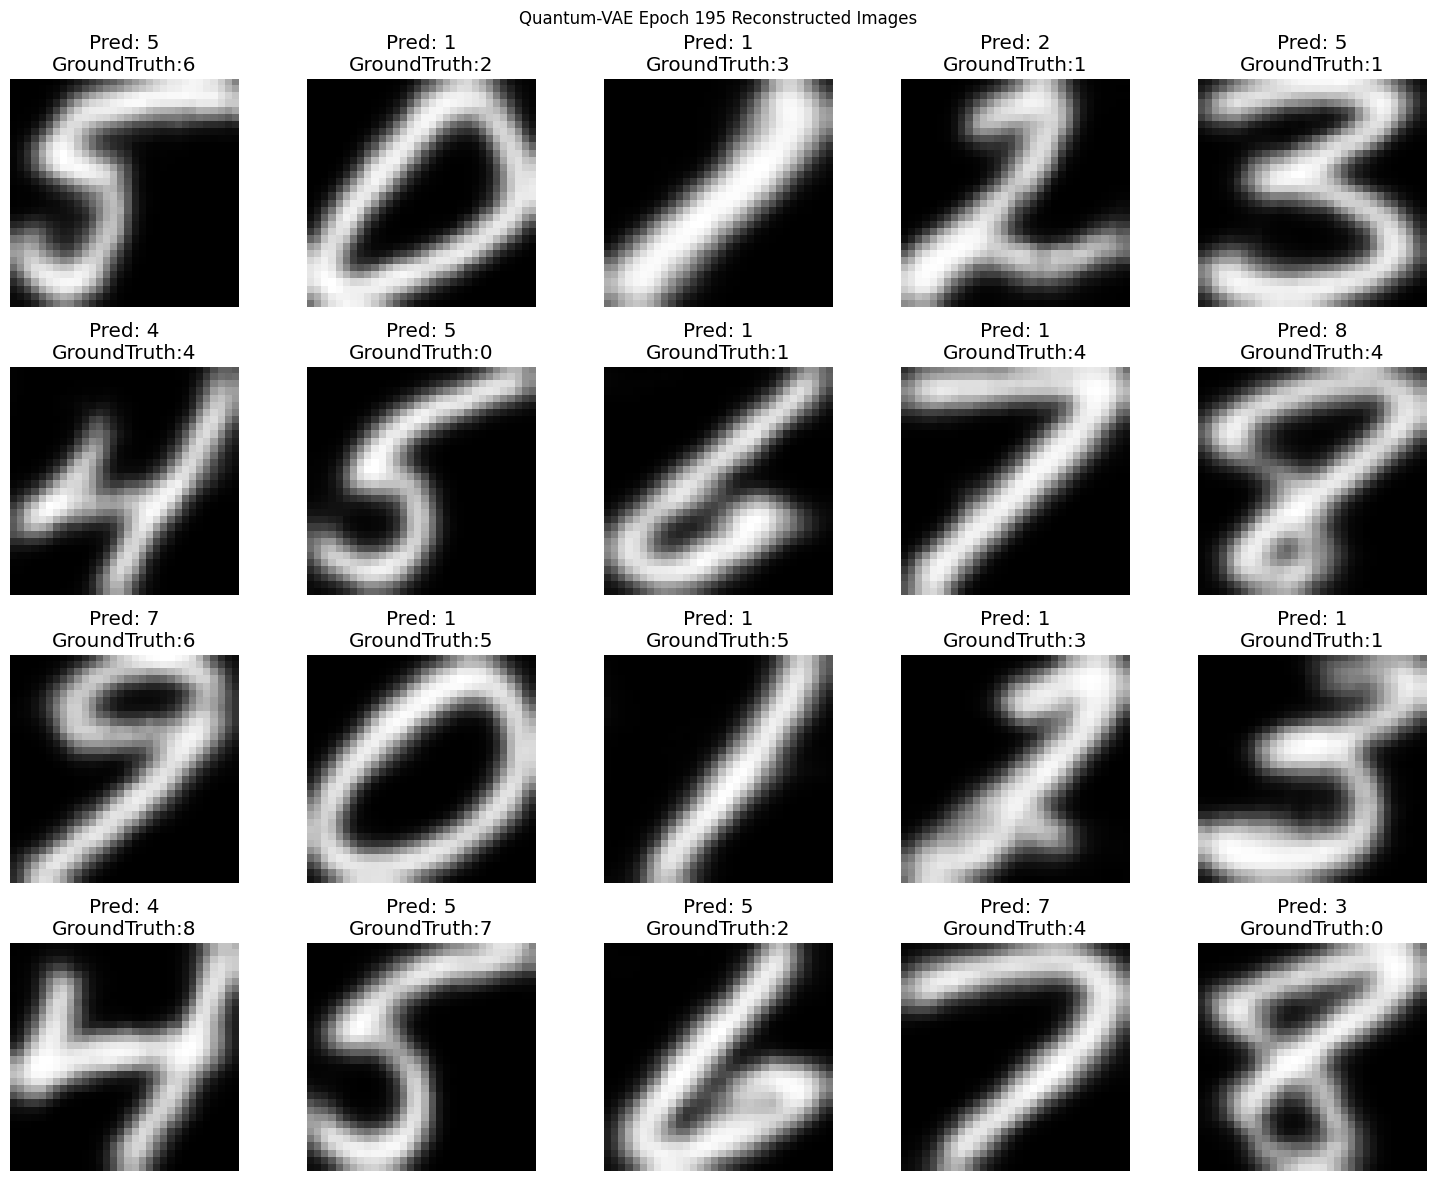

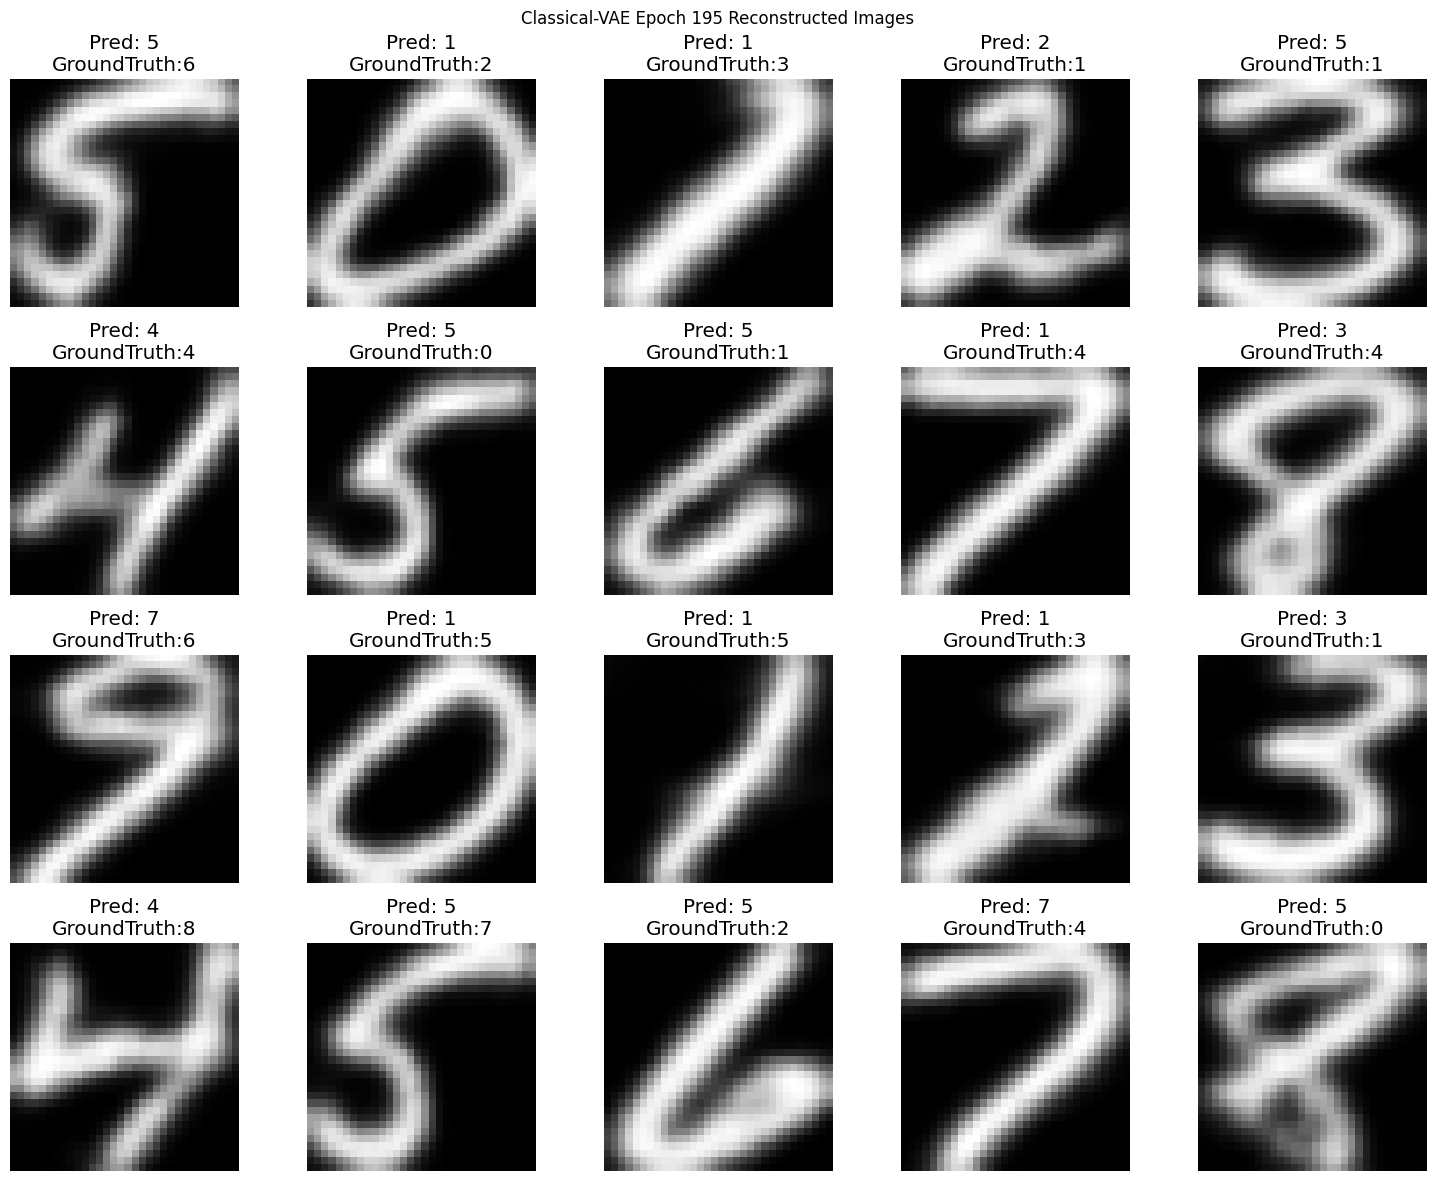

In [90]:
plot_images(q_reconstructed_images, q_predicted_labels, labels, f'Quantum-VAE Epoch {epoch-4} Reconstructed Images')
plot_images(c_reconstructed_images,c_predicted_labels, labels, f'Classical-VAE Epoch {epoch-4} Reconstructed Images')

In [72]:
q_image_grid = make_grid(q_reconstructed_images.detach().cpu())
q_grid_images.append(q_image_grid)
    
c_image_grid = make_grid(c_reconstructed_images.detach().cpu())
c_grid_images.append(c_image_grid)

Shape of Image for class 5: torch.Size([1, 28, 28])
Displaying the first image with label 5:


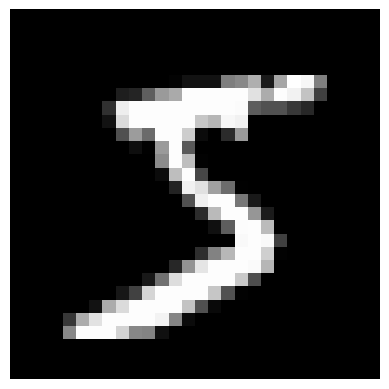

Shape of Image for class 0: torch.Size([1, 28, 28])
Displaying the first image with label 0:


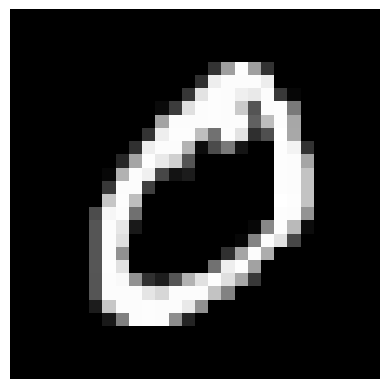

Shape of Image for class 4: torch.Size([1, 28, 28])
Displaying the first image with label 4:


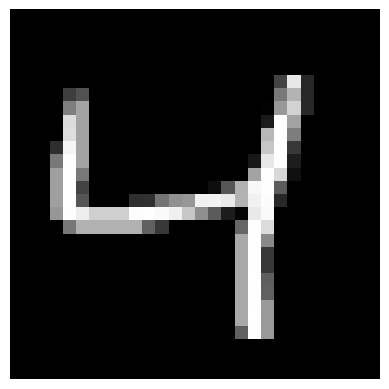

Shape of Image for class 1: torch.Size([1, 28, 28])
Displaying the first image with label 1:


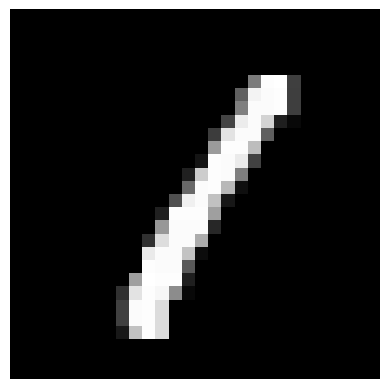

Shape of Image for class 9: torch.Size([1, 28, 28])
Displaying the first image with label 9:


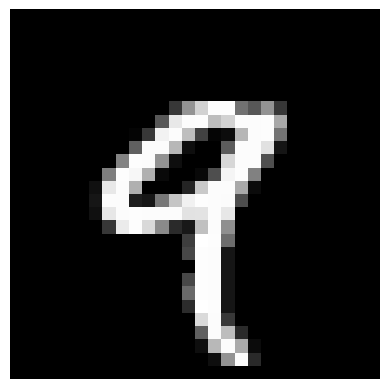

Shape of Image for class 2: torch.Size([1, 28, 28])
Displaying the first image with label 2:


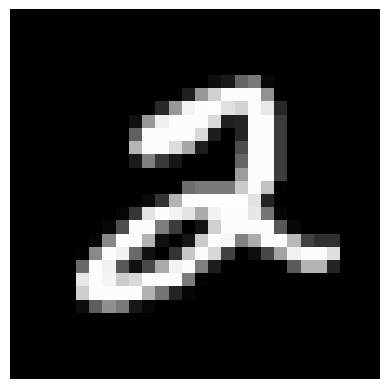

Shape of Image for class 3: torch.Size([1, 28, 28])
Displaying the first image with label 3:


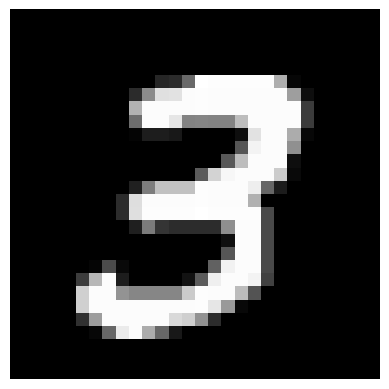

Shape of Image for class 6: torch.Size([1, 28, 28])
Displaying the first image with label 6:


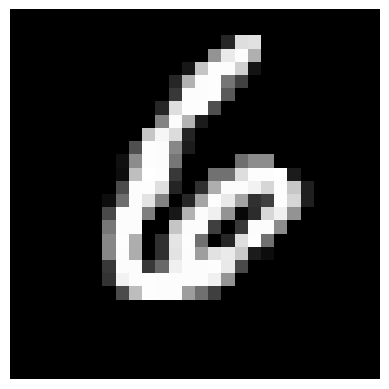

Shape of Image for class 7: torch.Size([1, 28, 28])
Displaying the first image with label 7:


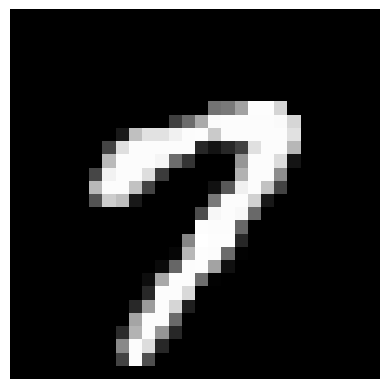

Shape of Image for class 8: torch.Size([1, 28, 28])
Displaying the first image with label 8:


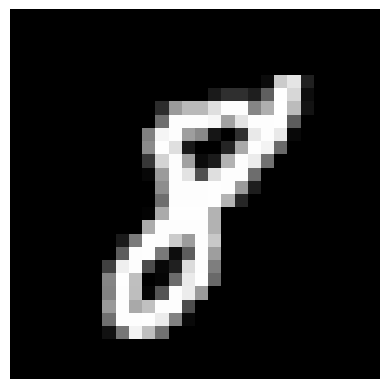

In [73]:
import matplotlib.pyplot as plt
import torchvision
import torch
import torchvision.transforms as transforms
import numpy as np

# Define a simple transform to convert PIL Image to Tensor
rtransform = transforms.ToTensor()

# Load the USPS dataset with ToTensor transform
rtrainset = torchvision.datasets.MNIST(root='Input', train=True, download=True, transform=rtransform)

# Function to display an image
def imshow(img):
    npimg = img.numpy()  # Convert tensor to NumPy array
    plt.imshow(npimg[0], cmap='gray')  # Display grayscale image
    plt.axis('off')  # Hide axes
    plt.show()

# Create a DataLoader with shuffle=False to maintain order
rtrainloader = torch.utils.data.DataLoader(rtrainset, batch_size=5, shuffle=False)

# Set to track classes that have already been displayed
displayed_classes = set()

# Loop through the DataLoader
for rimages, rlabels in rtrainloader:
    for i in range(len(rlabels)):
        llabel = rlabels[i].item()  # Get class label as an integer
        if llabel not in displayed_classes:
            print(f"Shape of Image for class {llabel}: {rimages[i].shape}")
            print(f"Displaying the first image with label {llabel}:")
            imshow(rimages[i])  # Display the image
            displayed_classes.add(llabel)  # Mark class as displayed
        # Stop if all classes have been displayed
        if len(displayed_classes) == 10:  # Assuming there are 10 classes in USPS
            break
    if len(displayed_classes) == 10:
        break


Shape of Image for class 5: torch.Size([1, 16, 16])
Displaying the first image with label 5:


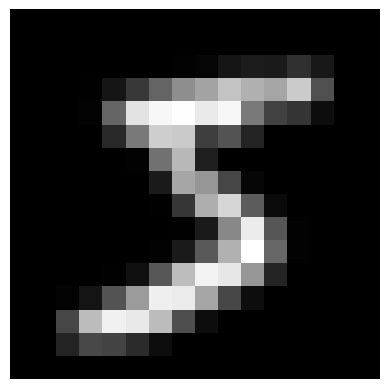

Shape of Image for class 0: torch.Size([1, 16, 16])
Displaying the first image with label 0:


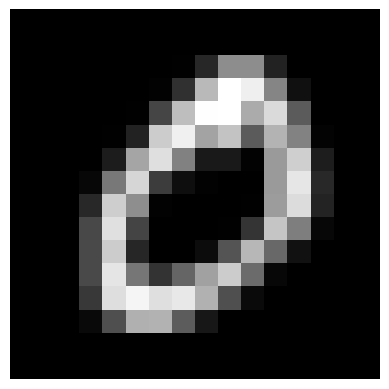

Shape of Image for class 4: torch.Size([1, 16, 16])
Displaying the first image with label 4:


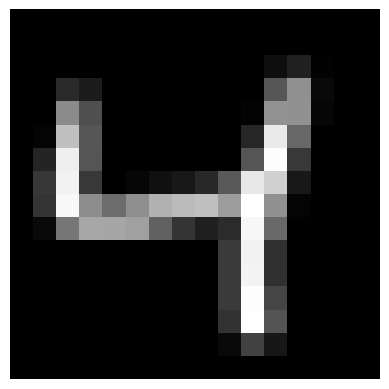

Shape of Image for class 1: torch.Size([1, 16, 16])
Displaying the first image with label 1:


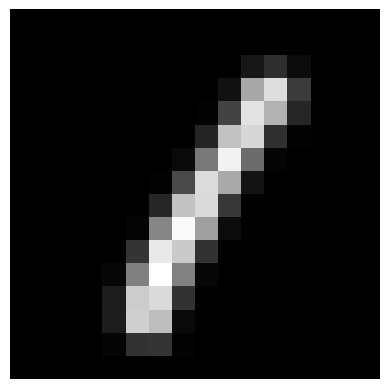

Shape of Image for class 9: torch.Size([1, 16, 16])
Displaying the first image with label 9:


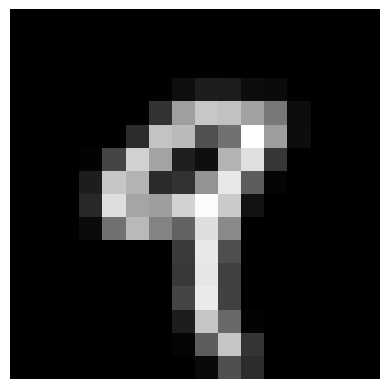

Shape of Image for class 2: torch.Size([1, 16, 16])
Displaying the first image with label 2:


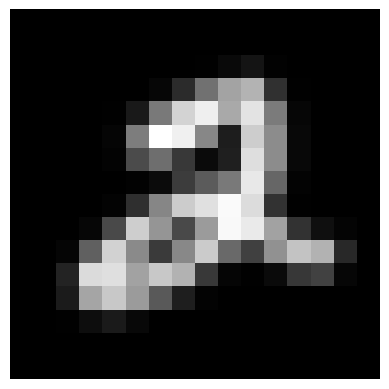

Shape of Image for class 3: torch.Size([1, 16, 16])
Displaying the first image with label 3:


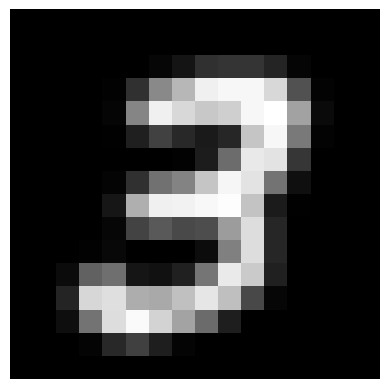

Shape of Image for class 6: torch.Size([1, 16, 16])
Displaying the first image with label 6:


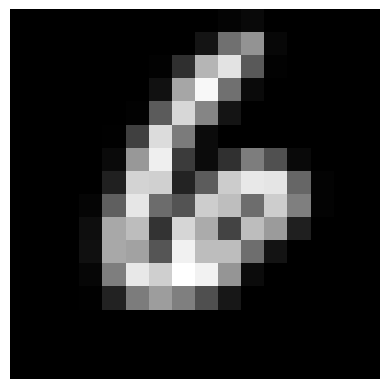

Shape of Image for class 7: torch.Size([1, 16, 16])
Displaying the first image with label 7:


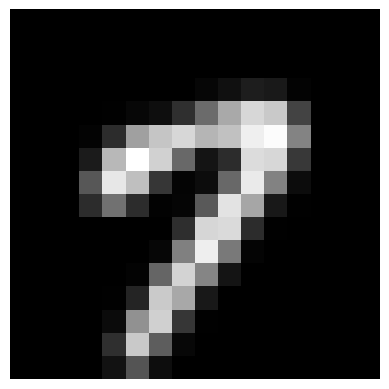

Shape of Image for class 8: torch.Size([1, 16, 16])
Displaying the first image with label 8:


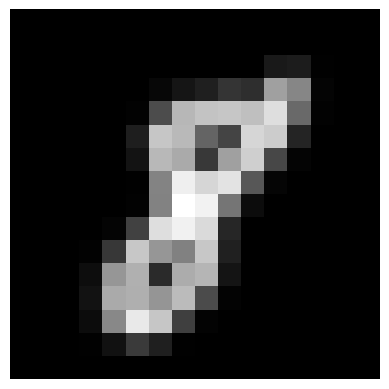

In [74]:
import matplotlib.pyplot as plt
import torchvision
import torch
import torchvision.transforms as transforms
import numpy as np

# Define a simple transform to convert PIL Image to Tensor
rtransform = transforms.Compose([transforms.Resize((16, 16)),
                                transforms.ToTensor()])

# Load the USPS dataset with ToTensor transform
rtrainset = torchvision.datasets.MNIST(root='Input', train=True, download=True, transform=rtransform)

# Function to display an image
def imshow(img):
    npimg = img.numpy()  # Convert tensor to NumPy array
    plt.imshow(npimg[0], cmap='gray')  # Display grayscale image
    plt.axis('off')  # Hide axes
    plt.show()

# Create a DataLoader with shuffle=False to maintain order
rtrainloader = torch.utils.data.DataLoader(rtrainset, batch_size=5, shuffle=False)

# Set to track classes that have already been displayed
displayed_classes = set()

# Loop through the DataLoader
for rimages, rlabels in rtrainloader:
    for i in range(len(rlabels)):
        rlabel = rlabels[i].item()  # Get class label as an integer
        if rlabel not in displayed_classes:
            print(f"Shape of Image for class {rlabel}: {rimages[i].shape}")
            print(f"Displaying the first image with label {rlabel}:")
            imshow(rimages[i])  # Display the image
            displayed_classes.add(rlabel)  # Mark class as displayed
        # Stop if all classes have been displayed
        if len(displayed_classes) == 10:  # Assuming there are 10 classes in USPS
            break
    if len(displayed_classes) == 10:
        break


Shape of Input Real Image after 32x32 for class 9: torch.Size([1, 32, 32])
Displaying the first image with label tensor([9, 5, 8, 3, 6, 4, 7, 7, 2, 3, 8, 0, 6, 2, 0, 5, 9, 3, 0, 3, 4, 9, 7, 7,
        1, 9, 7, 1, 5, 2, 7, 6, 8, 3, 6, 8, 4, 4, 1, 1, 3, 0, 7, 6, 6, 2, 7, 3,
        9, 1, 9, 8, 6, 0, 8, 3, 1, 4, 6, 0, 7, 6, 9, 3, 8, 4, 1, 3, 2, 8, 4, 4,
        1, 2, 8, 0, 6, 2, 7, 0, 4, 3, 5, 1, 3, 4, 7, 5, 1, 8, 4, 4, 3, 8, 2, 1,
        7, 1, 7, 8, 8, 9, 7, 0, 0, 0, 6, 0, 1, 1, 5, 8, 4, 8, 9, 3, 2, 9, 5, 2,
        8, 4, 8, 3, 6, 8, 6, 4, 3, 2, 8, 8, 4, 4, 2, 9, 8, 6, 1, 5, 9, 6, 7, 0,
        2, 3, 0, 3, 3, 3, 2, 1, 8, 4, 8, 0, 2, 4, 2, 7, 1, 2, 8, 3, 7, 2, 1, 3,
        8, 0, 1, 8, 2, 5, 1, 8, 4, 2, 9, 8, 6, 3, 4, 3, 5, 4, 1, 6, 2, 5, 5, 3,
        8, 2, 6, 5, 7, 9, 1, 9, 3, 3, 5, 8, 3, 6, 4, 3, 0, 8, 9, 7, 0, 7, 2, 4,
        7, 8, 7, 7, 1, 2, 0, 2, 1, 7, 2, 0, 1, 1, 1, 0, 3, 0, 0, 4, 8, 1, 3, 2,
        3, 4, 1, 0, 6, 4, 3, 1, 3, 2, 7, 2, 4, 0, 6, 2, 6, 4, 0, 6, 7, 8, 8, 6,
       

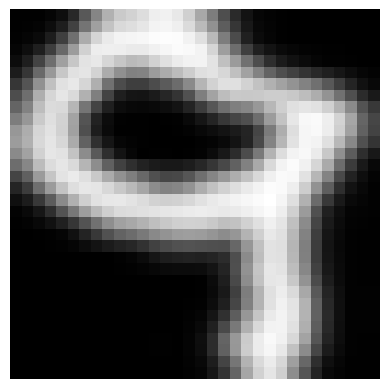

Shape of Input Real Image after 32x32 for class 5: torch.Size([1, 32, 32])
Displaying the first image with label tensor([9, 5, 8, 3, 6, 4, 7, 7, 2, 3, 8, 0, 6, 2, 0, 5, 9, 3, 0, 3, 4, 9, 7, 7,
        1, 9, 7, 1, 5, 2, 7, 6, 8, 3, 6, 8, 4, 4, 1, 1, 3, 0, 7, 6, 6, 2, 7, 3,
        9, 1, 9, 8, 6, 0, 8, 3, 1, 4, 6, 0, 7, 6, 9, 3, 8, 4, 1, 3, 2, 8, 4, 4,
        1, 2, 8, 0, 6, 2, 7, 0, 4, 3, 5, 1, 3, 4, 7, 5, 1, 8, 4, 4, 3, 8, 2, 1,
        7, 1, 7, 8, 8, 9, 7, 0, 0, 0, 6, 0, 1, 1, 5, 8, 4, 8, 9, 3, 2, 9, 5, 2,
        8, 4, 8, 3, 6, 8, 6, 4, 3, 2, 8, 8, 4, 4, 2, 9, 8, 6, 1, 5, 9, 6, 7, 0,
        2, 3, 0, 3, 3, 3, 2, 1, 8, 4, 8, 0, 2, 4, 2, 7, 1, 2, 8, 3, 7, 2, 1, 3,
        8, 0, 1, 8, 2, 5, 1, 8, 4, 2, 9, 8, 6, 3, 4, 3, 5, 4, 1, 6, 2, 5, 5, 3,
        8, 2, 6, 5, 7, 9, 1, 9, 3, 3, 5, 8, 3, 6, 4, 3, 0, 8, 9, 7, 0, 7, 2, 4,
        7, 8, 7, 7, 1, 2, 0, 2, 1, 7, 2, 0, 1, 1, 1, 0, 3, 0, 0, 4, 8, 1, 3, 2,
        3, 4, 1, 0, 6, 4, 3, 1, 3, 2, 7, 2, 4, 0, 6, 2, 6, 4, 0, 6, 7, 8, 8, 6,
       

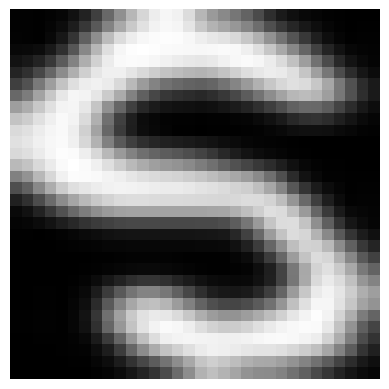

Shape of Input Real Image after 32x32 for class 8: torch.Size([1, 32, 32])
Displaying the first image with label tensor([9, 5, 8, 3, 6, 4, 7, 7, 2, 3, 8, 0, 6, 2, 0, 5, 9, 3, 0, 3, 4, 9, 7, 7,
        1, 9, 7, 1, 5, 2, 7, 6, 8, 3, 6, 8, 4, 4, 1, 1, 3, 0, 7, 6, 6, 2, 7, 3,
        9, 1, 9, 8, 6, 0, 8, 3, 1, 4, 6, 0, 7, 6, 9, 3, 8, 4, 1, 3, 2, 8, 4, 4,
        1, 2, 8, 0, 6, 2, 7, 0, 4, 3, 5, 1, 3, 4, 7, 5, 1, 8, 4, 4, 3, 8, 2, 1,
        7, 1, 7, 8, 8, 9, 7, 0, 0, 0, 6, 0, 1, 1, 5, 8, 4, 8, 9, 3, 2, 9, 5, 2,
        8, 4, 8, 3, 6, 8, 6, 4, 3, 2, 8, 8, 4, 4, 2, 9, 8, 6, 1, 5, 9, 6, 7, 0,
        2, 3, 0, 3, 3, 3, 2, 1, 8, 4, 8, 0, 2, 4, 2, 7, 1, 2, 8, 3, 7, 2, 1, 3,
        8, 0, 1, 8, 2, 5, 1, 8, 4, 2, 9, 8, 6, 3, 4, 3, 5, 4, 1, 6, 2, 5, 5, 3,
        8, 2, 6, 5, 7, 9, 1, 9, 3, 3, 5, 8, 3, 6, 4, 3, 0, 8, 9, 7, 0, 7, 2, 4,
        7, 8, 7, 7, 1, 2, 0, 2, 1, 7, 2, 0, 1, 1, 1, 0, 3, 0, 0, 4, 8, 1, 3, 2,
        3, 4, 1, 0, 6, 4, 3, 1, 3, 2, 7, 2, 4, 0, 6, 2, 6, 4, 0, 6, 7, 8, 8, 6,
       

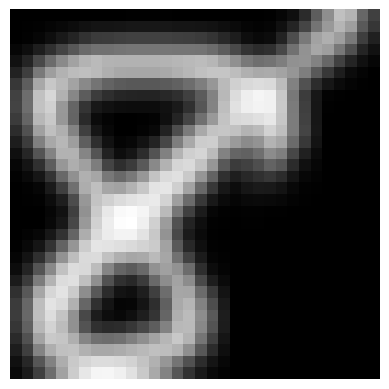

Shape of Input Real Image after 32x32 for class 3: torch.Size([1, 32, 32])
Displaying the first image with label tensor([9, 5, 8, 3, 6, 4, 7, 7, 2, 3, 8, 0, 6, 2, 0, 5, 9, 3, 0, 3, 4, 9, 7, 7,
        1, 9, 7, 1, 5, 2, 7, 6, 8, 3, 6, 8, 4, 4, 1, 1, 3, 0, 7, 6, 6, 2, 7, 3,
        9, 1, 9, 8, 6, 0, 8, 3, 1, 4, 6, 0, 7, 6, 9, 3, 8, 4, 1, 3, 2, 8, 4, 4,
        1, 2, 8, 0, 6, 2, 7, 0, 4, 3, 5, 1, 3, 4, 7, 5, 1, 8, 4, 4, 3, 8, 2, 1,
        7, 1, 7, 8, 8, 9, 7, 0, 0, 0, 6, 0, 1, 1, 5, 8, 4, 8, 9, 3, 2, 9, 5, 2,
        8, 4, 8, 3, 6, 8, 6, 4, 3, 2, 8, 8, 4, 4, 2, 9, 8, 6, 1, 5, 9, 6, 7, 0,
        2, 3, 0, 3, 3, 3, 2, 1, 8, 4, 8, 0, 2, 4, 2, 7, 1, 2, 8, 3, 7, 2, 1, 3,
        8, 0, 1, 8, 2, 5, 1, 8, 4, 2, 9, 8, 6, 3, 4, 3, 5, 4, 1, 6, 2, 5, 5, 3,
        8, 2, 6, 5, 7, 9, 1, 9, 3, 3, 5, 8, 3, 6, 4, 3, 0, 8, 9, 7, 0, 7, 2, 4,
        7, 8, 7, 7, 1, 2, 0, 2, 1, 7, 2, 0, 1, 1, 1, 0, 3, 0, 0, 4, 8, 1, 3, 2,
        3, 4, 1, 0, 6, 4, 3, 1, 3, 2, 7, 2, 4, 0, 6, 2, 6, 4, 0, 6, 7, 8, 8, 6,
       

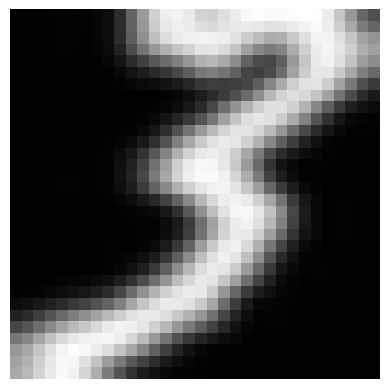

Shape of Input Real Image after 32x32 for class 6: torch.Size([1, 32, 32])
Displaying the first image with label tensor([9, 5, 8, 3, 6, 4, 7, 7, 2, 3, 8, 0, 6, 2, 0, 5, 9, 3, 0, 3, 4, 9, 7, 7,
        1, 9, 7, 1, 5, 2, 7, 6, 8, 3, 6, 8, 4, 4, 1, 1, 3, 0, 7, 6, 6, 2, 7, 3,
        9, 1, 9, 8, 6, 0, 8, 3, 1, 4, 6, 0, 7, 6, 9, 3, 8, 4, 1, 3, 2, 8, 4, 4,
        1, 2, 8, 0, 6, 2, 7, 0, 4, 3, 5, 1, 3, 4, 7, 5, 1, 8, 4, 4, 3, 8, 2, 1,
        7, 1, 7, 8, 8, 9, 7, 0, 0, 0, 6, 0, 1, 1, 5, 8, 4, 8, 9, 3, 2, 9, 5, 2,
        8, 4, 8, 3, 6, 8, 6, 4, 3, 2, 8, 8, 4, 4, 2, 9, 8, 6, 1, 5, 9, 6, 7, 0,
        2, 3, 0, 3, 3, 3, 2, 1, 8, 4, 8, 0, 2, 4, 2, 7, 1, 2, 8, 3, 7, 2, 1, 3,
        8, 0, 1, 8, 2, 5, 1, 8, 4, 2, 9, 8, 6, 3, 4, 3, 5, 4, 1, 6, 2, 5, 5, 3,
        8, 2, 6, 5, 7, 9, 1, 9, 3, 3, 5, 8, 3, 6, 4, 3, 0, 8, 9, 7, 0, 7, 2, 4,
        7, 8, 7, 7, 1, 2, 0, 2, 1, 7, 2, 0, 1, 1, 1, 0, 3, 0, 0, 4, 8, 1, 3, 2,
        3, 4, 1, 0, 6, 4, 3, 1, 3, 2, 7, 2, 4, 0, 6, 2, 6, 4, 0, 6, 7, 8, 8, 6,
       

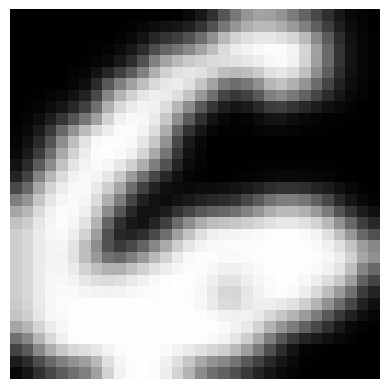

Shape of Input Real Image after 32x32 for class 4: torch.Size([1, 32, 32])
Displaying the first image with label tensor([9, 5, 8, 3, 6, 4, 7, 7, 2, 3, 8, 0, 6, 2, 0, 5, 9, 3, 0, 3, 4, 9, 7, 7,
        1, 9, 7, 1, 5, 2, 7, 6, 8, 3, 6, 8, 4, 4, 1, 1, 3, 0, 7, 6, 6, 2, 7, 3,
        9, 1, 9, 8, 6, 0, 8, 3, 1, 4, 6, 0, 7, 6, 9, 3, 8, 4, 1, 3, 2, 8, 4, 4,
        1, 2, 8, 0, 6, 2, 7, 0, 4, 3, 5, 1, 3, 4, 7, 5, 1, 8, 4, 4, 3, 8, 2, 1,
        7, 1, 7, 8, 8, 9, 7, 0, 0, 0, 6, 0, 1, 1, 5, 8, 4, 8, 9, 3, 2, 9, 5, 2,
        8, 4, 8, 3, 6, 8, 6, 4, 3, 2, 8, 8, 4, 4, 2, 9, 8, 6, 1, 5, 9, 6, 7, 0,
        2, 3, 0, 3, 3, 3, 2, 1, 8, 4, 8, 0, 2, 4, 2, 7, 1, 2, 8, 3, 7, 2, 1, 3,
        8, 0, 1, 8, 2, 5, 1, 8, 4, 2, 9, 8, 6, 3, 4, 3, 5, 4, 1, 6, 2, 5, 5, 3,
        8, 2, 6, 5, 7, 9, 1, 9, 3, 3, 5, 8, 3, 6, 4, 3, 0, 8, 9, 7, 0, 7, 2, 4,
        7, 8, 7, 7, 1, 2, 0, 2, 1, 7, 2, 0, 1, 1, 1, 0, 3, 0, 0, 4, 8, 1, 3, 2,
        3, 4, 1, 0, 6, 4, 3, 1, 3, 2, 7, 2, 4, 0, 6, 2, 6, 4, 0, 6, 7, 8, 8, 6,
       

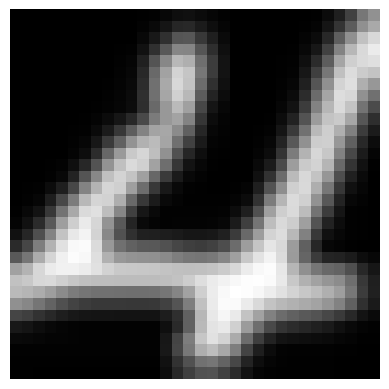

Shape of Input Real Image after 32x32 for class 7: torch.Size([1, 32, 32])
Displaying the first image with label tensor([9, 5, 8, 3, 6, 4, 7, 7, 2, 3, 8, 0, 6, 2, 0, 5, 9, 3, 0, 3, 4, 9, 7, 7,
        1, 9, 7, 1, 5, 2, 7, 6, 8, 3, 6, 8, 4, 4, 1, 1, 3, 0, 7, 6, 6, 2, 7, 3,
        9, 1, 9, 8, 6, 0, 8, 3, 1, 4, 6, 0, 7, 6, 9, 3, 8, 4, 1, 3, 2, 8, 4, 4,
        1, 2, 8, 0, 6, 2, 7, 0, 4, 3, 5, 1, 3, 4, 7, 5, 1, 8, 4, 4, 3, 8, 2, 1,
        7, 1, 7, 8, 8, 9, 7, 0, 0, 0, 6, 0, 1, 1, 5, 8, 4, 8, 9, 3, 2, 9, 5, 2,
        8, 4, 8, 3, 6, 8, 6, 4, 3, 2, 8, 8, 4, 4, 2, 9, 8, 6, 1, 5, 9, 6, 7, 0,
        2, 3, 0, 3, 3, 3, 2, 1, 8, 4, 8, 0, 2, 4, 2, 7, 1, 2, 8, 3, 7, 2, 1, 3,
        8, 0, 1, 8, 2, 5, 1, 8, 4, 2, 9, 8, 6, 3, 4, 3, 5, 4, 1, 6, 2, 5, 5, 3,
        8, 2, 6, 5, 7, 9, 1, 9, 3, 3, 5, 8, 3, 6, 4, 3, 0, 8, 9, 7, 0, 7, 2, 4,
        7, 8, 7, 7, 1, 2, 0, 2, 1, 7, 2, 0, 1, 1, 1, 0, 3, 0, 0, 4, 8, 1, 3, 2,
        3, 4, 1, 0, 6, 4, 3, 1, 3, 2, 7, 2, 4, 0, 6, 2, 6, 4, 0, 6, 7, 8, 8, 6,
       

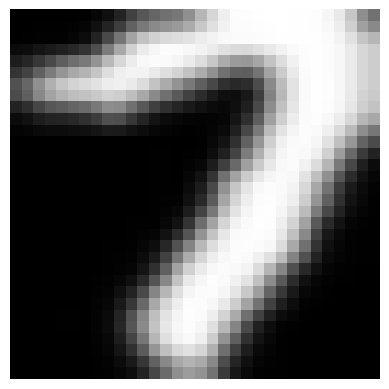

Shape of Input Real Image after 32x32 for class 2: torch.Size([1, 32, 32])
Displaying the first image with label tensor([9, 5, 8, 3, 6, 4, 7, 7, 2, 3, 8, 0, 6, 2, 0, 5, 9, 3, 0, 3, 4, 9, 7, 7,
        1, 9, 7, 1, 5, 2, 7, 6, 8, 3, 6, 8, 4, 4, 1, 1, 3, 0, 7, 6, 6, 2, 7, 3,
        9, 1, 9, 8, 6, 0, 8, 3, 1, 4, 6, 0, 7, 6, 9, 3, 8, 4, 1, 3, 2, 8, 4, 4,
        1, 2, 8, 0, 6, 2, 7, 0, 4, 3, 5, 1, 3, 4, 7, 5, 1, 8, 4, 4, 3, 8, 2, 1,
        7, 1, 7, 8, 8, 9, 7, 0, 0, 0, 6, 0, 1, 1, 5, 8, 4, 8, 9, 3, 2, 9, 5, 2,
        8, 4, 8, 3, 6, 8, 6, 4, 3, 2, 8, 8, 4, 4, 2, 9, 8, 6, 1, 5, 9, 6, 7, 0,
        2, 3, 0, 3, 3, 3, 2, 1, 8, 4, 8, 0, 2, 4, 2, 7, 1, 2, 8, 3, 7, 2, 1, 3,
        8, 0, 1, 8, 2, 5, 1, 8, 4, 2, 9, 8, 6, 3, 4, 3, 5, 4, 1, 6, 2, 5, 5, 3,
        8, 2, 6, 5, 7, 9, 1, 9, 3, 3, 5, 8, 3, 6, 4, 3, 0, 8, 9, 7, 0, 7, 2, 4,
        7, 8, 7, 7, 1, 2, 0, 2, 1, 7, 2, 0, 1, 1, 1, 0, 3, 0, 0, 4, 8, 1, 3, 2,
        3, 4, 1, 0, 6, 4, 3, 1, 3, 2, 7, 2, 4, 0, 6, 2, 6, 4, 0, 6, 7, 8, 8, 6,
       

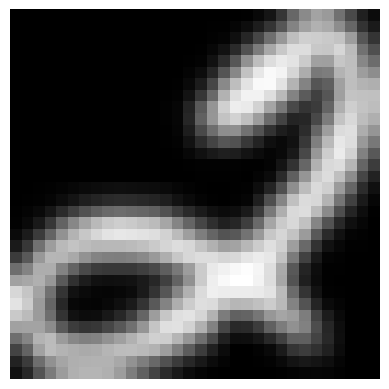

Shape of Input Real Image after 32x32 for class 0: torch.Size([1, 32, 32])
Displaying the first image with label tensor([9, 5, 8, 3, 6, 4, 7, 7, 2, 3, 8, 0, 6, 2, 0, 5, 9, 3, 0, 3, 4, 9, 7, 7,
        1, 9, 7, 1, 5, 2, 7, 6, 8, 3, 6, 8, 4, 4, 1, 1, 3, 0, 7, 6, 6, 2, 7, 3,
        9, 1, 9, 8, 6, 0, 8, 3, 1, 4, 6, 0, 7, 6, 9, 3, 8, 4, 1, 3, 2, 8, 4, 4,
        1, 2, 8, 0, 6, 2, 7, 0, 4, 3, 5, 1, 3, 4, 7, 5, 1, 8, 4, 4, 3, 8, 2, 1,
        7, 1, 7, 8, 8, 9, 7, 0, 0, 0, 6, 0, 1, 1, 5, 8, 4, 8, 9, 3, 2, 9, 5, 2,
        8, 4, 8, 3, 6, 8, 6, 4, 3, 2, 8, 8, 4, 4, 2, 9, 8, 6, 1, 5, 9, 6, 7, 0,
        2, 3, 0, 3, 3, 3, 2, 1, 8, 4, 8, 0, 2, 4, 2, 7, 1, 2, 8, 3, 7, 2, 1, 3,
        8, 0, 1, 8, 2, 5, 1, 8, 4, 2, 9, 8, 6, 3, 4, 3, 5, 4, 1, 6, 2, 5, 5, 3,
        8, 2, 6, 5, 7, 9, 1, 9, 3, 3, 5, 8, 3, 6, 4, 3, 0, 8, 9, 7, 0, 7, 2, 4,
        7, 8, 7, 7, 1, 2, 0, 2, 1, 7, 2, 0, 1, 1, 1, 0, 3, 0, 0, 4, 8, 1, 3, 2,
        3, 4, 1, 0, 6, 4, 3, 1, 3, 2, 7, 2, 4, 0, 6, 2, 6, 4, 0, 6, 7, 8, 8, 6,
       

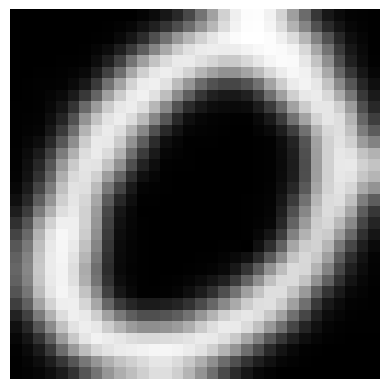

Shape of Input Real Image after 32x32 for class 1: torch.Size([1, 32, 32])
Displaying the first image with label tensor([9, 5, 8, 3, 6, 4, 7, 7, 2, 3, 8, 0, 6, 2, 0, 5, 9, 3, 0, 3, 4, 9, 7, 7,
        1, 9, 7, 1, 5, 2, 7, 6, 8, 3, 6, 8, 4, 4, 1, 1, 3, 0, 7, 6, 6, 2, 7, 3,
        9, 1, 9, 8, 6, 0, 8, 3, 1, 4, 6, 0, 7, 6, 9, 3, 8, 4, 1, 3, 2, 8, 4, 4,
        1, 2, 8, 0, 6, 2, 7, 0, 4, 3, 5, 1, 3, 4, 7, 5, 1, 8, 4, 4, 3, 8, 2, 1,
        7, 1, 7, 8, 8, 9, 7, 0, 0, 0, 6, 0, 1, 1, 5, 8, 4, 8, 9, 3, 2, 9, 5, 2,
        8, 4, 8, 3, 6, 8, 6, 4, 3, 2, 8, 8, 4, 4, 2, 9, 8, 6, 1, 5, 9, 6, 7, 0,
        2, 3, 0, 3, 3, 3, 2, 1, 8, 4, 8, 0, 2, 4, 2, 7, 1, 2, 8, 3, 7, 2, 1, 3,
        8, 0, 1, 8, 2, 5, 1, 8, 4, 2, 9, 8, 6, 3, 4, 3, 5, 4, 1, 6, 2, 5, 5, 3,
        8, 2, 6, 5, 7, 9, 1, 9, 3, 3, 5, 8, 3, 6, 4, 3, 0, 8, 9, 7, 0, 7, 2, 4,
        7, 8, 7, 7, 1, 2, 0, 2, 1, 7, 2, 0, 1, 1, 1, 0, 3, 0, 0, 4, 8, 1, 3, 2,
        3, 4, 1, 0, 6, 4, 3, 1, 3, 2, 7, 2, 4, 0, 6, 2, 6, 4, 0, 6, 7, 8, 8, 6,
       

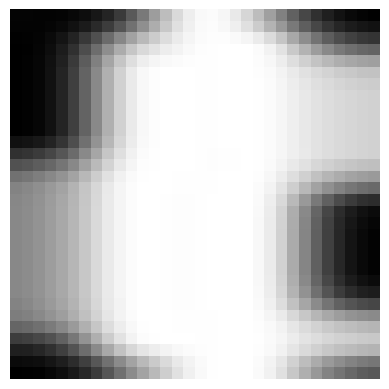

In [75]:
# Function to display an image
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize if necessary
    npimg = img.numpy()  # Convert tensor to NumPy array

    # Check if the image is grayscale or color
    if npimg.ndim == 3 and npimg.shape[0] == 1:  # Grayscale image (1, height, width)
        plt.imshow(npimg[0], cmap='gray')  # Remove the first dimension for grayscale
    elif npimg.ndim == 3 and npimg.shape[0] == 3:  # Color image (3, height, width)
        plt.imshow(np.transpose(npimg, (1, 2, 0)))  # Transpose to (height, width, channels)
    else:
        raise ValueError(f"Unsupported image shape: {npimg.shape}")

    plt.axis('off')  # Hide axes
    plt.show()

# Fetch and display the first image of class 6 from the trainloader
class_label = set()
found = False

# Loop through batches in the trainloader
for q_images, images, labels in trainloader:
    # Loop through each image in the current batch
    for i in range(len(labels)):
        label = labels[i].item()  # Get class label as an integer
        if label not in class_label:
            print(f"Shape of Input Real Image after 32x32 for class {labels[i]}: {images[i].shape}")
            print(f"Displaying the first image with label {labels}:")
            imshow(images[i])  # Display the image
            class_label.add(label)  # Mark class as displayed
        # Stop if all classes have been displayed
        if len(class_label) == 10:  # Assuming there are 10 classes in USPS
            break
    if len(class_label) == 10:
        break

Shape of Input Image after 32x32 to 16x16 for class 9: torch.Size([16, 16])
Displaying the first image with label tensor([9, 4, 1, 7, 6, 2, 5, 3, 3, 0, 6, 4, 8, 4, 1, 9, 0, 9, 4, 2, 9, 0, 7, 9,
        7, 8, 2, 0, 5, 8, 3, 3, 6, 7, 3, 0, 2, 0, 5, 0, 0, 4, 7, 8, 7, 0, 1, 7,
        0, 9, 1, 5, 6, 3, 2, 8, 6, 4, 1, 5, 7, 5, 7, 0, 1, 8, 2, 6, 9, 6, 7, 9,
        4, 0, 1, 0, 5, 9, 9, 0, 7, 5, 1, 5, 7, 8, 0, 2, 2, 1, 8, 1, 7, 6, 7, 4,
        7, 8, 3, 8, 8, 8, 4, 9, 9, 4, 1, 0, 9, 1, 9, 3, 5, 1, 5, 4, 5, 3, 1, 2,
        1, 5, 2, 7, 2, 9, 2, 0, 4, 4, 7, 2, 5, 8, 1, 3, 6, 1, 6, 5, 1, 9, 0, 1,
        8, 5, 5, 5, 4, 5, 7, 7, 4, 3, 2, 0, 7, 6, 5, 4, 8, 7, 8, 6, 6, 6, 7, 1,
        3, 3, 1, 1, 9, 7, 7, 0, 1, 6, 0, 1, 9, 9, 3, 1, 1, 4, 5, 5, 8, 9, 6, 7,
        5, 8, 3, 3, 8, 4, 7, 7, 6, 4, 1, 0, 7, 0, 4, 7, 3, 1, 5, 1, 0, 2, 6, 6,
        1, 3, 9, 2, 2, 7, 1, 6, 0, 7, 1, 4, 2, 7, 5, 2, 0, 7, 9, 2, 8, 2, 7, 7,
        8, 8, 9, 9, 9, 6, 5, 9, 5, 7, 3, 1, 6, 9, 9, 0, 5, 0, 8, 5, 8, 9, 7, 3,
      

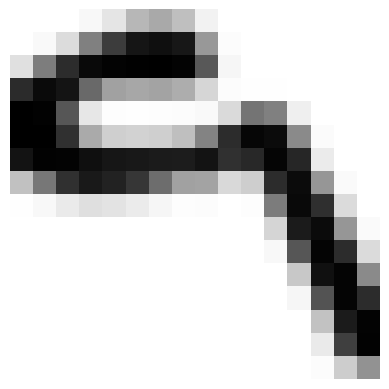

Shape of Input Image after 32x32 to 16x16 for class 4: torch.Size([16, 16])
Displaying the first image with label tensor([9, 4, 1, 7, 6, 2, 5, 3, 3, 0, 6, 4, 8, 4, 1, 9, 0, 9, 4, 2, 9, 0, 7, 9,
        7, 8, 2, 0, 5, 8, 3, 3, 6, 7, 3, 0, 2, 0, 5, 0, 0, 4, 7, 8, 7, 0, 1, 7,
        0, 9, 1, 5, 6, 3, 2, 8, 6, 4, 1, 5, 7, 5, 7, 0, 1, 8, 2, 6, 9, 6, 7, 9,
        4, 0, 1, 0, 5, 9, 9, 0, 7, 5, 1, 5, 7, 8, 0, 2, 2, 1, 8, 1, 7, 6, 7, 4,
        7, 8, 3, 8, 8, 8, 4, 9, 9, 4, 1, 0, 9, 1, 9, 3, 5, 1, 5, 4, 5, 3, 1, 2,
        1, 5, 2, 7, 2, 9, 2, 0, 4, 4, 7, 2, 5, 8, 1, 3, 6, 1, 6, 5, 1, 9, 0, 1,
        8, 5, 5, 5, 4, 5, 7, 7, 4, 3, 2, 0, 7, 6, 5, 4, 8, 7, 8, 6, 6, 6, 7, 1,
        3, 3, 1, 1, 9, 7, 7, 0, 1, 6, 0, 1, 9, 9, 3, 1, 1, 4, 5, 5, 8, 9, 6, 7,
        5, 8, 3, 3, 8, 4, 7, 7, 6, 4, 1, 0, 7, 0, 4, 7, 3, 1, 5, 1, 0, 2, 6, 6,
        1, 3, 9, 2, 2, 7, 1, 6, 0, 7, 1, 4, 2, 7, 5, 2, 0, 7, 9, 2, 8, 2, 7, 7,
        8, 8, 9, 9, 9, 6, 5, 9, 5, 7, 3, 1, 6, 9, 9, 0, 5, 0, 8, 5, 8, 9, 7, 3,
      

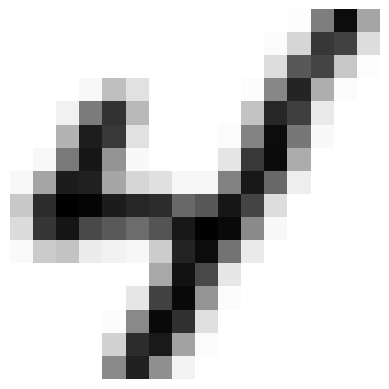

Shape of Input Image after 32x32 to 16x16 for class 1: torch.Size([16, 16])
Displaying the first image with label tensor([9, 4, 1, 7, 6, 2, 5, 3, 3, 0, 6, 4, 8, 4, 1, 9, 0, 9, 4, 2, 9, 0, 7, 9,
        7, 8, 2, 0, 5, 8, 3, 3, 6, 7, 3, 0, 2, 0, 5, 0, 0, 4, 7, 8, 7, 0, 1, 7,
        0, 9, 1, 5, 6, 3, 2, 8, 6, 4, 1, 5, 7, 5, 7, 0, 1, 8, 2, 6, 9, 6, 7, 9,
        4, 0, 1, 0, 5, 9, 9, 0, 7, 5, 1, 5, 7, 8, 0, 2, 2, 1, 8, 1, 7, 6, 7, 4,
        7, 8, 3, 8, 8, 8, 4, 9, 9, 4, 1, 0, 9, 1, 9, 3, 5, 1, 5, 4, 5, 3, 1, 2,
        1, 5, 2, 7, 2, 9, 2, 0, 4, 4, 7, 2, 5, 8, 1, 3, 6, 1, 6, 5, 1, 9, 0, 1,
        8, 5, 5, 5, 4, 5, 7, 7, 4, 3, 2, 0, 7, 6, 5, 4, 8, 7, 8, 6, 6, 6, 7, 1,
        3, 3, 1, 1, 9, 7, 7, 0, 1, 6, 0, 1, 9, 9, 3, 1, 1, 4, 5, 5, 8, 9, 6, 7,
        5, 8, 3, 3, 8, 4, 7, 7, 6, 4, 1, 0, 7, 0, 4, 7, 3, 1, 5, 1, 0, 2, 6, 6,
        1, 3, 9, 2, 2, 7, 1, 6, 0, 7, 1, 4, 2, 7, 5, 2, 0, 7, 9, 2, 8, 2, 7, 7,
        8, 8, 9, 9, 9, 6, 5, 9, 5, 7, 3, 1, 6, 9, 9, 0, 5, 0, 8, 5, 8, 9, 7, 3,
      

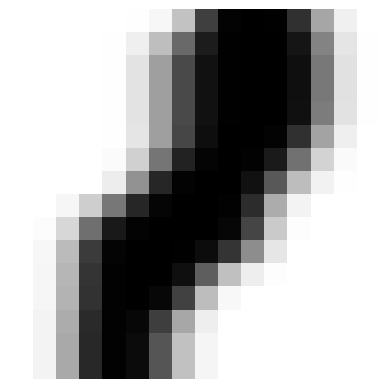

Shape of Input Image after 32x32 to 16x16 for class 7: torch.Size([16, 16])
Displaying the first image with label tensor([9, 4, 1, 7, 6, 2, 5, 3, 3, 0, 6, 4, 8, 4, 1, 9, 0, 9, 4, 2, 9, 0, 7, 9,
        7, 8, 2, 0, 5, 8, 3, 3, 6, 7, 3, 0, 2, 0, 5, 0, 0, 4, 7, 8, 7, 0, 1, 7,
        0, 9, 1, 5, 6, 3, 2, 8, 6, 4, 1, 5, 7, 5, 7, 0, 1, 8, 2, 6, 9, 6, 7, 9,
        4, 0, 1, 0, 5, 9, 9, 0, 7, 5, 1, 5, 7, 8, 0, 2, 2, 1, 8, 1, 7, 6, 7, 4,
        7, 8, 3, 8, 8, 8, 4, 9, 9, 4, 1, 0, 9, 1, 9, 3, 5, 1, 5, 4, 5, 3, 1, 2,
        1, 5, 2, 7, 2, 9, 2, 0, 4, 4, 7, 2, 5, 8, 1, 3, 6, 1, 6, 5, 1, 9, 0, 1,
        8, 5, 5, 5, 4, 5, 7, 7, 4, 3, 2, 0, 7, 6, 5, 4, 8, 7, 8, 6, 6, 6, 7, 1,
        3, 3, 1, 1, 9, 7, 7, 0, 1, 6, 0, 1, 9, 9, 3, 1, 1, 4, 5, 5, 8, 9, 6, 7,
        5, 8, 3, 3, 8, 4, 7, 7, 6, 4, 1, 0, 7, 0, 4, 7, 3, 1, 5, 1, 0, 2, 6, 6,
        1, 3, 9, 2, 2, 7, 1, 6, 0, 7, 1, 4, 2, 7, 5, 2, 0, 7, 9, 2, 8, 2, 7, 7,
        8, 8, 9, 9, 9, 6, 5, 9, 5, 7, 3, 1, 6, 9, 9, 0, 5, 0, 8, 5, 8, 9, 7, 3,
      

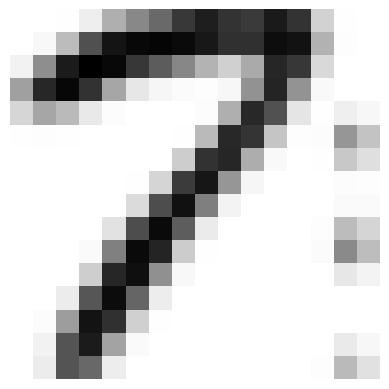

Shape of Input Image after 32x32 to 16x16 for class 6: torch.Size([16, 16])
Displaying the first image with label tensor([9, 4, 1, 7, 6, 2, 5, 3, 3, 0, 6, 4, 8, 4, 1, 9, 0, 9, 4, 2, 9, 0, 7, 9,
        7, 8, 2, 0, 5, 8, 3, 3, 6, 7, 3, 0, 2, 0, 5, 0, 0, 4, 7, 8, 7, 0, 1, 7,
        0, 9, 1, 5, 6, 3, 2, 8, 6, 4, 1, 5, 7, 5, 7, 0, 1, 8, 2, 6, 9, 6, 7, 9,
        4, 0, 1, 0, 5, 9, 9, 0, 7, 5, 1, 5, 7, 8, 0, 2, 2, 1, 8, 1, 7, 6, 7, 4,
        7, 8, 3, 8, 8, 8, 4, 9, 9, 4, 1, 0, 9, 1, 9, 3, 5, 1, 5, 4, 5, 3, 1, 2,
        1, 5, 2, 7, 2, 9, 2, 0, 4, 4, 7, 2, 5, 8, 1, 3, 6, 1, 6, 5, 1, 9, 0, 1,
        8, 5, 5, 5, 4, 5, 7, 7, 4, 3, 2, 0, 7, 6, 5, 4, 8, 7, 8, 6, 6, 6, 7, 1,
        3, 3, 1, 1, 9, 7, 7, 0, 1, 6, 0, 1, 9, 9, 3, 1, 1, 4, 5, 5, 8, 9, 6, 7,
        5, 8, 3, 3, 8, 4, 7, 7, 6, 4, 1, 0, 7, 0, 4, 7, 3, 1, 5, 1, 0, 2, 6, 6,
        1, 3, 9, 2, 2, 7, 1, 6, 0, 7, 1, 4, 2, 7, 5, 2, 0, 7, 9, 2, 8, 2, 7, 7,
        8, 8, 9, 9, 9, 6, 5, 9, 5, 7, 3, 1, 6, 9, 9, 0, 5, 0, 8, 5, 8, 9, 7, 3,
      

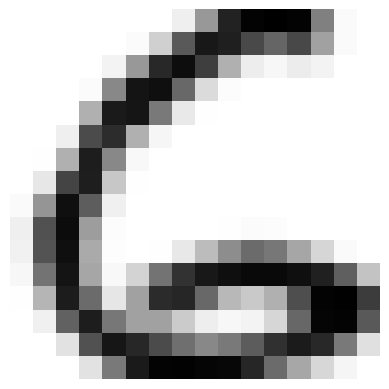

Shape of Input Image after 32x32 to 16x16 for class 2: torch.Size([16, 16])
Displaying the first image with label tensor([9, 4, 1, 7, 6, 2, 5, 3, 3, 0, 6, 4, 8, 4, 1, 9, 0, 9, 4, 2, 9, 0, 7, 9,
        7, 8, 2, 0, 5, 8, 3, 3, 6, 7, 3, 0, 2, 0, 5, 0, 0, 4, 7, 8, 7, 0, 1, 7,
        0, 9, 1, 5, 6, 3, 2, 8, 6, 4, 1, 5, 7, 5, 7, 0, 1, 8, 2, 6, 9, 6, 7, 9,
        4, 0, 1, 0, 5, 9, 9, 0, 7, 5, 1, 5, 7, 8, 0, 2, 2, 1, 8, 1, 7, 6, 7, 4,
        7, 8, 3, 8, 8, 8, 4, 9, 9, 4, 1, 0, 9, 1, 9, 3, 5, 1, 5, 4, 5, 3, 1, 2,
        1, 5, 2, 7, 2, 9, 2, 0, 4, 4, 7, 2, 5, 8, 1, 3, 6, 1, 6, 5, 1, 9, 0, 1,
        8, 5, 5, 5, 4, 5, 7, 7, 4, 3, 2, 0, 7, 6, 5, 4, 8, 7, 8, 6, 6, 6, 7, 1,
        3, 3, 1, 1, 9, 7, 7, 0, 1, 6, 0, 1, 9, 9, 3, 1, 1, 4, 5, 5, 8, 9, 6, 7,
        5, 8, 3, 3, 8, 4, 7, 7, 6, 4, 1, 0, 7, 0, 4, 7, 3, 1, 5, 1, 0, 2, 6, 6,
        1, 3, 9, 2, 2, 7, 1, 6, 0, 7, 1, 4, 2, 7, 5, 2, 0, 7, 9, 2, 8, 2, 7, 7,
        8, 8, 9, 9, 9, 6, 5, 9, 5, 7, 3, 1, 6, 9, 9, 0, 5, 0, 8, 5, 8, 9, 7, 3,
      

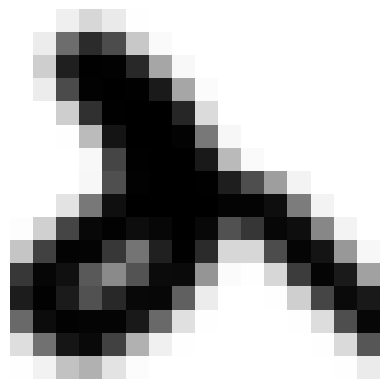

Shape of Input Image after 32x32 to 16x16 for class 5: torch.Size([16, 16])
Displaying the first image with label tensor([9, 4, 1, 7, 6, 2, 5, 3, 3, 0, 6, 4, 8, 4, 1, 9, 0, 9, 4, 2, 9, 0, 7, 9,
        7, 8, 2, 0, 5, 8, 3, 3, 6, 7, 3, 0, 2, 0, 5, 0, 0, 4, 7, 8, 7, 0, 1, 7,
        0, 9, 1, 5, 6, 3, 2, 8, 6, 4, 1, 5, 7, 5, 7, 0, 1, 8, 2, 6, 9, 6, 7, 9,
        4, 0, 1, 0, 5, 9, 9, 0, 7, 5, 1, 5, 7, 8, 0, 2, 2, 1, 8, 1, 7, 6, 7, 4,
        7, 8, 3, 8, 8, 8, 4, 9, 9, 4, 1, 0, 9, 1, 9, 3, 5, 1, 5, 4, 5, 3, 1, 2,
        1, 5, 2, 7, 2, 9, 2, 0, 4, 4, 7, 2, 5, 8, 1, 3, 6, 1, 6, 5, 1, 9, 0, 1,
        8, 5, 5, 5, 4, 5, 7, 7, 4, 3, 2, 0, 7, 6, 5, 4, 8, 7, 8, 6, 6, 6, 7, 1,
        3, 3, 1, 1, 9, 7, 7, 0, 1, 6, 0, 1, 9, 9, 3, 1, 1, 4, 5, 5, 8, 9, 6, 7,
        5, 8, 3, 3, 8, 4, 7, 7, 6, 4, 1, 0, 7, 0, 4, 7, 3, 1, 5, 1, 0, 2, 6, 6,
        1, 3, 9, 2, 2, 7, 1, 6, 0, 7, 1, 4, 2, 7, 5, 2, 0, 7, 9, 2, 8, 2, 7, 7,
        8, 8, 9, 9, 9, 6, 5, 9, 5, 7, 3, 1, 6, 9, 9, 0, 5, 0, 8, 5, 8, 9, 7, 3,
      

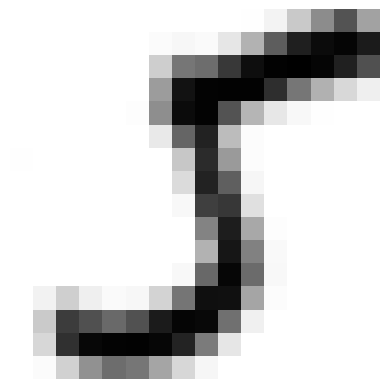

Shape of Input Image after 32x32 to 16x16 for class 3: torch.Size([16, 16])
Displaying the first image with label tensor([9, 4, 1, 7, 6, 2, 5, 3, 3, 0, 6, 4, 8, 4, 1, 9, 0, 9, 4, 2, 9, 0, 7, 9,
        7, 8, 2, 0, 5, 8, 3, 3, 6, 7, 3, 0, 2, 0, 5, 0, 0, 4, 7, 8, 7, 0, 1, 7,
        0, 9, 1, 5, 6, 3, 2, 8, 6, 4, 1, 5, 7, 5, 7, 0, 1, 8, 2, 6, 9, 6, 7, 9,
        4, 0, 1, 0, 5, 9, 9, 0, 7, 5, 1, 5, 7, 8, 0, 2, 2, 1, 8, 1, 7, 6, 7, 4,
        7, 8, 3, 8, 8, 8, 4, 9, 9, 4, 1, 0, 9, 1, 9, 3, 5, 1, 5, 4, 5, 3, 1, 2,
        1, 5, 2, 7, 2, 9, 2, 0, 4, 4, 7, 2, 5, 8, 1, 3, 6, 1, 6, 5, 1, 9, 0, 1,
        8, 5, 5, 5, 4, 5, 7, 7, 4, 3, 2, 0, 7, 6, 5, 4, 8, 7, 8, 6, 6, 6, 7, 1,
        3, 3, 1, 1, 9, 7, 7, 0, 1, 6, 0, 1, 9, 9, 3, 1, 1, 4, 5, 5, 8, 9, 6, 7,
        5, 8, 3, 3, 8, 4, 7, 7, 6, 4, 1, 0, 7, 0, 4, 7, 3, 1, 5, 1, 0, 2, 6, 6,
        1, 3, 9, 2, 2, 7, 1, 6, 0, 7, 1, 4, 2, 7, 5, 2, 0, 7, 9, 2, 8, 2, 7, 7,
        8, 8, 9, 9, 9, 6, 5, 9, 5, 7, 3, 1, 6, 9, 9, 0, 5, 0, 8, 5, 8, 9, 7, 3,
      

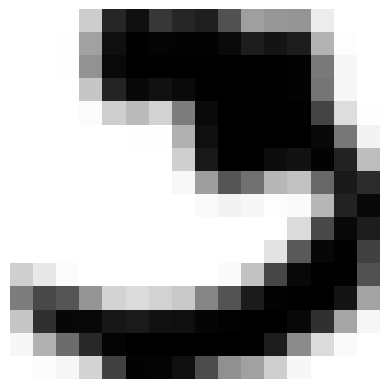

Shape of Input Image after 32x32 to 16x16 for class 0: torch.Size([16, 16])
Displaying the first image with label tensor([9, 4, 1, 7, 6, 2, 5, 3, 3, 0, 6, 4, 8, 4, 1, 9, 0, 9, 4, 2, 9, 0, 7, 9,
        7, 8, 2, 0, 5, 8, 3, 3, 6, 7, 3, 0, 2, 0, 5, 0, 0, 4, 7, 8, 7, 0, 1, 7,
        0, 9, 1, 5, 6, 3, 2, 8, 6, 4, 1, 5, 7, 5, 7, 0, 1, 8, 2, 6, 9, 6, 7, 9,
        4, 0, 1, 0, 5, 9, 9, 0, 7, 5, 1, 5, 7, 8, 0, 2, 2, 1, 8, 1, 7, 6, 7, 4,
        7, 8, 3, 8, 8, 8, 4, 9, 9, 4, 1, 0, 9, 1, 9, 3, 5, 1, 5, 4, 5, 3, 1, 2,
        1, 5, 2, 7, 2, 9, 2, 0, 4, 4, 7, 2, 5, 8, 1, 3, 6, 1, 6, 5, 1, 9, 0, 1,
        8, 5, 5, 5, 4, 5, 7, 7, 4, 3, 2, 0, 7, 6, 5, 4, 8, 7, 8, 6, 6, 6, 7, 1,
        3, 3, 1, 1, 9, 7, 7, 0, 1, 6, 0, 1, 9, 9, 3, 1, 1, 4, 5, 5, 8, 9, 6, 7,
        5, 8, 3, 3, 8, 4, 7, 7, 6, 4, 1, 0, 7, 0, 4, 7, 3, 1, 5, 1, 0, 2, 6, 6,
        1, 3, 9, 2, 2, 7, 1, 6, 0, 7, 1, 4, 2, 7, 5, 2, 0, 7, 9, 2, 8, 2, 7, 7,
        8, 8, 9, 9, 9, 6, 5, 9, 5, 7, 3, 1, 6, 9, 9, 0, 5, 0, 8, 5, 8, 9, 7, 3,
      

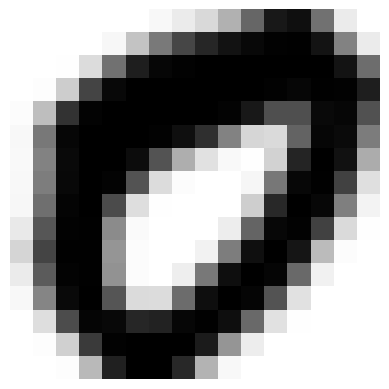

Shape of Input Image after 32x32 to 16x16 for class 8: torch.Size([16, 16])
Displaying the first image with label tensor([9, 4, 1, 7, 6, 2, 5, 3, 3, 0, 6, 4, 8, 4, 1, 9, 0, 9, 4, 2, 9, 0, 7, 9,
        7, 8, 2, 0, 5, 8, 3, 3, 6, 7, 3, 0, 2, 0, 5, 0, 0, 4, 7, 8, 7, 0, 1, 7,
        0, 9, 1, 5, 6, 3, 2, 8, 6, 4, 1, 5, 7, 5, 7, 0, 1, 8, 2, 6, 9, 6, 7, 9,
        4, 0, 1, 0, 5, 9, 9, 0, 7, 5, 1, 5, 7, 8, 0, 2, 2, 1, 8, 1, 7, 6, 7, 4,
        7, 8, 3, 8, 8, 8, 4, 9, 9, 4, 1, 0, 9, 1, 9, 3, 5, 1, 5, 4, 5, 3, 1, 2,
        1, 5, 2, 7, 2, 9, 2, 0, 4, 4, 7, 2, 5, 8, 1, 3, 6, 1, 6, 5, 1, 9, 0, 1,
        8, 5, 5, 5, 4, 5, 7, 7, 4, 3, 2, 0, 7, 6, 5, 4, 8, 7, 8, 6, 6, 6, 7, 1,
        3, 3, 1, 1, 9, 7, 7, 0, 1, 6, 0, 1, 9, 9, 3, 1, 1, 4, 5, 5, 8, 9, 6, 7,
        5, 8, 3, 3, 8, 4, 7, 7, 6, 4, 1, 0, 7, 0, 4, 7, 3, 1, 5, 1, 0, 2, 6, 6,
        1, 3, 9, 2, 2, 7, 1, 6, 0, 7, 1, 4, 2, 7, 5, 2, 0, 7, 9, 2, 8, 2, 7, 7,
        8, 8, 9, 9, 9, 6, 5, 9, 5, 7, 3, 1, 6, 9, 9, 0, 5, 0, 8, 5, 8, 9, 7, 3,
      

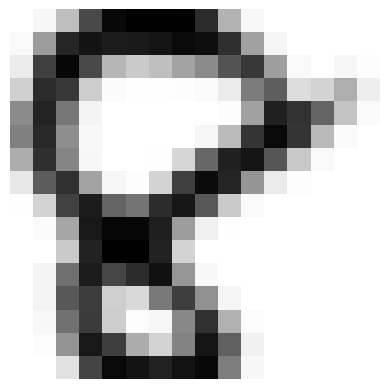

In [76]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5  # Unnormalize (if images were normalized during training)
    npimg = img.numpy()  # Convert tensor to NumPy array
    
    # Check if the image is grayscale or color
    if npimg.ndim == 2:  # Grayscale image (height, width)
        plt.imshow(npimg, cmap='gray')
    elif npimg.ndim == 3 and npimg.shape[0] in [1, 3]:  # Single-channel or 3-channel image
        plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray' if npimg.shape[0] == 1 else None)
    else:
        raise ValueError("Unsupported image shape: {}".format(npimg.shape))
        
    plt.axis('off')  # Hide axes
    plt.show()

#print(q_images.shape)
# Filter images from class 5
class_label = set()
found = False

# Loop through batches in the trainloader
for q_images, images, labels in trainloader:
    # Loop through each image in the current batch
    for i in range(len(labels)):
        label = labels[i].item()  # Get class label as an integer
        if label not in class_label:
            print(f"Shape of Input Image after 32x32 to 16x16 for class {labels[i]}: {q_images[i].shape}")
            print(f"Displaying the first image with label {labels}:")
            imshow(q_images[i])  # Display the image
            class_label.add(label)  # Mark class as displayed
        # Stop if all classes have been displayed
        if len(class_label) == 10:  # Assuming there are 10 classes in USPS
            break
    if len(class_label) == 10:
        break

Shape of Original Image for class 2: torch.Size([1, 32, 32])
Displaying the first image with label 2:


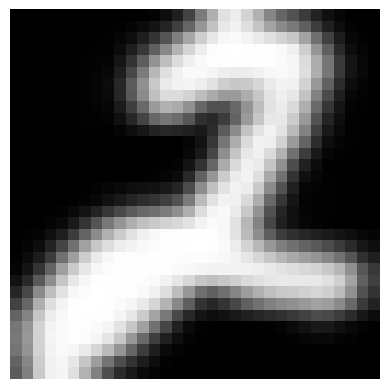

Shape of Original Image for class 9: torch.Size([1, 32, 32])
Displaying the first image with label 9:


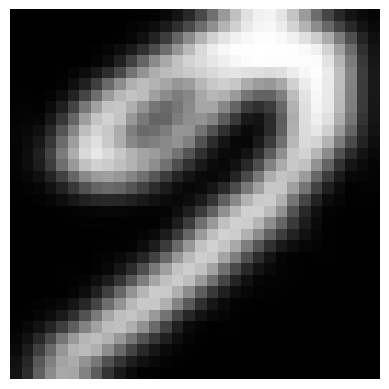

Shape of Original Image for class 7: torch.Size([1, 32, 32])
Displaying the first image with label 7:


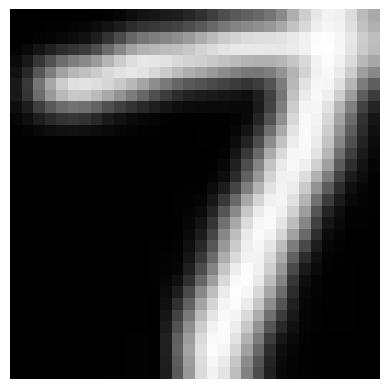

Shape of Original Image for class 6: torch.Size([1, 32, 32])
Displaying the first image with label 6:


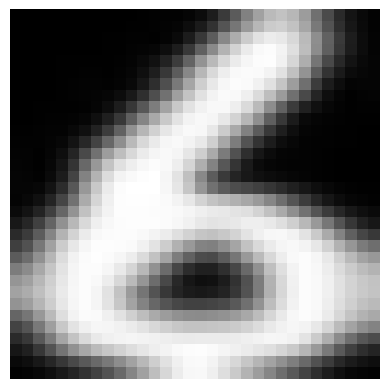

Shape of Original Image for class 1: torch.Size([1, 32, 32])
Displaying the first image with label 1:


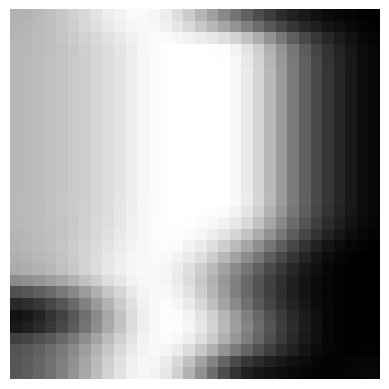

Shape of Original Image for class 3: torch.Size([1, 32, 32])
Displaying the first image with label 3:


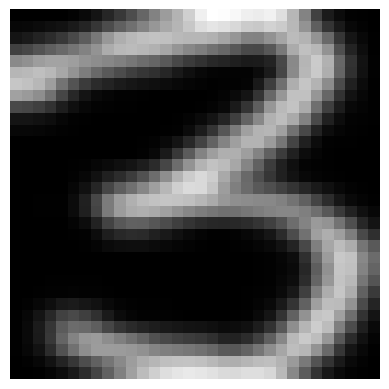

Shape of Original Image for class 4: torch.Size([1, 32, 32])
Displaying the first image with label 4:


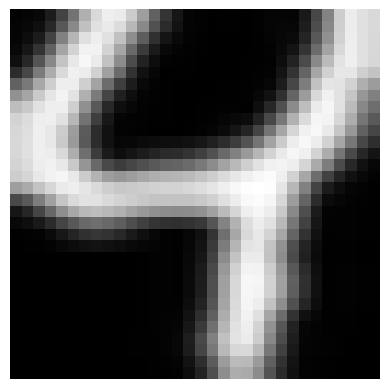

Shape of Original Image for class 8: torch.Size([1, 32, 32])
Displaying the first image with label 8:


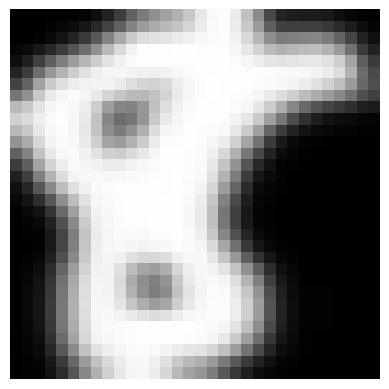

Shape of Original Image for class 5: torch.Size([1, 32, 32])
Displaying the first image with label 5:


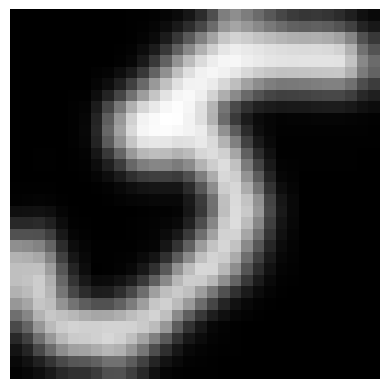

Shape of Original Image for class 0: torch.Size([1, 32, 32])
Displaying the first image with label 0:


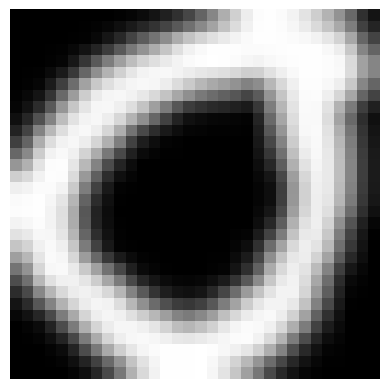


Displaying the corresponding classial reconstructed images:
Displaying reconstructed image for class 2 at index 0:


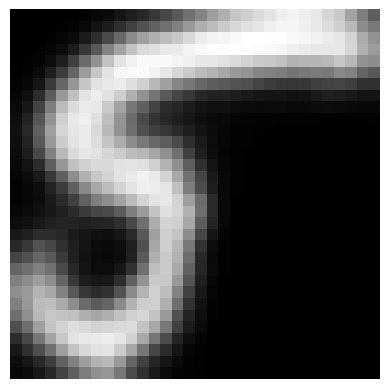

Displaying reconstructed image for class 9 at index 1:


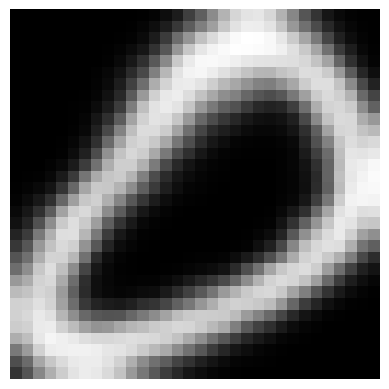

Displaying reconstructed image for class 7 at index 2:


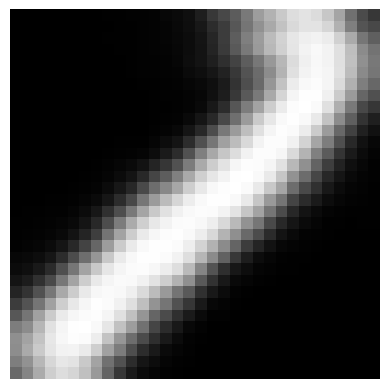

Displaying reconstructed image for class 6 at index 3:


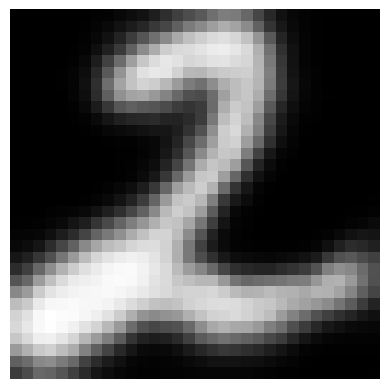

Displaying reconstructed image for class 1 at index 4:


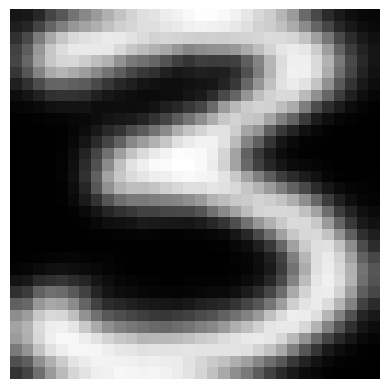

Displaying reconstructed image for class 3 at index 8:


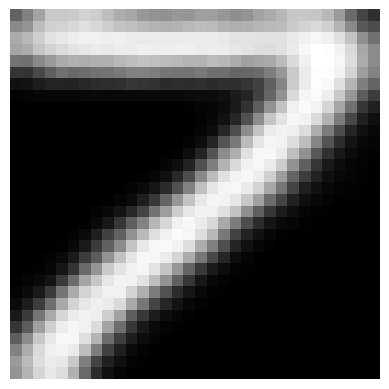

Displaying reconstructed image for class 4 at index 9:


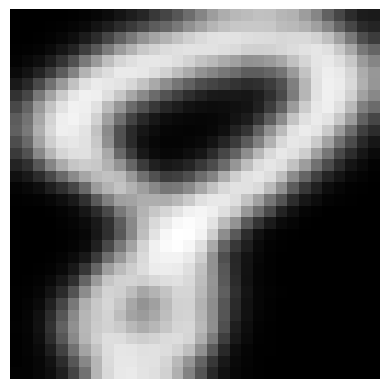

Displaying reconstructed image for class 8 at index 12:


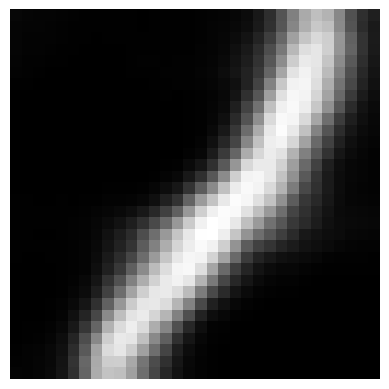

Displaying reconstructed image for class 5 at index 16:


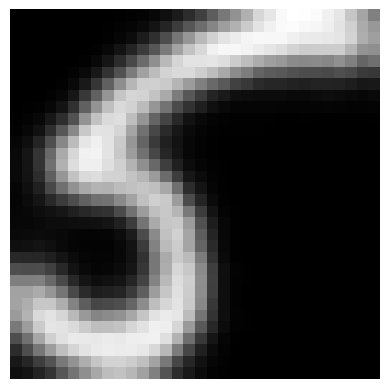

Displaying reconstructed image for class 0 at index 59:


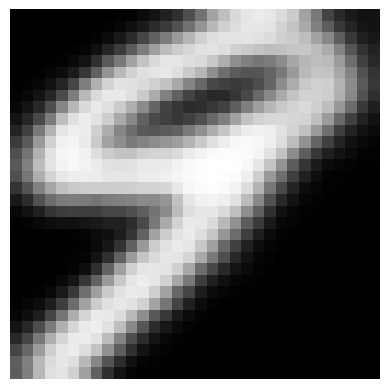

In [77]:
import matplotlib.pyplot as plt
import numpy as np

# Define a function to display an image
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize if necessary
    npimg = img.numpy()  # Convert tensor to NumPy array
    if npimg.ndim == 3 and npimg.shape[0] == 1:  # Grayscale image
        plt.imshow(npimg[0], cmap='gray')
    elif npimg.ndim == 2:  # Direct 2D grayscale image
        plt.imshow(npimg, cmap='gray')
    else:
        raise ValueError(f"Unsupported image shape: {npimg.shape}")

    plt.axis('off')  # Hide axes
    plt.show()

# Set up to track first occurrence of each class
first_indices = {}
class_labels = set()
found=False
# Loop through batches in the trainloader
for batch_idx, (q_images, images, labels) in enumerate(trainloader):
    for i in range(len(labels)):
        label = labels[i].item()  # Get label as integer
        if label not in class_labels:
            print(f"Shape of Original Image for class {label}: {images[i].shape}")
            print(f"Displaying the first image with label {label}:")
            imshow(images[i])  # Display the first image of this class

            first_indices[label] = batch_idx * len(labels) + i  # Store index
            class_labels.add(label)
            found=True

        if len(class_labels) == 10:  # Assuming USPS has 10 classes
            break
    if len(class_labels) == 10:
        break

# Now display the corresponding reconstructed images for the same indices
print("\nDisplaying the corresponding classial reconstructed images:")

for label, index in first_indices.items():
    print(f"Displaying reconstructed image for class {label} at index {index}:")
    reconstructed_image = c_reconstructed_images[index].view(1, 32, 32)  # Reshape if necessary
    imshow(reconstructed_image.detach().cpu())  # Detach and move to CPU for display

Shape of Original Image for class 6: torch.Size([1, 32, 32])
Displaying the first image with label 6:


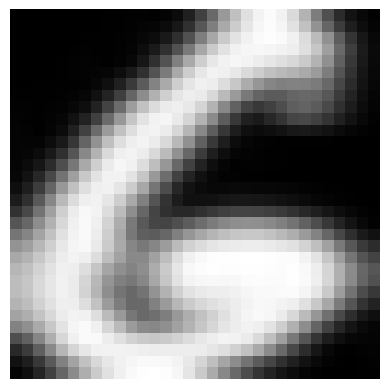

Shape of Original Image for class 2: torch.Size([1, 32, 32])
Displaying the first image with label 2:


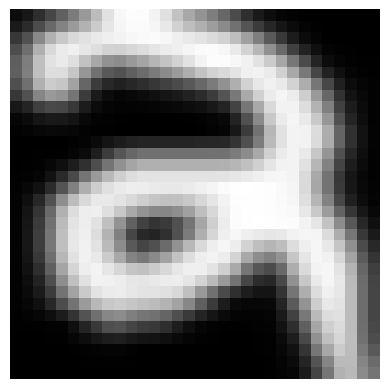

Shape of Original Image for class 3: torch.Size([1, 32, 32])
Displaying the first image with label 3:


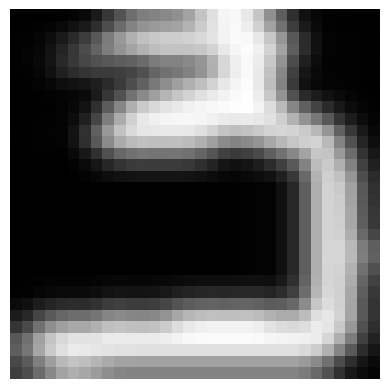

Shape of Original Image for class 1: torch.Size([1, 32, 32])
Displaying the first image with label 1:


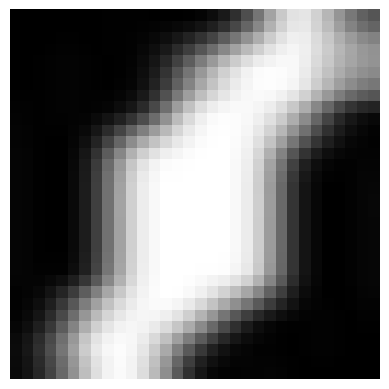

Shape of Original Image for class 4: torch.Size([1, 32, 32])
Displaying the first image with label 4:


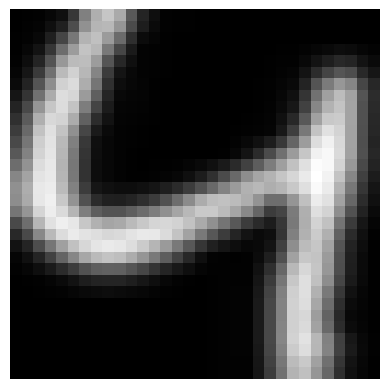

Shape of Original Image for class 0: torch.Size([1, 32, 32])
Displaying the first image with label 0:


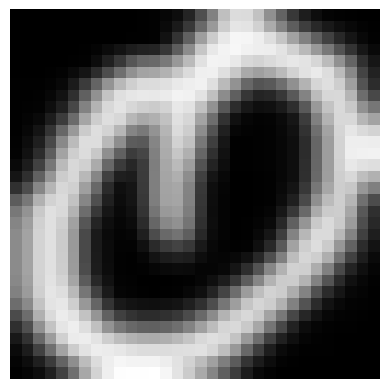

Shape of Original Image for class 5: torch.Size([1, 32, 32])
Displaying the first image with label 5:


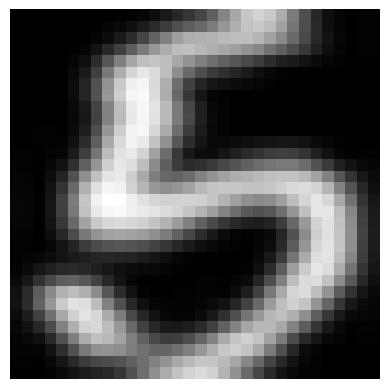

Shape of Original Image for class 8: torch.Size([1, 32, 32])
Displaying the first image with label 8:


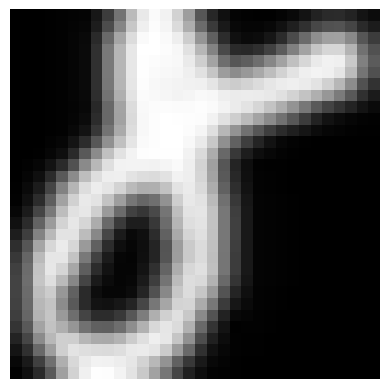

Shape of Original Image for class 7: torch.Size([1, 32, 32])
Displaying the first image with label 7:


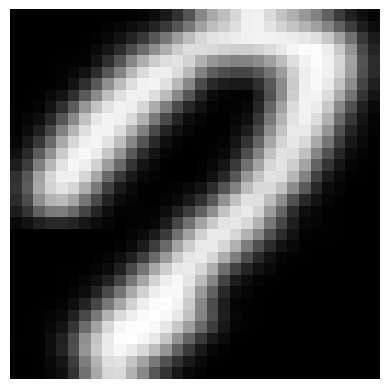

Shape of Original Image for class 9: torch.Size([1, 32, 32])
Displaying the first image with label 9:


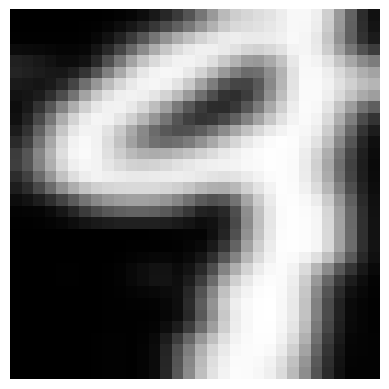


Displaying the corresponding classial reconstructed images:
Displaying reconstructed image for class 6 at index 0:


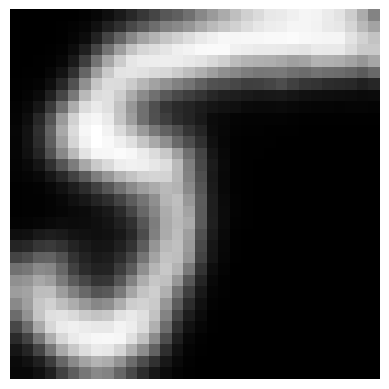

Displaying reconstructed image for class 2 at index 1:


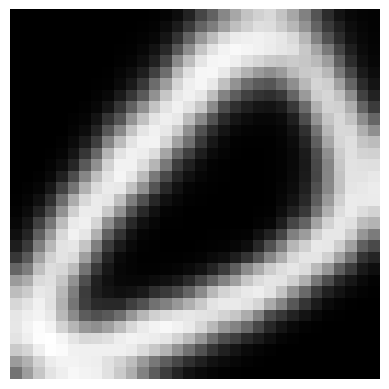

Displaying reconstructed image for class 3 at index 2:


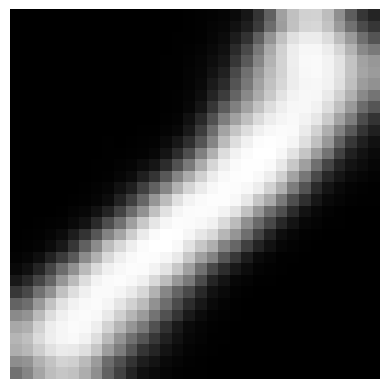

Displaying reconstructed image for class 1 at index 3:


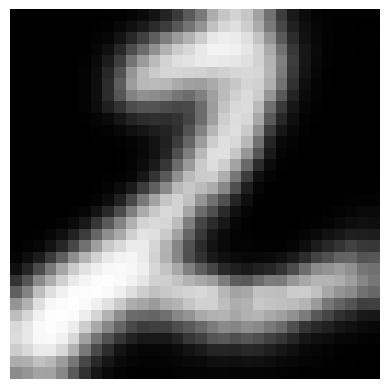

Displaying reconstructed image for class 4 at index 5:


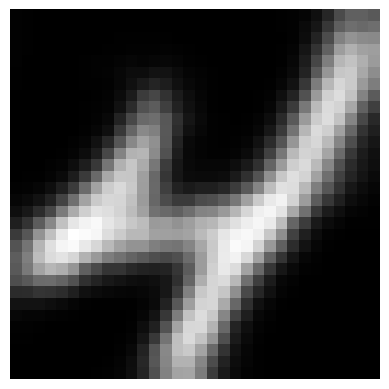

Displaying reconstructed image for class 0 at index 6:


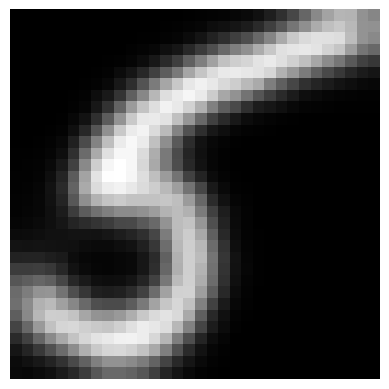

Displaying reconstructed image for class 5 at index 11:


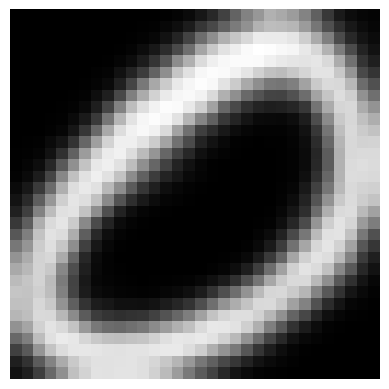

Displaying reconstructed image for class 8 at index 15:


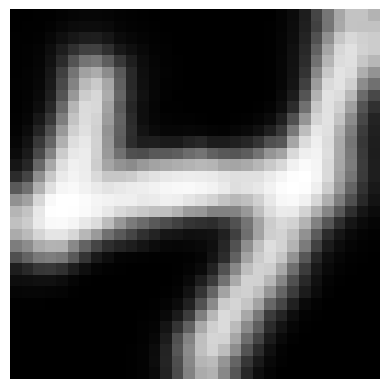

Displaying reconstructed image for class 7 at index 16:


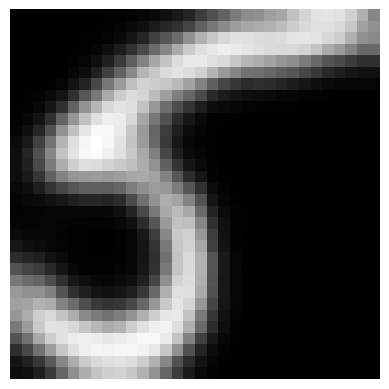

Displaying reconstructed image for class 9 at index 24:


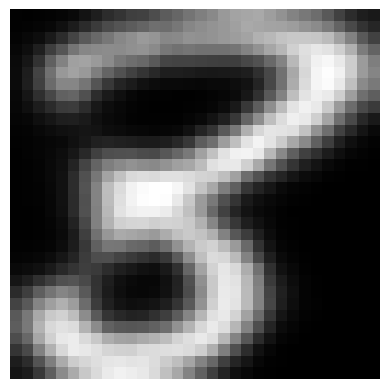

In [78]:
import matplotlib.pyplot as plt
import numpy as np

# Define a function to display an image
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize if necessary
    npimg = img.numpy()  # Convert tensor to NumPy array
    if npimg.ndim == 3 and npimg.shape[0] == 1:  # Grayscale image
        plt.imshow(npimg[0], cmap='gray')
    elif npimg.ndim == 2:  # Direct 2D grayscale image
        plt.imshow(npimg, cmap='gray')
    else:
        raise ValueError(f"Unsupported image shape: {npimg.shape}")

    plt.axis('off')  # Hide axes
    plt.show()

# Set up to track first occurrence of each class
first_indices = {}
class_labels = set()
found=False
# Loop through batches in the trainloader
for batch_idx, (q_images, images, labels) in enumerate(trainloader):
    for i in range(len(labels)):
        label = labels[i].item()  # Get label as integer
        if label not in class_labels:
            print(f"Shape of Original Image for class {label}: {images[i].shape}")
            print(f"Displaying the first image with label {label}:")
            imshow(images[i])  # Display the first image of this class

            first_indices[label] = batch_idx * len(labels) + i  # Store index
            class_labels.add(label)
            found=True

        if len(class_labels) == 10:  # Assuming USPS has 10 classes
            break
    if len(class_labels) == 10:
        break

# Now display the corresponding reconstructed images for the same indices
print("\nDisplaying the corresponding classial reconstructed images:")

for label, index in first_indices.items():
    print(f"Displaying reconstructed image for class {label} at index {index}:")
    reconstructed_image = q_reconstructed_images[index].view(1, 32, 32)  # Reshape if necessary
    imshow(reconstructed_image.detach().cpu())  # Detach and move to CPU for display

Visualizing transformations:   0%|          | 0/5 [00:00<?, ?it/s]

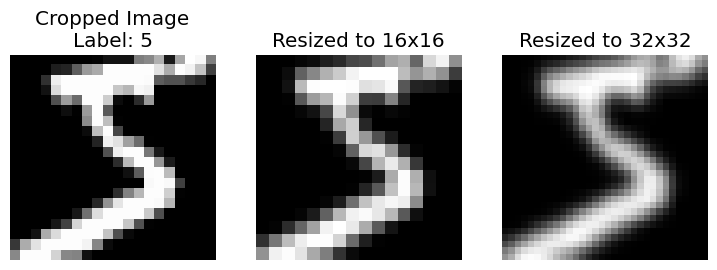

Visualizing transformations:  20%|██        | 1/5 [00:00<00:00,  5.49it/s]

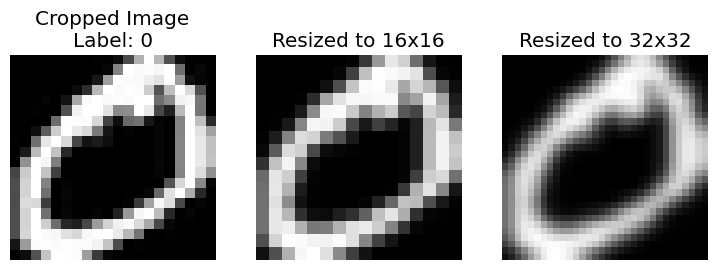

Visualizing transformations:  40%|████      | 2/5 [00:00<00:00,  5.73it/s]

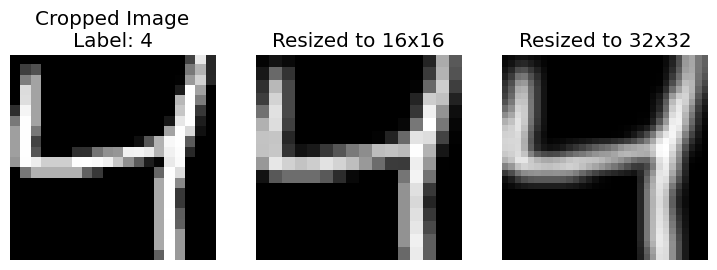

Visualizing transformations:  60%|██████    | 3/5 [00:00<00:00,  6.16it/s]

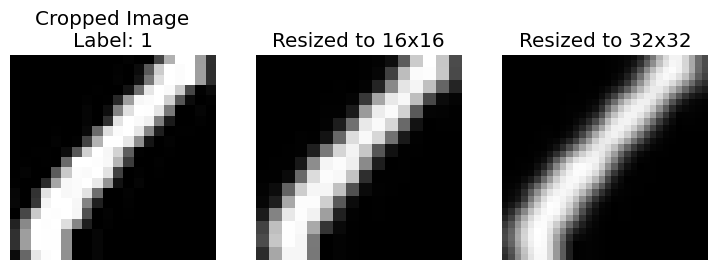

Visualizing transformations:  80%|████████  | 4/5 [00:00<00:00,  6.43it/s]

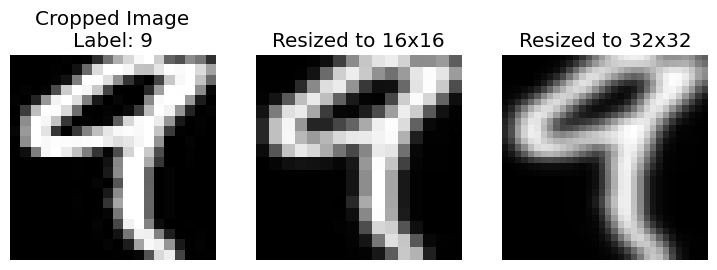

Visualizing transformations: 100%|██████████| 5/5 [00:00<00:00,  6.36it/s]

Transformation visualization completed.


In [83]:
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from tqdm import tqdm

# Load the cropped MNIST images and targets
cropped_train_images = np.load('ccropped_train_images.npy', allow_pickle=True)  # Shape: (num_samples, 24, 24)
cropped_train_targets = np.load('ccropped_train_targets.npy', allow_pickle=True)  # Shape: (num_samples,)

# Define the transformation to resize images to 16x16 and then to 32x32
transform_16x16 = transforms.Resize((16, 16))  # Resize to 16x16
transform_32x32 = transforms.Resize((32, 32))  # Resize to 32x32

# Function to visualize images at each stage
def visualize_images(original, resized_16x16, resized_32x32, label):
    plt.figure(figsize=(9, 3))
    
    # Original cropped image
    plt.subplot(1, 3, 1)
    plt.imshow(original, cmap='gray')
    plt.title(f'Cropped Image\nLabel: {label}')
    plt.axis('off')
    
    # Resized to 16x16
    plt.subplot(1, 3, 2)
    plt.imshow(resized_16x16, cmap='gray')
    plt.title('Resized to 16x16')
    plt.axis('off')
    
    # Resized to 32x32
    plt.subplot(1, 3, 3)
    plt.imshow(resized_32x32, cmap='gray')
    plt.title('Resized to 32x32')
    plt.axis('off')
    
    plt.show()

# Transform and visualize a subset of images
for i in tqdm(range(5), desc="Visualizing transformations"):
    # Original image as 24x24 numpy array
    original_image = cropped_train_images[i]
    
    # Convert to PIL image for transformations
    image_pil = Image.fromarray((original_image * 255).astype(np.uint8))
    
    # First transformation: Resize to 16x16
    resized_16x16_image = transform_16x16(image_pil)
    
    # Second transformation: Resize 16x16 to 32x32
    resized_32x32_image = transform_32x32(resized_16x16_image)
    
    # Convert images back to numpy arrays for visualization
    original_array = np.array(original_image)
    resized_16x16_array = np.array(resized_16x16_image)
    resized_32x32_array = np.array(resized_32x32_image)
    
    # Visualize the transformations
    visualize_images(original_array, resized_16x16_array, resized_32x32_array, cropped_train_targets[i])

print("Transformation visualization completed.")